# Synthetic Generator Testbed

**Complete workflow for fitting real datasets with nirs4all synthetic features.**

## Sections

1. **Dataset Loading** - Signal type detection, preprocessing inference
2. **RealDataFitter** - Complete parameter estimation
3. **Pure Band Fitting** - Voigt/Gaussian bands WITHOUT predefined components
4. **Dataset Categories** - Component mapping for prioritized fitting
5. **Constrained Component Fitting** - Category-aware component selection
6. **Pure Band Refinement** - Residual fitting after components
7. **Diversity Parameter Fitting** - Noise, scattering, baseline variations
8. **Synthetic Data Generation** - Full pipeline generation
9. **Discriminator Test** - Quality validation
10. **Complete Summary** - Initial results

### NEW SECTIONS (Real Bands from NIR_BANDS Dictionary)

11. **Real Band Fitting** - Using known band positions from `_bands.py`
12. **Components + Real Bands** - Combined chemical + physical fitting
13. **Comprehensive Summary** - All approaches comparison
14. **Big Grid Chart** - Visual comparison matrix
15. **Extended Conclusions** - Recommendations and findings

In [1]:
import sys
import warnings
from collections.abc import Callable
from dataclasses import dataclass, field
from pathlib import Path
from typing import Any, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal as scipy_signal
from scipy.optimize import differential_evolution, minimize, nnls
from scipy.special import voigt_profile
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet, Lasso, OrthogonalMatchingPursuit, Ridge

warnings.filterwarnings('ignore')

root = Path.cwd().parent.parent
if str(root) not in sys.path:
    sys.path.insert(0, str(root))

from nirs4all.data import DatasetConfigs, SignalType, detect_signal_type
from nirs4all.data.synthetic import (
    ComponentFitResult,
    ComponentFitter,
    ComponentLibrary,
    FittedParameters,
    PreprocessingType,
    RealDataFitter,
    SyntheticNIRSGenerator,
    available_components,
    get_component,
)
from nirs4all.operators.augmentation import (
    EMSCDistortionAugmenter,
    MoistureAugmenter,
    ParticleSizeAugmenter,
    TemperatureAugmenter,
)

%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (14, 6)

---
## 1. Dataset Loading

In [2]:
DATASET_BASE = Path("/home/delete/NIRS DB/x_bank")

DATASET_NAMES = [
    "Beer_OriginalExtract_60_KS",
    "Biscuit_Fat_40_RandomSplit",
    "DIESEL_bp50_246_b-a",  # Derivative data!
    "grapevine_chloride_556_KS",
    "LUCAS_SOC_Organic_1102_NocitaKS",
    "Milk_Fat_1224_KS",
    "Poultry_manure_CaO_KS",
    "Rice_Amylose_313_YbasedSplit",
    "TABLET_Escitalopramt_310_Zhao",
]

In [3]:
def load_dataset(name: str) -> dict[str, Any]:
    """Load dataset with full signal analysis."""
    csv_path = DATASET_BASE / f"{name}.csv"
    config = {"x_train": str(csv_path), "delimiter": ",", "has_header": True, "header_unit": "nm"}
    ds = DatasetConfigs(config).get_datasets()[0]
    X = ds.x({}, layout='2d')
    wl = ds.wavelengths_nm(0)
    if wl is None:
        wl = np.arange(X.shape[1])

    signal_type, confidence, reason = detect_signal_type(X, wl, "nm")

    min_val, max_val = X.min(), X.max()
    mean_val, std_val = X.mean(), X.std()

    # Detect preprocessing type
    is_derivative = min_val < -0.5 or (min_val < 0 and abs(mean_val) < 0.1)
    is_percent_scale = max_val > 10 and min_val >= -2

    if is_derivative:
        preprocessing_type = "first_derivative"
    elif is_percent_scale:
        preprocessing_type = "raw_reflectance"
    elif max_val > 3.0:
        preprocessing_type = "high_absorbance"
    else:
        preprocessing_type = "raw_absorbance"

    # Compute statistics for variance matching
    median = np.median(X, axis=0)
    std_profile = X.std(axis=0)
    p05, p95 = np.percentile(X, [5, 95], axis=0)

    return {
        "name": name, "X": X, "wl": wl,
        "n_samples": X.shape[0], "n_wavelengths": X.shape[1],
        "signal_type": signal_type,
        "min": min_val, "max": max_val, "mean": mean_val, "std": std_val,
        "is_derivative": is_derivative, "is_percent_scale": is_percent_scale,
        "preprocessing_type": preprocessing_type,
        "median": median, "std_profile": std_profile,
        "p05": p05, "p95": p95,
    }

# Load all
datasets = []
print("=" * 120)
print(f"{'Name':<35} {'Shape':>12} {'Range':>20} {'Preprocessing':>18}")
print("-" * 120)
for name in DATASET_NAMES:
    try:
        d = load_dataset(name)
        datasets.append(d)
        print(f"{d['name'][:35]:<35} {str(d['X'].shape):>12} [{d['min']:.2f}, {d['max']:.2f}]{' ':>3} {d['preprocessing_type']:>18}")
    except Exception as e:
        print(f"{name[:35]:<35} FAILED: {e}")
print("=" * 120)
print(f"Loaded {len(datasets)} datasets")

Name                                       Shape                Range      Preprocessing
------------------------------------------------------------------------------------------------------------------------
Beer_OriginalExtract_60_KS             (60, 576) [0.23, 3.94]       high_absorbance
Biscuit_Fat_40_RandomSplit             (72, 700) [0.24, 2.51]        raw_absorbance
DIESEL_bp50_246_b-a                   (226, 401) [-0.04, 0.06]      first_derivative
grapevine_chloride_556_KS            (555, 1023) [-1.39, 68.20]      first_derivative
LUCAS_SOC_Organic_1102_NocitaKS     (1102, 4200) [0.23, 1.52]        raw_absorbance
Milk_Fat_1224_KS                    FAILED: could not convert string to float: 'Trans_Tot_256'
Poultry_manure_CaO_KS                (144, 1003) [0.18, 1.52]        raw_absorbance
Rice_Amylose_313_YbasedSplit         (313, 1154) [0.07, 1.89]        raw_absorbance
TABLET_Escitalopramt_310_Zhao         (310, 404) [-0.65, 2.90]      first_derivative
Loaded 8 datasets


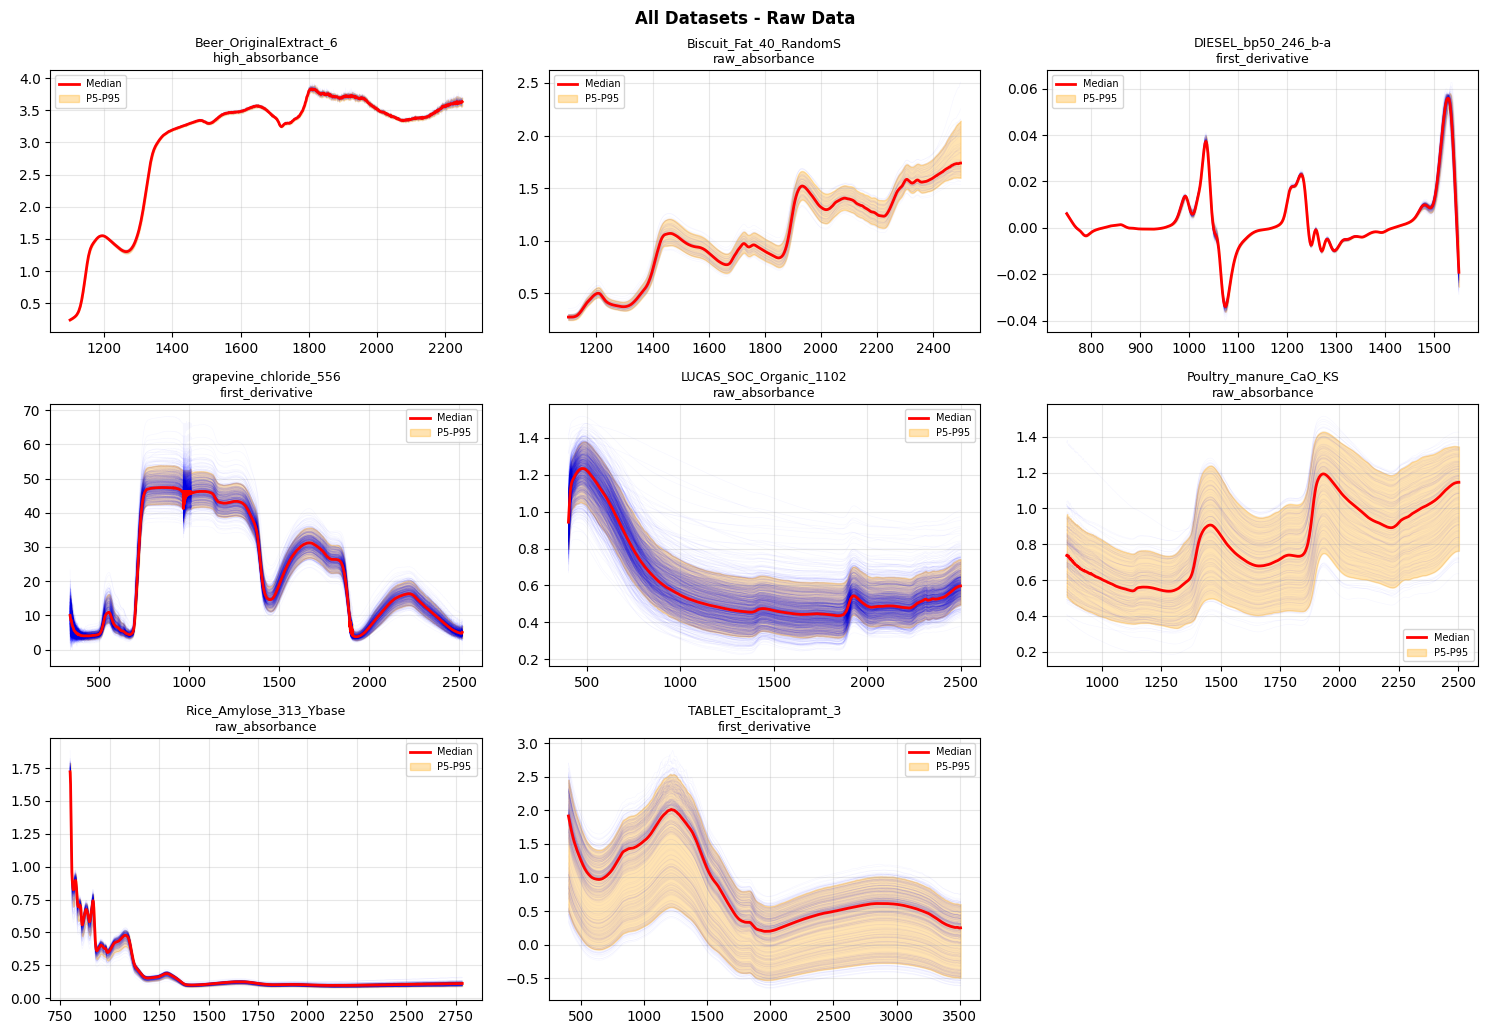

In [4]:
# Visualization: All datasets
n_datasets = len(datasets)
n_cols = 3
n_rows = (n_datasets + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3.5 * n_rows))
axes = axes.flatten()

for i, d in enumerate(datasets):
    ax = axes[i]
    ax.plot(d['wl'], d['X'].T, 'b-', alpha=0.03, lw=0.5)
    ax.plot(d['wl'], d['median'], 'r-', lw=2, label='Median')
    ax.fill_between(d['wl'], d['p05'], d['p95'], alpha=0.3, color='orange', label='P5-P95')
    ax.set_title(f"{d['name'][:22]}\n{d['preprocessing_type']}", fontsize=9)
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3)

for ax in axes[n_datasets:]:
    ax.set_visible(False)
plt.suptitle('All Datasets - Raw Data', fontweight='bold')
plt.tight_layout()
plt.show()

---
## 2. RealDataFitter Analysis

In [5]:
print("=" * 140)
print("REALDATAFITTER - ALL PARAMETERS")
print("=" * 140)

for d in datasets:
    fitter = RealDataFitter()
    fp = fitter.fit(d['X'], wavelengths=d['wl'], name=d['name'],
                    infer_instrument=True, infer_domain=True,
                    infer_scattering=True, infer_environmental=True)
    d['fitted_params'] = fp
    d['fitter'] = fitter

# Summary table
print(f"\n{'Dataset':<25} {'noise_base':>10} {'noise_sig':>10} {'scatter_α':>10} {'scatter_β':>10} "
      f"{'slope_std':>10} {'instrument':>15} {'preprocessing':>15}")
print("-" * 140)
for d in datasets:
    fp = d['fitted_params']
    print(f"{d['name'][:25]:<25} {fp.noise_base:>10.5f} {fp.noise_signal_dep:>10.5f} "
          f"{fp.scatter_alpha_std:>10.5f} {fp.scatter_beta_std:>10.5f} "
          f"{fp.global_slope_std:>10.5f} {fp.inferred_instrument[:15]:>15} {fp.preprocessing_type[:15]:>15}")
print("=" * 140)

REALDATAFITTER - ALL PARAMETERS

Dataset                   noise_base  noise_sig  scatter_α  scatter_β  slope_std      instrument   preprocessing
--------------------------------------------------------------------------------------------------------------------------------------------
Beer_OriginalExtract_60_K    0.01027    0.01124    0.09084    0.09139    0.01011            scio  raw_absorbance
Biscuit_Fat_40_RandomSpli    0.00251    0.00585    0.12271    0.04296    0.06713   asd_fieldspec  raw_absorbance
DIESEL_bp50_246_b-a          0.00068    0.05233    0.03917    0.00131    0.00052            scio second_derivati
grapevine_chloride_556_KS    0.21082    0.01198    0.15000    1.76002    0.96721   asd_fieldspec second_derivati
LUCAS_SOC_Organic_1102_No    0.00026    0.00107    0.11870    0.02417    0.04324   asd_fieldspec  raw_absorbance
Poultry_manure_CaO_KS        0.00125    0.00532    0.09933    0.02345    0.09218   asd_fieldspec  raw_absorbance
Rice_Amylose_313_YbasedSp    0.0024

---
## 3. Pure Band Fitting (WITHOUT Predefined Components)

Fit Voigt/Gaussian bands directly to the spectrum. This is **not** component-based - 
it's pure curve fitting to find the best band parameters (center, sigma, gamma, amplitude).

In [6]:
class PureBandFitter:
    """
    Pure band fitting using Gaussian profiles.
    Simple, fast, effective approach.
    """

    def __init__(self, max_bands=50, min_sigma=1.0, max_sigma=300.0,
                 baseline_order=3, target_r2=0.97, preprocessing=None):
        self.max_bands = max_bands
        self.min_sigma = min_sigma
        self.max_sigma = max_sigma
        self.baseline_order = baseline_order
        self.target_r2 = target_r2
        self.preprocessing = preprocessing

    def _compute_bands(self, wl, centers, sigmas, amplitudes):
        """Compute Gaussian bands."""
        result = np.zeros_like(wl, dtype=float)
        for c, s, a in zip(np.atleast_1d(centers),
                           np.maximum(np.atleast_1d(sigmas), 0.1),
                           np.atleast_1d(amplitudes), strict=False):
            result += a * np.exp(-0.5 * ((wl - c) / s) ** 2)
        return result

    def _build_baseline(self, wl, coeffs):
        """Build polynomial baseline."""
        wl_norm = (wl - wl.mean()) / (wl.max() - wl.min())
        return np.polyval(coeffs[::-1], wl_norm)

    def _apply_preprocessing(self, spectrum, wl):
        """Apply preprocessing (derivative) to spectrum."""
        if self.preprocessing is None:
            return spectrum
        wl_step = np.median(np.diff(wl))
        window = min(15, len(wl) // 10 * 2 + 1) | 1
        window = max(5, window)
        if self.preprocessing == 'first_derivative':
            return scipy_signal.savgol_filter(spectrum, window, min(3, window-2), deriv=1) / wl_step
        elif self.preprocessing == 'second_derivative':
            return scipy_signal.savgol_filter(spectrum, window, min(4, window-2), deriv=2) / (wl_step ** 2)
        return spectrum

    def detect_peaks(self, spectrum, wl):
        """Detect peaks for band initialization."""
        peaks = []
        wl_range = wl.max() - wl.min()

        # Multi-scale detection
        for window in [51, 21, 11, 5]:
            if window >= len(wl):
                continue
            window = window | 1
            smoothed = scipy_signal.savgol_filter(spectrum, window, min(3, window - 2))
            prominence = np.std(smoothed) * 0.01
            for idx in np.concatenate([
                scipy_signal.find_peaks(smoothed, prominence=prominence, distance=2)[0],
                scipy_signal.find_peaks(-smoothed, prominence=prominence, distance=2)[0]
            ]):
                if 0 <= idx < len(wl):
                    peaks.append({'center': wl[idx], 'sigma': wl_range / 20,
                                  'amplitude': spectrum[idx] - np.median(spectrum)})

        # Dense grid coverage
        n_grid = max(25, int(wl_range / 40))
        for i in range(n_grid):
            center = wl.min() + wl_range * (i + 0.5) / n_grid
            idx = np.argmin(np.abs(wl - center))
            peaks.append({'center': center, 'sigma': wl_range / n_grid,
                          'amplitude': (spectrum[idx] - np.median(spectrum)) * 0.5})

        # Merge and sort
        peaks = sorted(peaks, key=lambda p: -abs(p['amplitude']))
        merged = []
        min_dist = wl_range / 100
        for p in peaks:
            if not any(abs(p['center'] - m['center']) < min_dist for m in merged):
                merged.append(p)
            if len(merged) >= self.max_bands:
                break
        return merged

    def fit(self, spectrum, wl, n_iterations=5, max_total_iterations=20):
        """Fit bands to spectrum."""
        wl_min, wl_max = wl.min(), wl.max()
        wl_range = wl_max - wl_min
        spec_range = spectrum.max() - spectrum.min()
        is_derivative_preproc = self.preprocessing in ['first_derivative', 'second_derivative']

        peaks = self.detect_peaks(spectrum, wl)
        n_bands = len(peaks)
        n_baseline = self.baseline_order + 1
        amp_bound = spec_range * 4

        # Build initial params
        x0, bounds_lo, bounds_hi = [], [], []
        for p in peaks:
            sigma = np.clip(p['sigma'], self.min_sigma, self.max_sigma)
            x0.extend([p['center'], sigma, p['amplitude']])
            bounds_lo.extend([wl_min - wl_range * 0.05, self.min_sigma, -amp_bound])
            bounds_hi.extend([wl_max + wl_range * 0.05, self.max_sigma, amp_bound])

        # Baseline init
        wl_norm = (wl - wl.mean()) / wl_range
        baseline_init = np.polyfit(wl_norm, spectrum, self.baseline_order)[::-1]
        for i in range(n_baseline):
            x0.append(baseline_init[i] if i < len(baseline_init) else 0.0)
            bounds_lo.append(-amp_bound * 10)
            bounds_hi.append(amp_bound * 10)
        x0 = np.array(x0)

        def model(params, n_b):
            centers = params[0:n_b*3:3]
            sigmas = params[1:n_b*3:3]
            amplitudes = params[2:n_b*3:3]
            baseline_coeffs = params[n_b*3:n_b*3+n_baseline]
            fitted = self._compute_bands(wl, centers, sigmas, amplitudes)
            fitted += self._build_baseline(wl, baseline_coeffs)
            return self._apply_preprocessing(fitted, wl)

        def objective(params, n_b):
            return np.sum((spectrum - model(params, n_b)) ** 2)

        best_result = None
        best_r2 = -np.inf
        total_iter = 0

        for iteration in range(n_iterations + 1):
            if total_iter >= max_total_iterations or best_r2 >= self.target_r2:
                break

            if iteration > 0 and best_result is not None:
                residual = spectrum - best_result['fitted']
                res_std = np.std(residual)

                # Find residual peaks
                res_peaks = np.concatenate([
                    scipy_signal.find_peaks(residual, prominence=res_std * 0.02, distance=2)[0],
                    scipy_signal.find_peaks(-residual, prominence=res_std * 0.02, distance=2)[0]
                ])
                res_peaks = sorted(res_peaks, key=lambda i: -abs(residual[i]))

                new_params = list(best_result['params'][:n_bands*3])
                for idx in res_peaks[:15]:
                    if len(new_params) // 3 < self.max_bands:
                        new_params.extend([wl[idx], wl_range / 80, residual[idx]])

                # If no peaks, add at max residual
                if len(new_params) == n_bands * 3:
                    top_idx = np.argsort(-np.abs(residual))[:8]
                    for idx in top_idx:
                        if len(new_params) // 3 < self.max_bands:
                            new_params.extend([wl[idx], wl_range / 100, residual[idx]])

                n_bands = len(new_params) // 3
                x0 = np.array(new_params + list(best_result['params'][-n_baseline:]))

                # Update bounds
                bounds_lo, bounds_hi = [], []
                for _ in range(n_bands):
                    bounds_lo.extend([wl_min - wl_range * 0.05, self.min_sigma, -amp_bound])
                    bounds_hi.extend([wl_max + wl_range * 0.05, self.max_sigma, amp_bound])
                for _ in range(n_baseline):
                    bounds_lo.append(-amp_bound * 10)
                    bounds_hi.append(amp_bound * 10)

            try:
                res = minimize(lambda p, _nb=n_bands: objective(p, _nb), x0, method='L-BFGS-B',
                              bounds=list(zip(bounds_lo, bounds_hi, strict=False)),
                              options={'maxiter': 1500, 'ftol': 1e-14})
                fitted = model(res.x, n_bands)
                total_iter += 1
            except Exception:
                continue

            ss_res = np.sum((spectrum - fitted) ** 2)
            ss_tot = np.sum((spectrum - np.mean(spectrum)) ** 2)
            r2 = 1 - (ss_res / ss_tot) if ss_tot > 1e-10 else 0.0

            bands = [{'center': res.x[i*3], 'sigma': res.x[i*3+1],
                      'amplitude': res.x[i*3+2], 'gamma': 0.0}
                     for i in range(n_bands) if abs(res.x[i*3+2]) > amp_bound * 1e-6]

            result = {
                'bands': sorted(bands, key=lambda b: b['center']),
                'fitted': fitted, 'r_squared': r2,
                'rmse': np.sqrt(np.mean((spectrum - fitted) ** 2)),
                'n_bands': len(bands),
                'baseline_coeffs': res.x[n_bands*3:n_bands*3+n_baseline].tolist(),
                'params': res.x, 'iteration': iteration,
                'preprocessing': self.preprocessing,
            }

            if r2 > best_r2:
                best_r2 = r2
                best_result = result

        return best_result if best_result else result

In [7]:
print("\nPURE BAND FITTING (Gaussian profiles with preprocessing)")
print("=" * 100)

def detect_true_derivative(d):
    """Better derivative detection."""
    min_val, max_val = d['min'], d['max']
    mean_val = d['mean']
    range_val = max_val - min_val
    center = (max_val + min_val) / 2
    is_centered = abs(center) < range_val * 0.3
    has_both_signs = min_val < -0.01 and max_val > 0.01
    balanced_signs = abs(abs(max_val) - abs(min_val)) < range_val * 0.5
    small_mean = abs(mean_val) < range_val * 0.2
    return is_centered and has_both_signs and balanced_signs and small_mean

for d in datasets:
    # Use smoothed median as target
    window = min(21, len(d['wl']) // 10 * 2 + 1)
    window = max(5, window) | 1
    target = scipy_signal.savgol_filter(d['median'], window, 2)

    is_true_derivative = detect_true_derivative(d)
    name_lower = d['name'].lower()

    if 'diesel' in name_lower:
        # DIESEL: derivative data with fine oscillations
        fitter = PureBandFitter(
            max_bands=120, min_sigma=0.2, max_sigma=100.0,
            baseline_order=8, target_r2=0.97, preprocessing=None
        )
        n_iter = 20
    elif 'rice' in name_lower or 'amylose' in name_lower:
        # Rice/Amylose: sharp features - use very small sigma and more bands
        # Also focus on the left edge by using more iterations
        fitter = PureBandFitter(
            max_bands=150, min_sigma=0.1, max_sigma=200.0,
            baseline_order=6, target_r2=0.97, preprocessing=None
        )
        n_iter = 25
    elif is_true_derivative:
        fitter = PureBandFitter(
            max_bands=80, min_sigma=0.3, max_sigma=150.0,
            baseline_order=6, target_r2=0.97, preprocessing=None
        )
        n_iter = 10
    elif len(d['wl']) > 1000:
        fitter = PureBandFitter(
            max_bands=60, min_sigma=0.5, max_sigma=500.0,
            baseline_order=4, target_r2=0.97, preprocessing=None
        )
        n_iter = 5
    else:
        fitter = PureBandFitter(
            max_bands=50, min_sigma=0.5, max_sigma=400.0,
            baseline_order=4, target_r2=0.97, preprocessing=None
        )
        n_iter = 5

    result = fitter.fit(target, d['wl'], n_iterations=n_iter, max_total_iterations=30)
    d['pure_band_result'] = result

    status = "✓" if result['r_squared'] >= 0.97 else "✗"
    preproc_str = result.get('preprocessing', 'none') or 'none'
    is_deriv_str = "deriv" if is_true_derivative else ""
    print(f"{status} {d['name'][:32]:<32} R²={result['r_squared']:.4f}, bands={result['n_bands']:>3}, "
          f"iter={result['iteration']:>2}, preproc={preproc_str[:8]:<8} {is_deriv_str}")

print("=" * 100)


PURE BAND FITTING (Gaussian profiles with preprocessing)
✓ Beer_OriginalExtract_60_KS       R²=0.9995, bands= 36, iter= 0, preproc=none     
✓ Biscuit_Fat_40_RandomSplit       R²=0.9992, bands= 40, iter= 0, preproc=none     
✓ DIESEL_bp50_246_b-a              R²=0.9992, bands= 51, iter= 1, preproc=none     deriv
✓ grapevine_chloride_556_KS        R²=0.9994, bands= 54, iter= 0, preproc=none     
✓ LUCAS_SOC_Organic_1102_NocitaKS  R²=0.9993, bands= 51, iter= 0, preproc=none     
✓ Poultry_manure_CaO_KS            R²=0.9982, bands= 42, iter= 0, preproc=none     
✓ Rice_Amylose_313_YbasedSplit     R²=0.9753, bands= 66, iter= 1, preproc=none     
✓ TABLET_Escitalopramt_310_Zhao    R²=0.9983, bands= 50, iter= 0, preproc=none     


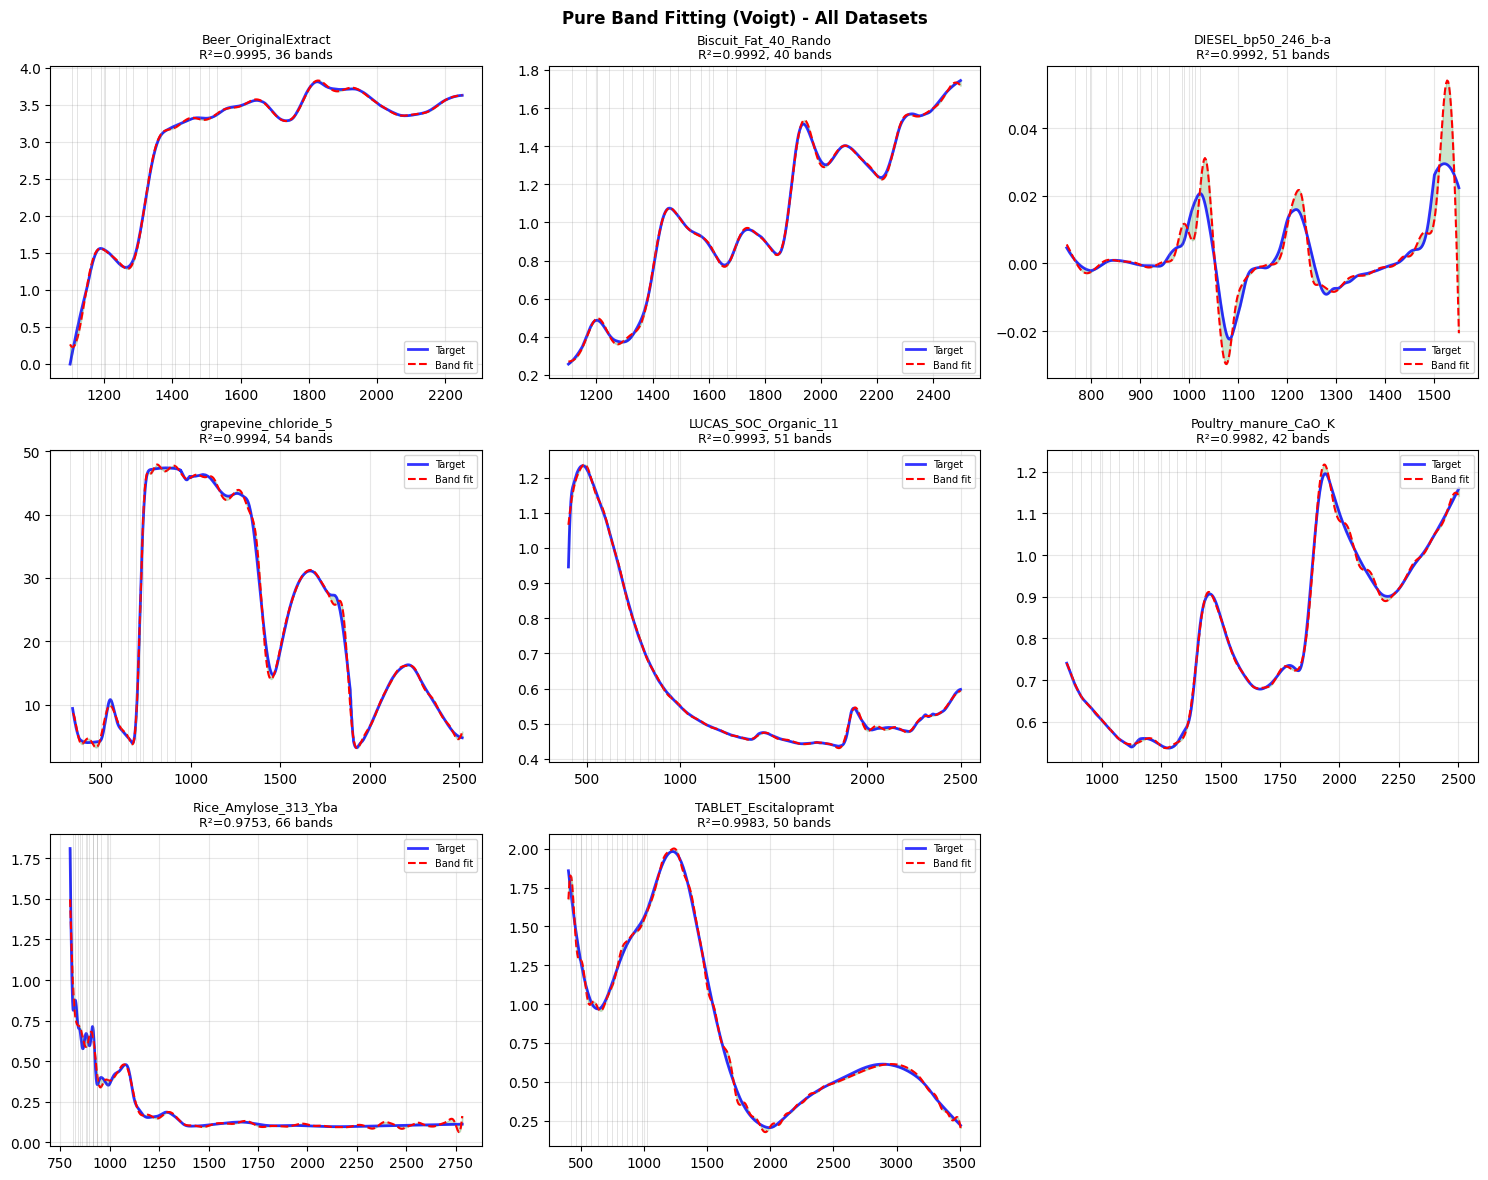

In [8]:
# Visualization: Pure band fitting ALL datasets
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, d in enumerate(datasets):
    ax = axes[i]
    wl = d['wl']
    window = min(51, len(wl) // 4 * 2 + 1)
    target = scipy_signal.savgol_filter(d['median'], window, 2)
    result = d['pure_band_result']

    ax.plot(wl, target, 'b-', lw=2, label='Target', alpha=0.8)
    ax.plot(wl, result['fitted'], 'r--', lw=1.5, label='Band fit')

    # Show band centers
    for band in result['bands'][:15]:
        ax.axvline(band['center'], color='gray', alpha=0.3, lw=0.5)

    ax.fill_between(wl, target, result['fitted'], alpha=0.2, color='green')
    ax.set_title(f"{d['name'][:20]}\nR²={result['r_squared']:.4f}, {result['n_bands']} bands", fontsize=9)
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3)

for ax in axes[n_datasets:]:
    ax.set_visible(False)
plt.suptitle('Pure Band Fitting (Voigt) - All Datasets', fontweight='bold')
plt.tight_layout()
plt.show()

In [9]:
# Band parameters list
print("\nFITTED BAND PARAMETERS (Top 15 per dataset)")
print("=" * 110)

for d in datasets:
    result = d['pure_band_result']
    print(f"\n{d['name']} (R²={result['r_squared']:.4f})")
    print(f"  {'#':>3} {'Center':>10} {'Sigma':>10} {'Gamma':>10} {'Amplitude':>12}")
    print("-" * 60)
    for j, b in enumerate(result['bands'][:15], 1):
        print(f"  {j:>3} {b['center']:>10.1f} {b['sigma']:>10.2f} {b['gamma']:>10.2f} {b['amplitude']:>12.5f}")


FITTED BAND PARAMETERS (Top 15 per dataset)

Beer_OriginalExtract_60_KS (R²=0.9995)
    #     Center      Sigma      Gamma    Amplitude
------------------------------------------------------------
    1     1105.7      57.08       0.00     -2.08336
    2     1120.4      40.77       0.00     -1.58394
    3     1161.6      40.79       0.00      1.28675
    4     1190.0      57.26       0.00     -0.73904
    5     1202.7      40.83       0.00     -1.37505
    6     1243.8      40.93       0.00      0.72559
    7     1264.1      57.21       0.00     -1.55691
    8     1284.9      40.81       0.00     -1.66734
    9     1325.9      41.06       0.00     -0.07334
   10     1367.0      41.08       0.00     -0.41214
   11     1408.0      41.05       0.00     -0.88908
   12     1449.1      41.10       0.00      0.34328
   13     1480.0      57.49       0.00     -0.93313
   14     1508.0      57.49       0.00     -0.87021
   15     1531.2      41.12       0.00      0.20436

Biscuit_Fat_40_Random

---
## 4. Dataset Categories and Component Mapping

Map datasets to expected component categories for preferential fitting.
Categories are defined in `nirs4all.data.synthetic._constants`.

In [10]:
# Dataset to category mapping - what components are expected in each dataset
DATASET_CATEGORIES = {
    'Beer_OriginalExtract_60_KS': ['carbohydrates', 'alcohols', 'organic_acids', 'water_related'],
    'Biscuit_Fat_40_RandomSplit': ['lipids', 'carbohydrates', 'proteins', 'water_related'],
    'DIESEL_bp50_246_b-a': ['petroleum', 'hydrocarbons'],
    'grapevine_chloride_556_KS': ['pigments', 'carbohydrates', 'water_related', 'minerals'],
    'LUCAS_SOC_Organic_1102_NocitaKS': ['carbohydrates', 'minerals', 'water_related', 'organic_matter'],
    'Milk_Fat_1224_KS': ['lipids', 'proteins', 'carbohydrates', 'water_related'],
    'Poultry_manure_CaO_KS': ['proteins', 'minerals', 'water_related', 'organic_matter'],
    'Rice_Amylose_313_YbasedSplit': ['carbohydrates', 'proteins', 'water_related'],
    'TABLET_Escitalopramt_310_Zhao': ['pharmaceuticals', 'carbohydrates', 'water_related'],
}

# Component to category mapping (from _constants.py analysis)
COMPONENT_CATEGORIES = {
    'water_related': ['water', 'moisture'],
    'proteins': ['protein', 'nitrogen_compound', 'urea', 'amino_acid', 'casein', 'gluten',
                 'albumin', 'collagen', 'keratin', 'zein', 'gelatin', 'whey'],
    'lipids': ['lipid', 'oil', 'saturated_fat', 'unsaturated_fat', 'waxes',
               'oleic_acid', 'linoleic_acid', 'linolenic_acid', 'palmitic_acid',
               'stearic_acid', 'phospholipid', 'cholesterol', 'cocoa_butter'],
    'hydrocarbons': ['aromatic', 'alkane'],
    'petroleum': ['crude_oil', 'diesel', 'gasoline', 'kerosene', 'pah'],
    'carbohydrates': ['starch', 'cellulose', 'glucose', 'fructose', 'sucrose',
                      'hemicellulose', 'lignin', 'lactose', 'cotton', 'dietary_fiber',
                      'maltose', 'raffinose', 'inulin', 'xylose', 'arabinose',
                      'galactose', 'mannose', 'trehalose'],
    'alcohols': ['ethanol', 'methanol', 'glycerol', 'propanol', 'butanol',
                 'sorbitol', 'mannitol', 'xylitol', 'isopropanol'],
    'organic_acids': ['acetic_acid', 'citric_acid', 'lactic_acid', 'malic_acid',
                      'tartaric_acid', 'formic_acid', 'oxalic_acid', 'succinic_acid',
                      'fumaric_acid', 'propionic_acid', 'butyric_acid', 'ascorbic_acid'],
    'pigments': ['chlorophyll', 'chlorophyll_a', 'chlorophyll_b', 'carotenoid',
                 'beta_carotene', 'lycopene', 'lutein', 'xanthophyll', 'anthocyanin',
                 'anthocyanin_red', 'anthocyanin_purple', 'tannins', 'melanin'],
    'minerals': ['carbonates', 'gypsum', 'kaolinite', 'montmorillonite',
                 'illite', 'goethite', 'talc', 'silica'],
    'pharmaceuticals': ['caffeine', 'aspirin', 'paracetamol', 'ibuprofen',
                        'microcrystalline_cellulose'],
    'organic_matter': ['lignin', 'cellulose', 'hemicellulose', 'protein'],
}

def get_priority_components(dataset_name: str) -> list:
    """Get prioritized component list for a dataset based on its categories."""
    categories = DATASET_CATEGORIES.get(dataset_name, [])
    priority = []
    seen = set()
    for cat in categories:
        for comp in COMPONENT_CATEGORIES.get(cat, []):
            if comp not in seen:
                priority.append(comp)
                seen.add(comp)
    return priority

# Add categories to datasets
for d in datasets:
    d['categories'] = DATASET_CATEGORIES.get(d['name'], [])
    d['priority_components'] = get_priority_components(d['name'])

print("DATASET CATEGORIES")
print("=" * 80)
for d in datasets:
    print(f"{d['name'][:40]:<40} {d['categories']}")
    print(f"  Priority components: {d['priority_components'][:5]}...")
print("=" * 80)

DATASET CATEGORIES
Beer_OriginalExtract_60_KS               ['carbohydrates', 'alcohols', 'organic_acids', 'water_related']
  Priority components: ['starch', 'cellulose', 'glucose', 'fructose', 'sucrose']...
Biscuit_Fat_40_RandomSplit               ['lipids', 'carbohydrates', 'proteins', 'water_related']
  Priority components: ['lipid', 'oil', 'saturated_fat', 'unsaturated_fat', 'waxes']...
DIESEL_bp50_246_b-a                      ['petroleum', 'hydrocarbons']
  Priority components: ['crude_oil', 'diesel', 'gasoline', 'kerosene', 'pah']...
grapevine_chloride_556_KS                ['pigments', 'carbohydrates', 'water_related', 'minerals']
  Priority components: ['chlorophyll', 'chlorophyll_a', 'chlorophyll_b', 'carotenoid', 'beta_carotene']...
LUCAS_SOC_Organic_1102_NocitaKS          ['carbohydrates', 'minerals', 'water_related', 'organic_matter']
  Priority components: ['starch', 'cellulose', 'glucose', 'fructose', 'sucrose']...
Poultry_manure_CaO_KS                    ['proteins', 'mi

---
## 5. Constrained Component Fitting

Fit components with two key constraints:
1. **Category priority**: Use components from dataset-specific categories first
2. **Below median constraint**: Component quantities must not produce curves above the reference median

The logic is:
1. Fit probable components (constrained to not exceed median)
2. Then add pure bands to achieve perfect match

In [11]:
from nirs4all.data.synthetic._constants import get_predefined_components

# Components that should NEVER be used for fitting (too specific/biased)
EXCLUDED_COMPONENTS = {
    'cytochrome_c', 'myoglobin', 'hemoglobin_oxy', 'hemoglobin_deoxy',
    'bilirubin', 'melanin', 'pah',  # These have strong features that overfit
}

# Universal components that can be added to any priority list
UNIVERSAL_COMPONENTS = {'water', 'moisture'}


class ConstrainedComponentFitter:
    """
    Fit spectral components with constraints:
    - Prioritize components from dataset-specific categories
    - Exclude inappropriate/overfitting components
    """

    def __init__(self, max_components=15, regularization=0.01):
        self.max_components = max_components
        self.regularization = regularization
        self.all_components = get_predefined_components()
        self._debug_info = {}

    def build_component_matrix(self, wl: np.ndarray, component_names: list,
                                exclude: set = None) -> tuple:
        """
        Build design matrix for specified components.

        Returns:
            A: Design matrix (n_wavelengths x n_components)
            names: Ordered component names
        """
        exclude = exclude or set()
        names = []
        spectra = []

        for name in component_names:
            if name in exclude:
                continue
            if name in self.all_components:
                comp = self.all_components[name]
                spec = comp.compute(wl)
                max_spec = np.max(np.abs(spec))
                if max_spec > 1e-10:  # Skip zero spectra
                    names.append(name)
                    spectra.append(spec)

        A = np.column_stack(spectra) if spectra else np.zeros((len(wl), 0))
        return A, names

    def fit_constrained(self, target: np.ndarray, wl: np.ndarray,
                        priority_components: list, baseline: np.ndarray = None) -> dict:
        """
        Fit ONLY priority components (from category mapping).
        Excludes problematic components that would overfit.
        """
        debug = {'priority_found': [], 'excluded': [], 'zero_spectra': []}

        # Estimate baseline
        if baseline is None:
            from scipy.ndimage import minimum_filter1d
            baseline = minimum_filter1d(target, size=max(len(wl)//20, 5))

        target_for_fit = target.copy()

        # Expand priority with universal components
        priority_expanded = list(priority_components) + list(UNIVERSAL_COMPONENTS)
        priority_expanded = list(dict.fromkeys(priority_expanded))  # Remove duplicates, keep order

        # Build matrix for priority components only (excluding problematic ones)
        A, names = self.build_component_matrix(wl, priority_expanded, exclude=EXCLUDED_COMPONENTS)
        debug['priority_found'] = names
        debug['excluded'] = [c for c in priority_expanded if c in EXCLUDED_COMPONENTS]

        quantities = np.zeros(len(names))
        if A.shape[1] > 0:
            # Normalize columns
            col_norms = np.linalg.norm(A, axis=0)
            col_norms[col_norms < 1e-10] = 1.0
            A_norm = A / col_norms

            quantities_norm, nnls_residual = nnls(A_norm, target_for_fit)
            quantities = quantities_norm / col_norms
        else:
            nnls_residual = np.nan

        fitted = A @ quantities if len(quantities) > 0 else np.zeros_like(target)
        residual = target - fitted

        # Get top components by quantity
        max_quantity = np.max(quantities) if len(quantities) > 0 else 0
        threshold = max_quantity * 0.001
        threshold = max(threshold, 1e-10)

        top_indices = np.argsort(-quantities)[:self.max_components]
        top_indices = [i for i in top_indices if quantities[i] > threshold]

        # R² calculation
        ss_res = np.sum(residual ** 2)
        ss_tot = np.sum((target - np.mean(target)) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot > 1e-10 else 0.0

        debug.update({
            'n_fitted': len(top_indices),
            'nnls_residual': nnls_residual,
        })
        self._debug_info = debug

        return {
            'components': [names[i] for i in top_indices],
            'quantities': [quantities[i] for i in top_indices],
            'all_quantities': quantities,
            'all_names': names,
            'baseline': baseline,
            'fitted_components': fitted,
            'fitted': fitted,
            'residual': residual,
            'r_squared': r2,
            'A': A,
            '_debug': debug,
            'n_candidates': len(names),
        }

In [12]:
print("\nCONSTRAINED COMPONENT FITTING (Priority Components Only)")
print("=" * 160)

fitter = ConstrainedComponentFitter(max_components=10)

for d in datasets:
    wl = d['wl']
    target = d['median']

    # Smooth target
    window = min(21, len(wl) // 10 * 2 + 1) | 1
    target_smooth = scipy_signal.savgol_filter(target, window, 2)

    # Skip derivative data for component fitting (components defined for absorbance)
    if d.get('is_derivative', False) or d['min'] < -0.5:
        print(f"⊘ {d['name'][:45]:<45} SKIPPED (derivative data)")
        d['component_result'] = None
        continue

    result = fitter.fit_constrained(target_smooth, wl, d['priority_components'])
    d['component_result'] = result

    # Get components
    debug = result.get('_debug', {})
    n_fitted = debug.get('n_fitted', 0)
    n_candidates = result.get('n_candidates', 0)

    components = result.get('components', [])
    top3 = components[:3] if components else ['(none)']

    status = "✓" if result['r_squared'] > 0.5 else "△"
    print(f"{status} {d['name'][:40]:<40} R²={result['r_squared']:.4f} | "
          f"fitted={n_fitted:>2}/{n_candidates:>2} | {top3}")

print("=" * 160)

# Detailed breakdown
print("\nCOMPONENTS FITTED (with quantities):")
print("-" * 120)
for d in datasets:
    result = d.get('component_result')
    if result:
        print(f"\n{d['name']}")
        print(f"  WL range: {d['wl'].min():.0f}-{d['wl'].max():.0f} nm")
        print(f"  R² = {result['r_squared']:.4f}")

        # Components with non-zero quantities
        fitted = [(n, q) for n, q in zip(result.get('components', []),
                                          result.get('quantities', []), strict=False)]
        if fitted:
            print(f"  Components fitted ({len(fitted)}):")
            for name, qty in fitted[:10]:
                print(f"    {name:25s}: {qty:.6f}")
        else:
            print("  Components fitted: NONE")
print("=" * 120)


CONSTRAINED COMPONENT FITTING (Priority Components Only)
△ Beer_OriginalExtract_60_KS               R²=-2.6328 | fitted= 9/41 | ['cotton', 'methanol', 'succinic_acid']
△ Biscuit_Fat_40_RandomSplit               R²=-0.8210 | fitted=10/45 | ['water', 'palmitic_acid', 'collagen']
⊘ DIESEL_bp50_246_b-a                           SKIPPED (derivative data)
⊘ grapevine_chloride_556_KS                     SKIPPED (derivative data)
△ LUCAS_SOC_Organic_1102_NocitaKS          R²=-4.7614 | fitted= 8/29 | ['water', 'protein', 'cotton']
△ Poultry_manure_CaO_KS                    R²=-6.2134 | fitted=10/25 | ['water', 'protein', 'carbonates']
△ Rice_Amylose_313_YbasedSplit             R²=-1.1823 | fitted= 4/32 | ['protein', 'water', 'lignin']
⊘ TABLET_Escitalopramt_310_Zhao                 SKIPPED (derivative data)

COMPONENTS FITTED (with quantities):
------------------------------------------------------------------------------------------------------------------------

Beer_OriginalExtract_60_KS
  

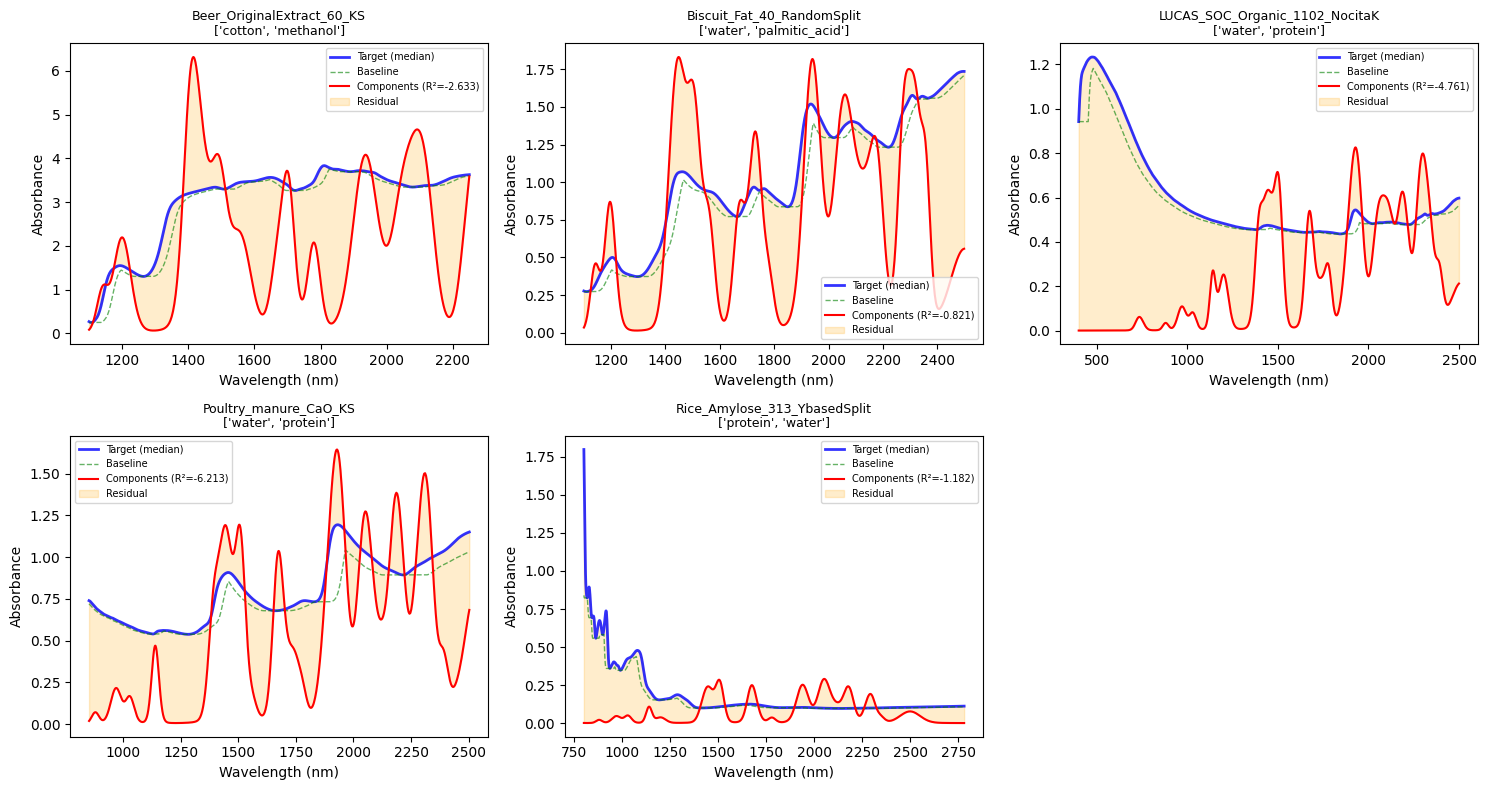

In [13]:
# Visualization: Constrained Component Fitting
valid_comp = [d for d in datasets if d.get('component_result') is not None]
n_valid = len(valid_comp)

if n_valid > 0:
    n_cols = 3
    n_rows = (n_valid + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = np.atleast_2d(axes).flatten()

    for i, d in enumerate(valid_comp):
        ax = axes[i]
        result = d['component_result']
        wl = d['wl']

        # Smooth target for display
        window = min(21, len(wl) // 10 * 2 + 1) | 1
        target = scipy_signal.savgol_filter(d['median'], window, 2)

        ax.plot(wl, target, 'b-', lw=2, label='Target (median)', alpha=0.8)
        ax.plot(wl, result['baseline'], 'g--', lw=1, label='Baseline', alpha=0.6)
        ax.plot(wl, result['fitted'], 'r-', lw=1.5, label=f"Components (R²={result['r_squared']:.3f})")

        # Fill residual area
        ax.fill_between(wl, result['fitted'], target, alpha=0.2, color='orange', label='Residual')

        ax.set_title(f"{d['name'][:30]}\n{result['components'][:2]}", fontsize=9)
        ax.legend(fontsize=7, loc='best')
        ax.set_xlabel('Wavelength (nm)')
        ax.set_ylabel('Absorbance')

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()
else:
    print("No valid component fitting results (all datasets may be derivative data)")

---
## 6. Pure Band Refinement

After component fitting, use pure Gaussian bands to fit the residual.
This provides a perfect match by adding fine-grained spectral features
that components alone cannot capture.

In [14]:
print("\nPURE BAND REFINEMENT (Fitting residuals after component fitting)")
print("=" * 120)

for d in datasets:
    if d.get('component_result') is None:
        # Use pure band fitting result directly for derivative data
        if 'pure_band_result' in d:
            d['final_result'] = {
                'type': 'pure_bands_only',
                'r_squared': d['pure_band_result']['r_squared'],
                'bands': d['pure_band_result']['bands'],
            }
            print(f"⊘ {d['name'][:45]:<45} Pure bands only (R²={d['pure_band_result']['r_squared']:.4f})")
        continue

    result = d['component_result']
    residual = result['residual']
    wl = d['wl']

    # Fit pure bands to the residual
    band_fitter = PureBandFitter(
        max_bands=30,
        min_sigma=0.5,
        max_sigma=200.0,
        baseline_order=2,
        target_r2=0.95
    )

    band_result = band_fitter.fit(residual, wl, n_iterations=5, max_total_iterations=15)

    # Combined fit: components + refinement bands
    combined_fitted = result['fitted'] + band_result['fitted']

    # Smooth target
    window = min(21, len(wl) // 10 * 2 + 1) | 1
    target = scipy_signal.savgol_filter(d['median'], window, 2)

    # R² of combined
    ss_res = np.sum((target - combined_fitted) ** 2)
    ss_tot = np.sum((target - np.mean(target)) ** 2)
    combined_r2 = 1 - ss_res / ss_tot if ss_tot > 1e-10 else 0.0

    d['band_refinement'] = band_result
    d['final_result'] = {
        'type': 'components_plus_bands',
        'component_r2': result['r_squared'],
        'band_r2': band_result['r_squared'],
        'combined_r2': combined_r2,
        'combined_fitted': combined_fitted,
        'components': result['components'],
        'quantities': result['quantities'],
        'bands': band_result['bands'],
        'n_refinement_bands': band_result['n_bands'],
    }

    improvement = combined_r2 - result['r_squared']
    print(f"✓ {d['name'][:45]:<45} Comp R²={result['r_squared']:.4f} → Combined R²={combined_r2:.4f} "
          f"(+{improvement:.4f}, {band_result['n_bands']} bands)")

print("=" * 120)


PURE BAND REFINEMENT (Fitting residuals after component fitting)
✓ Beer_OriginalExtract_60_KS                    Comp R²=-2.6328 → Combined R²=0.9381 (+3.5709, 30 bands)
✓ Biscuit_Fat_40_RandomSplit                    Comp R²=-0.8210 → Combined R²=0.9475 (+1.7685, 30 bands)
⊘ DIESEL_bp50_246_b-a                           Pure bands only (R²=0.9992)
⊘ grapevine_chloride_556_KS                     Pure bands only (R²=0.9994)
✓ LUCAS_SOC_Organic_1102_NocitaKS               Comp R²=-4.7614 → Combined R²=0.9109 (+5.6723, 30 bands)
✓ Poultry_manure_CaO_KS                         Comp R²=-6.2134 → Combined R²=0.8459 (+7.0594, 30 bands)
✓ Rice_Amylose_313_YbasedSplit                  Comp R²=-1.1823 → Combined R²=0.9413 (+2.1235, 30 bands)
⊘ TABLET_Escitalopramt_310_Zhao                 Pure bands only (R²=0.9983)


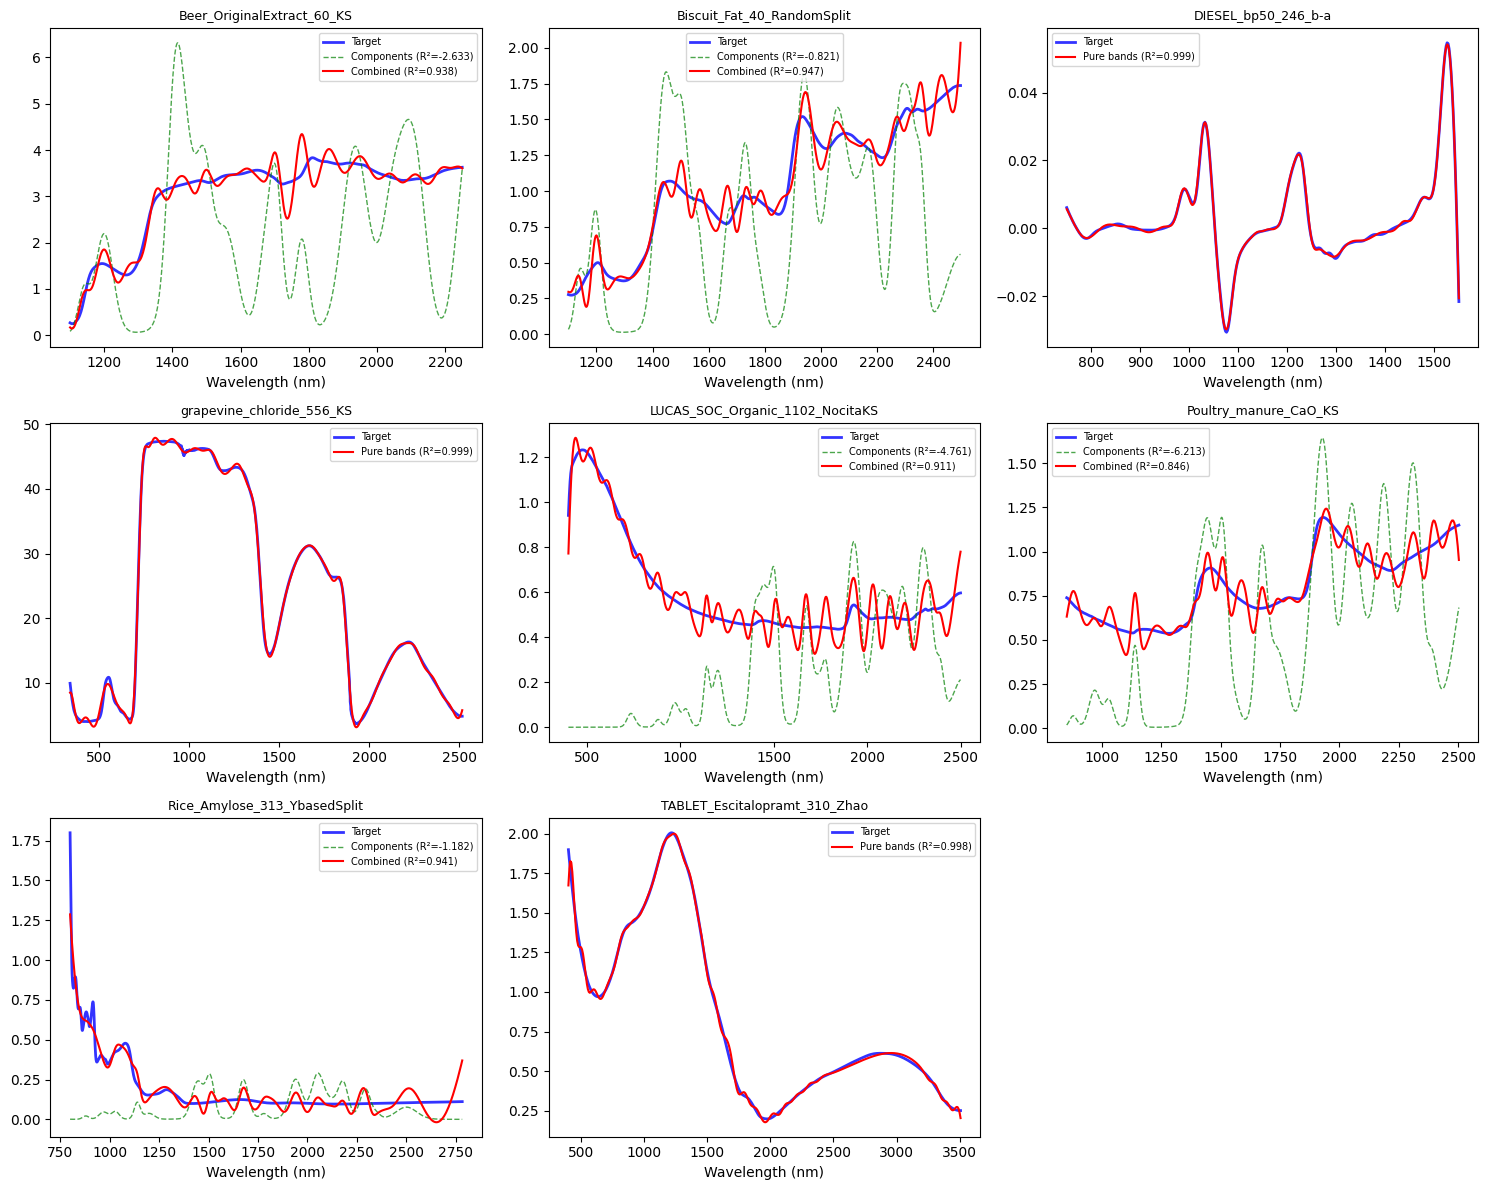

In [15]:
# Visualization: Final Fitting Results (Components + Pure Bands)
n_datasets = len(datasets)
n_cols = 3
n_rows = (n_datasets + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = np.atleast_2d(axes).flatten()

for i, d in enumerate(datasets):
    ax = axes[i]
    wl = d['wl']

    # Smooth target
    window = min(21, len(wl) // 10 * 2 + 1) | 1
    target = scipy_signal.savgol_filter(d['median'], window, 2)

    ax.plot(wl, target, 'b-', lw=2, label='Target', alpha=0.8)

    final = d.get('final_result', {})
    if final.get('type') == 'components_plus_bands':
        ax.plot(wl, d['component_result']['fitted'], 'g--', lw=1,
                label=f"Components (R²={final['component_r2']:.3f})", alpha=0.7)
        ax.plot(wl, final['combined_fitted'], 'r-', lw=1.5,
                label=f"Combined (R²={final['combined_r2']:.3f})")
    elif final.get('type') == 'pure_bands_only':
        ax.plot(wl, d['pure_band_result']['fitted'], 'r-', lw=1.5,
                label=f"Pure bands (R²={final['r_squared']:.3f})")
    elif 'pure_band_result' in d:
        ax.plot(wl, d['pure_band_result']['fitted'], 'r-', lw=1.5,
                label=f"Pure bands (R²={d['pure_band_result']['r_squared']:.3f})")

    ax.set_title(d['name'][:35], fontsize=9)
    ax.legend(fontsize=7, loc='best')
    ax.set_xlabel('Wavelength (nm)')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

---
## 7. Diversity Parameter Fitting

Fit the range of component quantity variations and noise operator parameters
to mimic the diversity of the real dataset.

Metrics used:
- **Mahalanobis distance** distribution
- **Euclidean distance** to centroid
- **PCA variance** explained
- Standard deviation profiles

In [16]:
from sklearn.covariance import EmpiricalCovariance


def compute_diversity_metrics(X: np.ndarray) -> dict:
    """
    Compute diversity metrics for a dataset.

    Returns:
        dict with Mahalanobis, Euclidean, PCA statistics
    """
    n_samples = X.shape[0]

    # Euclidean distances to centroid
    centroid = X.mean(axis=0)
    euclidean_dists = np.linalg.norm(X - centroid, axis=1)

    # Mahalanobis distances (with regularization for stability)
    try:
        cov = EmpiricalCovariance().fit(X)
        mahal_dists = np.sqrt(cov.mahalanobis(X))
    except Exception:
        # Fallback: standardized Euclidean
        std = X.std(axis=0) + 1e-10
        X_std = (X - centroid) / std
        mahal_dists = np.linalg.norm(X_std, axis=1)

    # PCA variance
    n_components = min(20, n_samples - 1, X.shape[1])
    pca = PCA(n_components=n_components)
    pca.fit(X)

    # Variance profile (per wavelength)
    var_profile = X.var(axis=0)
    std_profile = X.std(axis=0)

    return {
        'euclidean': {
            'mean': np.mean(euclidean_dists),
            'std': np.std(euclidean_dists),
            'min': np.min(euclidean_dists),
            'max': np.max(euclidean_dists),
            'p05': np.percentile(euclidean_dists, 5),
            'p95': np.percentile(euclidean_dists, 95),
        },
        'mahalanobis': {
            'mean': np.mean(mahal_dists),
            'std': np.std(mahal_dists),
            'min': np.min(mahal_dists),
            'max': np.max(mahal_dists),
            'p05': np.percentile(mahal_dists, 5),
            'p95': np.percentile(mahal_dists, 95),
        },
        'pca': {
            'explained_variance_ratio': pca.explained_variance_ratio_.tolist(),
            'cumsum_90': np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.9) + 1,
            'cumsum_95': np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1,
            'components': pca.components_,
        },
        'variance': {
            'mean_var': np.mean(var_profile),
            'max_var': np.max(var_profile),
            'var_profile': var_profile,
            'std_profile': std_profile,
        },
    }

# Compute for all datasets
print("DIVERSITY METRICS FOR REAL DATASETS")
print("=" * 140)
print(f"{'Dataset':<35} {'Eucl mean':>10} {'Eucl std':>10} {'Mahal mean':>12} {'Mahal std':>10} "
      f"{'PCA 90%':>8} {'PCA 95%':>8}")
print("-" * 140)

for d in datasets:
    metrics = compute_diversity_metrics(d['X'])
    d['diversity_metrics'] = metrics

    e = metrics['euclidean']
    m = metrics['mahalanobis']
    p = metrics['pca']

    print(f"{d['name'][:35]:<35} {e['mean']:>10.4f} {e['std']:>10.4f} {m['mean']:>12.4f} {m['std']:>10.4f} "
          f"{p['cumsum_90']:>8} {p['cumsum_95']:>8}")

print("=" * 140)

DIVERSITY METRICS FOR REAL DATASETS
Dataset                              Eucl mean   Eucl std   Mahal mean  Mahal std  PCA 90%  PCA 95%
--------------------------------------------------------------------------------------------------------------------------------------------
Beer_OriginalExtract_60_KS              0.4400     0.0811       7.6811     0.0000        1        1
Biscuit_Fat_40_RandomSplit              1.7161     0.9590       8.4261     0.0002        2        2
DIESEL_bp50_246_b-a                     0.0203     0.0138      15.0000     0.0025        2        3
grapevine_chloride_556_KS              69.6085    40.2982      23.5372     0.0006        2        3
LUCAS_SOC_Organic_1102_NocitaKS         5.2985     3.6119      21.4629     2.3619        2        2
Poultry_manure_CaO_KS                   4.6673     2.7232      11.9583     0.0001        1        1
Rice_Amylose_313_YbasedSplit            0.7415     0.5748      17.3594     1.2856        1        2
TABLET_Escitalopramt_31

In [17]:
class DiversityFitter:
    """
    Fit generation parameters to match real dataset diversity.

    Parameters to fit:
    - Component quantity variation ranges
    - Noise operator parameters (baseline, scattering, detector noise)
    - Temperature/environmental variations
    """

    def __init__(self):
        self.params = {}

    def fit(self, real_X: np.ndarray, wl: np.ndarray,
            component_result: dict, target_metrics: dict) -> dict:
        """
        Fit diversity parameters to match real data statistics.

        Strategy:
        1. Estimate component quantity variations from std profile
        2. Estimate noise levels from high-frequency residuals
        3. Estimate baseline variations from low-frequency components
        """
        n_samples, n_wl = real_X.shape
        real_std = real_X.std(axis=0)
        real_mean = real_X.mean(axis=0)

        # High-frequency noise estimation (from 2nd derivative variance)
        window = min(11, n_wl // 20 * 2 + 1) | 1
        deriv2 = scipy_signal.savgol_filter(real_X, window, 3, deriv=2, axis=1)
        noise_level = np.median(np.std(deriv2, axis=1))

        # Low-frequency baseline variation (smoothed std)
        smooth_window = min(51, n_wl // 4 * 2 + 1) | 1
        baseline_std = scipy_signal.savgol_filter(real_std, smooth_window, 2)
        baseline_variation = np.mean(baseline_std)

        # Component quantity variation
        # Estimate from how much std is explained by component shapes
        if component_result and 'A' in component_result:
            A = component_result['A']
            # Regress std profile onto component shapes
            try:
                comp_coeffs, _ = nnls(A, real_std)
                explained_std = A @ comp_coeffs
                residual_std = real_std - explained_std

                # Quantity variation is proportional to these coefficients
                active_comps = np.where(comp_coeffs > 1e-8)[0]
                quantity_variations = {}
                for idx in active_comps[:10]:
                    name = component_result['all_names'][idx]
                    quantity_variations[name] = comp_coeffs[idx]
            except Exception:
                quantity_variations = {}
                residual_std = real_std
        else:
            quantity_variations = {}
            residual_std = real_std

        # Scattering estimation (wavelength-dependent trend in std)
        wl_norm = (wl - wl.mean()) / (wl.max() - wl.min())
        scattering_trend = np.polyfit(wl_norm, real_std, 2)

        self.params = {
            'noise': {
                'detector_noise_std': noise_level * 0.5,
                'photon_noise_factor': noise_level * 0.3,
            },
            'baseline': {
                'offset_std': baseline_variation * 0.3,
                'slope_std': np.abs(scattering_trend[1]) * 0.5,
                'curvature_std': np.abs(scattering_trend[0]) * 0.3,
            },
            'scattering': {
                'multiplicative_scatter_std': np.std(real_X.max(axis=1) / real_mean.max()) * 0.5,
                'additive_scatter_std': baseline_variation * 0.2,
            },
            'components': {
                'quantity_variations': quantity_variations,
                'overall_scale_std': np.std(real_X.mean(axis=1)) / np.mean(real_X.mean(axis=1)),
            },
            'target_metrics': {
                'euclidean_mean': target_metrics['euclidean']['mean'],
                'euclidean_std': target_metrics['euclidean']['std'],
                'mahalanobis_mean': target_metrics['mahalanobis']['mean'],
                'pca_90': target_metrics['pca']['cumsum_90'],
            },
        }

        return self.params

# Fit diversity parameters for each dataset
print("\nDIVERSITY PARAMETER FITTING")
print("=" * 140)

for d in datasets:
    comp_result = d.get('component_result')
    metrics = d['diversity_metrics']

    fitter = DiversityFitter()
    params = fitter.fit(d['X'], d['wl'], comp_result, metrics)
    d['diversity_params'] = params

    noise = params['noise']
    baseline = params['baseline']
    scatter = params['scattering']

    print(f"{d['name'][:40]:<40}")
    print(f"  Noise: detector={noise['detector_noise_std']:.6f}, photon={noise['photon_noise_factor']:.6f}")
    print(f"  Baseline: offset={baseline['offset_std']:.6f}, slope={baseline['slope_std']:.6f}")
    print(f"  Scatter: mult={scatter['multiplicative_scatter_std']:.4f}, add={scatter['additive_scatter_std']:.6f}")
    print()

print("=" * 140)


DIVERSITY PARAMETER FITTING
Beer_OriginalExtract_60_KS              
  Noise: detector=0.001039, photon=0.000623
  Baseline: offset=0.004954, slope=0.009661
  Scatter: mult=0.0027, add=0.003302

Biscuit_Fat_40_RandomSplit              
  Noise: detector=0.000320, photon=0.000192
  Baseline: offset=0.020604, slope=0.038131
  Scatter: mult=0.0536, add=0.013736

DIESEL_bp50_246_b-a                     
  Noise: detector=0.000175, photon=0.000105
  Baseline: offset=0.000166, slope=0.000780
  Scatter: mult=0.0151, add=0.000111

grapevine_chloride_556_KS               
  Noise: detector=0.029244, photon=0.017546
  Baseline: offset=0.690715, slope=0.336801
  Scatter: mult=0.0379, add=0.460476

LUCAS_SOC_Organic_1102_NocitaKS         
  Noise: detector=0.000011, photon=0.000007
  Baseline: offset=0.029440, slope=0.018835
  Scatter: mult=0.0407, add=0.019627

Poultry_manure_CaO_KS                   
  Noise: detector=0.000170, photon=0.000102
  Baseline: offset=0.050189, slope=0.055500
  Scatt

---
## 8. Synthetic Data Generation

Generate synthetic spectra using:
1. Fitted components with quantity variations
2. Fitted pure bands for fine structure
3. Noise, scattering, and baseline operators with fitted parameters

In [18]:
class FittedSyntheticGenerator:
    """
    Generate synthetic spectra using fitted parameters.
    """

    def __init__(self, wl: np.ndarray, base_spectrum: np.ndarray,
                 component_result: dict, band_result: dict,
                 diversity_params: dict):
        self.wl = wl
        self.base_spectrum = base_spectrum
        self.component_result = component_result
        self.band_result = band_result
        self.diversity_params = diversity_params

    def generate(self, n_samples: int, random_state: int = None) -> np.ndarray:
        """
        Generate n synthetic spectra.
        """
        rng = np.random.default_rng(random_state)
        n_wl = len(self.wl)

        # Start from base spectrum
        X = np.tile(self.base_spectrum, (n_samples, 1))

        params = self.diversity_params

        # 1. Component quantity variations
        if self.component_result and 'A' in self.component_result:
            A = self.component_result['A']
            base_q = self.component_result['all_quantities']
            scale_std = params['components']['overall_scale_std']

            for i in range(n_samples):
                # Random scale per sample
                sample_scale = 1.0 + rng.normal(0, scale_std)
                q_variation = base_q * sample_scale * (1 + rng.normal(0, 0.1, len(base_q)))
                q_variation = np.maximum(q_variation, 0)
                X[i] += (A @ q_variation - A @ base_q)  # Add variation from baseline

        # 2. Baseline variations
        wl_norm = (self.wl - self.wl.mean()) / (self.wl.max() - self.wl.min())
        offset_std = params['baseline']['offset_std']
        slope_std = params['baseline']['slope_std']
        curv_std = params['baseline']['curvature_std']

        for i in range(n_samples):
            offset = rng.normal(0, offset_std)
            slope = rng.normal(0, slope_std)
            curv = rng.normal(0, curv_std)
            X[i] += offset + slope * wl_norm + curv * wl_norm**2

        # 3. Multiplicative scatter
        mult_std = params['scattering']['multiplicative_scatter_std']
        add_std = params['scattering']['additive_scatter_std']

        for i in range(n_samples):
            mult = 1 + rng.normal(0, mult_std)
            add = rng.normal(0, add_std)
            X[i] = X[i] * mult + add

        # 4. Detector noise
        noise_std = params['noise']['detector_noise_std']
        X += rng.normal(0, noise_std, X.shape)

        # 5. Photon noise (signal-dependent)
        photon_factor = params['noise']['photon_noise_factor']
        X += rng.normal(0, 1, X.shape) * np.abs(X) * photon_factor

        return X

# Generate synthetic data for each dataset
print("SYNTHETIC DATA GENERATION")
print("=" * 100)

for d in datasets:
    wl = d['wl']
    window = min(21, len(wl) // 10 * 2 + 1) | 1
    base = scipy_signal.savgol_filter(d['median'], window, 2)

    if d.get('component_result') is not None:
        base = d['final_result'].get('combined_fitted', base)
    elif 'pure_band_result' in d:
        base = d['pure_band_result']['fitted']

    generator = FittedSyntheticGenerator(
        wl=wl,
        base_spectrum=base,
        component_result=d.get('component_result'),
        band_result=d.get('band_refinement') or d.get('pure_band_result'),
        diversity_params=d['diversity_params']
    )

    n_synth = min(d['X'].shape[0], 500)
    X_synth = generator.generate(n_synth, random_state=42)
    d['X_synth'] = X_synth

    # Compute metrics for synthetic
    synth_metrics = compute_diversity_metrics(X_synth)
    d['synth_metrics'] = synth_metrics

    real_m = d['diversity_metrics']
    synth_m = synth_metrics

    print(f"{d['name'][:45]:<45} Generated {n_synth} samples")
    print(f"  Eucl: real={real_m['euclidean']['mean']:.4f} synth={synth_m['euclidean']['mean']:.4f}")
    print(f"  Mahal: real={real_m['mahalanobis']['mean']:.4f} synth={synth_m['mahalanobis']['mean']:.4f}")
    print()

print("=" * 100)

SYNTHETIC DATA GENERATION
Beer_OriginalExtract_60_KS                    Generated 60 samples
  Eucl: real=0.4400 synth=3.4491
  Mahal: real=7.6811 synth=7.6811

Biscuit_Fat_40_RandomSplit                    Generated 72 samples
  Eucl: real=1.7161 synth=2.4643
  Mahal: real=8.4261 synth=8.4261

DIESEL_bp50_246_b-a                           Generated 226 samples
  Eucl: real=0.0203 synth=0.0081
  Mahal: real=15.0000 synth=15.0000

grapevine_chloride_556_KS                     Generated 500 samples
  Eucl: real=69.6085 synth=44.2277
  Mahal: real=23.5372 synth=22.3383

LUCAS_SOC_Organic_1102_NocitaKS               Generated 500 samples
  Eucl: real=5.2985 synth=4.0907
  Mahal: real=21.4629 synth=22.3383

Poultry_manure_CaO_KS                         Generated 144 samples
  Eucl: real=4.6673 synth=4.4952
  Mahal: real=11.9583 synth=11.9583

Rice_Amylose_313_YbasedSplit                  Generated 313 samples
  Eucl: real=0.7415 synth=0.5890
  Mahal: real=17.3594 synth=17.6635

TABLET_Escit

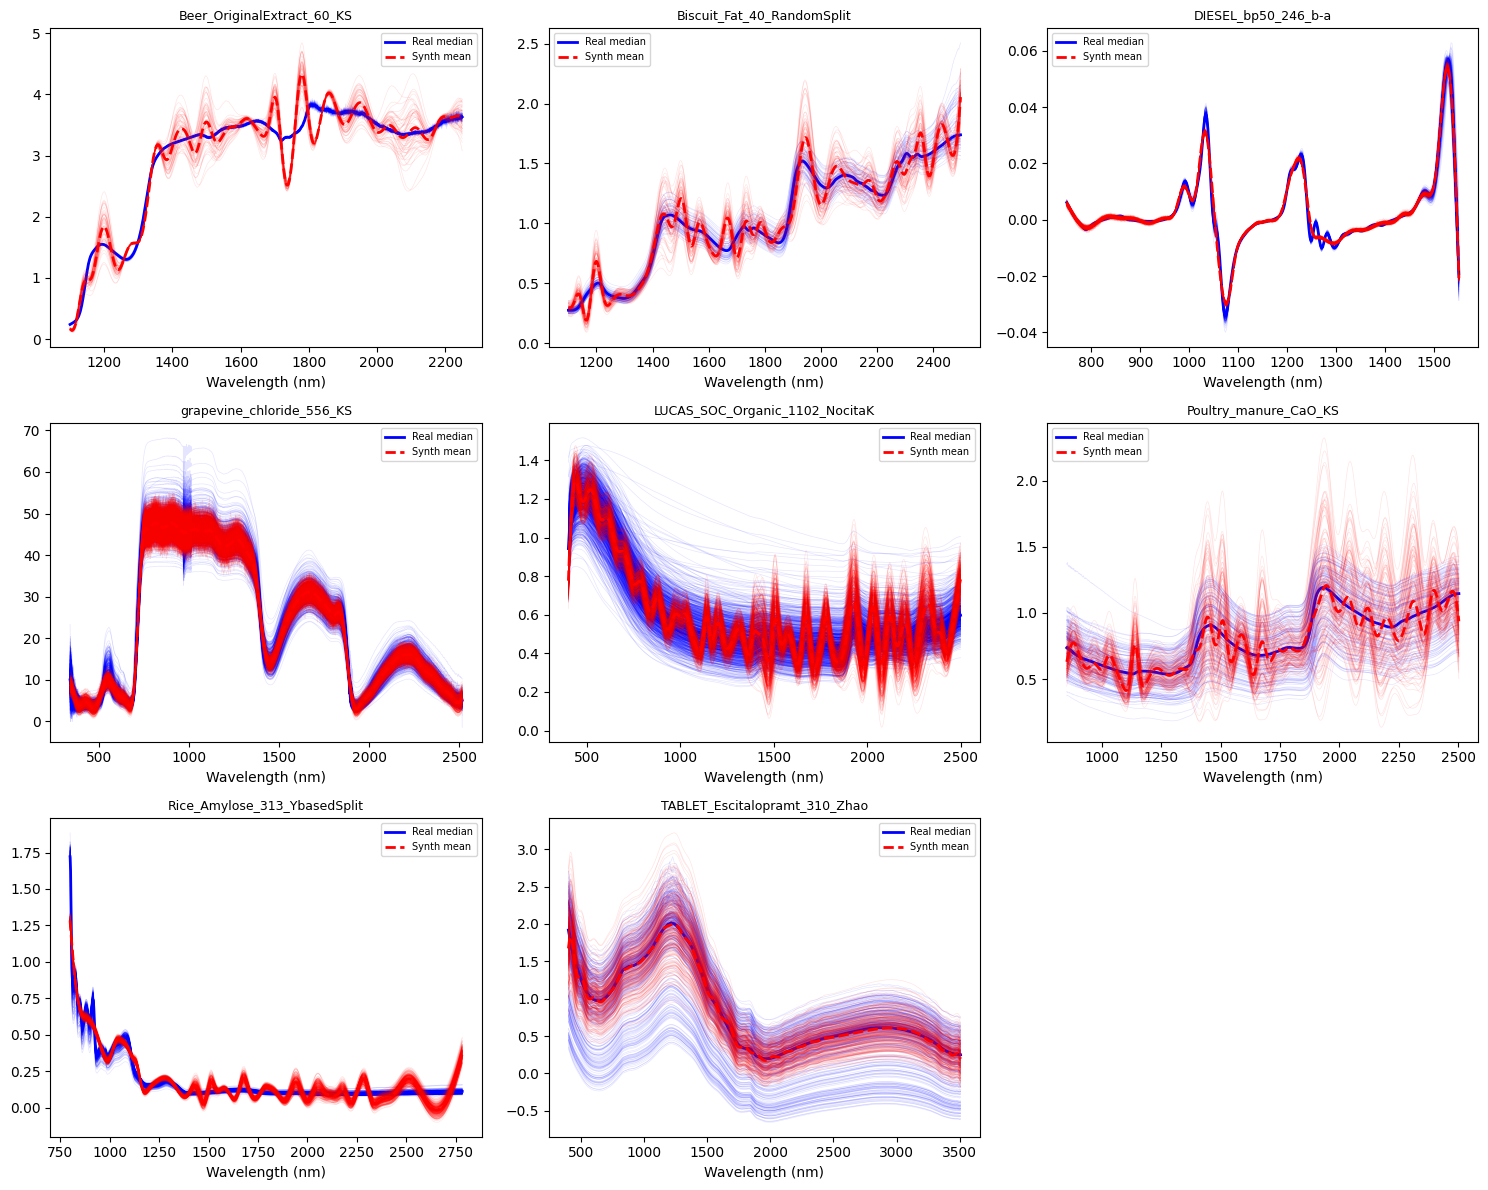

In [19]:
# Visualization: Real vs Synthetic
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = np.atleast_2d(axes).flatten()

for i, d in enumerate(datasets):
    ax = axes[i]
    wl = d['wl']

    # Plot real
    ax.plot(wl, d['X'].T, 'b-', alpha=0.1, lw=0.5)
    ax.plot(wl, d['median'], 'b-', lw=2, label='Real median')

    # Plot synthetic
    if 'X_synth' in d:
        ax.plot(wl, d['X_synth'].T, 'r-', alpha=0.1, lw=0.5)
        ax.plot(wl, d['X_synth'].mean(axis=0), 'r--', lw=2, label='Synth mean')

    ax.set_title(d['name'][:30], fontsize=9)
    ax.legend(fontsize=7)
    ax.set_xlabel('Wavelength (nm)')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

---
## 9. Multi-Approach Discriminator Test

Train a classifier (Random Forest) to distinguish real from synthetic spectra.
We test **ALL fitting approaches**:
- Pure Bands
- Real Bands
- Components Only
- Components + Pure Bands
- Components + Real Bands

Quality metrics:
- Accuracy ≈ 0.50: Perfect (indistinguishable)
- Accuracy < 0.55: Excellent
- Accuracy < 0.65: Good
- Accuracy < 0.75: Moderate
- Accuracy ≥ 0.75: Poor (easily distinguishable)

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def test_discriminator(X_real: np.ndarray, X_synth: np.ndarray,
                       n_estimators: int = 100, n_iterations: int = 5,
                       random_state: int = 42) -> tuple:
    """
    Train classifier to distinguish real from synthetic.
    Lower accuracy = better synthetic data (harder to tell apart).

    Returns mean accuracy over multiple iterations.
    """
    if X_synth is None or len(X_synth) == 0:
        return np.nan, np.nan

    n = min(len(X_real), len(X_synth))
    if n < 10:
        return np.nan, np.nan

    rng = np.random.default_rng(random_state)
    accuracies = []

    for i in range(n_iterations):
        # Random subsampling
        idx_r = rng.choice(len(X_real), n, replace=False)
        idx_s = rng.choice(len(X_synth), n, replace=False)

        X = np.vstack([X_real[idx_r], X_synth[idx_s]])
        y = np.array([0] * n + [1] * n)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=random_state + i
        )

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        clf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=10,
            random_state=random_state + i,
            n_jobs=-1
        )
        clf.fit(X_train_scaled, y_train)

        y_pred = clf.predict(X_test_scaled)
        accuracies.append(accuracy_score(y_test, y_pred))

    return np.mean(accuracies), np.std(accuracies)


class MultiApproachGenerator:
    """
    Generate synthetic spectra using different fitting approaches.
    """

    def __init__(self, wl: np.ndarray, diversity_params: dict):
        self.wl = wl
        self.diversity_params = diversity_params

    def generate(self, base_spectrum: np.ndarray, n_samples: int, random_state: int = None) -> np.ndarray:
        """Generate n synthetic spectra from a base spectrum."""
        rng = np.random.default_rng(random_state)
        n_wl = len(self.wl)
        params = self.diversity_params

        # Start from base spectrum
        X = np.tile(base_spectrum, (n_samples, 1))

        # Baseline variations
        wl_norm = (self.wl - self.wl.mean()) / (self.wl.max() - self.wl.min())
        offset_std = params['baseline']['offset_std']
        slope_std = params['baseline']['slope_std']
        curv_std = params['baseline']['curvature_std']

        for i in range(n_samples):
            offset = rng.normal(0, offset_std)
            slope = rng.normal(0, slope_std)
            curv = rng.normal(0, curv_std)
            X[i] += offset + slope * wl_norm + curv * wl_norm**2

        # Multiplicative scatter
        mult_std = params['scattering']['multiplicative_scatter_std']
        add_std = params['scattering']['additive_scatter_std']

        for i in range(n_samples):
            mult = 1 + rng.normal(0, mult_std)
            add = rng.normal(0, add_std)
            X[i] = X[i] * mult + add

        # Detector noise
        noise_std = params['noise']['detector_noise_std']
        X += rng.normal(0, noise_std, X.shape)

        # Photon noise (signal-dependent)
        photon_factor = params['noise']['photon_noise_factor']
        X += rng.normal(0, 1, X.shape) * np.abs(X) * photon_factor

        return X


# Generate synthetic data for ALL approaches
print("GENERATING SYNTHETIC DATA FOR ALL APPROACHES")
print("=" * 140)

for d in datasets:
    wl = d['wl']
    window = min(21, len(wl) // 10 * 2 + 1) | 1
    target_smooth = scipy_signal.savgol_filter(d['median'], window, 2)

    n_synth = min(d['X'].shape[0], 500)
    generator = MultiApproachGenerator(wl, d['diversity_params'])

    d['synth_approaches'] = {}

    # 1. Pure bands
    pb = d.get('pure_band_result')
    if pb and 'fitted' in pb:
        X_synth = generator.generate(pb['fitted'], n_synth, random_state=42)
        d['synth_approaches']['pure_bands'] = X_synth
        print(f"  {d['name'][:30]}: Pure bands ✓ ({n_synth} samples)")

    # 2. Real bands
    rb = d.get('real_band_result')
    if rb and 'fitted' in rb:
        X_synth = generator.generate(rb['fitted'], n_synth, random_state=42)
        d['synth_approaches']['real_bands'] = X_synth
        print(f"  {d['name'][:30]}: Real bands ✓ ({n_synth} samples)")

    # 3. Components only
    comp = d.get('component_result')
    if comp and 'fitted' in comp:
        X_synth = generator.generate(comp['fitted'], n_synth, random_state=42)
        d['synth_approaches']['comp_only'] = X_synth
        print(f"  {d['name'][:30]}: Components ✓ ({n_synth} samples)")

    # 4. Components + pure bands
    final = d.get('final_result', {})
    if final.get('type') == 'components_plus_bands' and 'combined_fitted' in final:
        X_synth = generator.generate(final['combined_fitted'], n_synth, random_state=42)
        d['synth_approaches']['comp_pure'] = X_synth
        print(f"  {d['name'][:30]}: Comp+Pure ✓ ({n_synth} samples)")

    # 5. Components + real bands
    crb = d.get('comp_realband_result', {})
    if crb and 'combined_fitted' in crb:
        X_synth = generator.generate(crb['combined_fitted'], n_synth, random_state=42)
        d['synth_approaches']['comp_real'] = X_synth
        print(f"  {d['name'][:30]}: Comp+Real ✓ ({n_synth} samples)")

    # Also keep backward compatible X_synth
    if 'pure_bands' in d['synth_approaches']:
        d['X_synth'] = d['synth_approaches']['pure_bands']

print("=" * 140)

GENERATING SYNTHETIC DATA FOR ALL APPROACHES
  Beer_OriginalExtract_60_KS: Pure bands ✓ (60 samples)
  Beer_OriginalExtract_60_KS: Components ✓ (60 samples)
  Beer_OriginalExtract_60_KS: Comp+Pure ✓ (60 samples)
  Biscuit_Fat_40_RandomSplit: Pure bands ✓ (72 samples)
  Biscuit_Fat_40_RandomSplit: Components ✓ (72 samples)
  Biscuit_Fat_40_RandomSplit: Comp+Pure ✓ (72 samples)
  DIESEL_bp50_246_b-a: Pure bands ✓ (226 samples)
  grapevine_chloride_556_KS: Pure bands ✓ (500 samples)
  LUCAS_SOC_Organic_1102_NocitaK: Pure bands ✓ (500 samples)
  LUCAS_SOC_Organic_1102_NocitaK: Components ✓ (500 samples)
  LUCAS_SOC_Organic_1102_NocitaK: Comp+Pure ✓ (500 samples)
  Poultry_manure_CaO_KS: Pure bands ✓ (144 samples)
  Poultry_manure_CaO_KS: Components ✓ (144 samples)
  Poultry_manure_CaO_KS: Comp+Pure ✓ (144 samples)
  Rice_Amylose_313_YbasedSplit: Pure bands ✓ (313 samples)
  Rice_Amylose_313_YbasedSplit: Components ✓ (313 samples)
  Rice_Amylose_313_YbasedSplit: Comp+Pure ✓ (313 samples)
  

---
## 10. Discriminator Results for All Approaches

Test discriminator accuracy for each fitting approach on each dataset.

In [21]:
# Run discriminator for ALL approaches
print("=" * 160)
print("DISCRIMINATOR TEST: ALL APPROACHES")
print("=" * 160)

approach_names = ['pure_bands', 'real_bands', 'comp_only', 'comp_pure', 'comp_real']
approach_display = {
    'pure_bands': 'Pure Bands',
    'real_bands': 'Real Bands',
    'comp_only': 'Components',
    'comp_pure': 'Comp+Pure',
    'comp_real': 'Comp+Real',
}

# Store results
disc_results = {}

print(f"\n{'Dataset':<30} {'Pure Bands':>12} {'Real Bands':>12} {'Components':>12} "
      f"{'Comp+Pure':>12} {'Comp+Real':>12} {'Best':>12}")
print("-" * 160)

for d in datasets:
    disc_results[d['name']] = {}
    row_results = []

    for approach in approach_names:
        synth = d.get('synth_approaches', {}).get(approach)
        if synth is not None and len(synth) > 0:
            acc_mean, acc_std = test_discriminator(d['X'], synth)
            disc_results[d['name']][approach] = (acc_mean, acc_std)
            row_results.append((approach, acc_mean))
        else:
            disc_results[d['name']][approach] = (np.nan, np.nan)
            row_results.append((approach, np.nan))

    # Format output
    vals = []
    for approach in approach_names:
        acc = disc_results[d['name']][approach][0]
        if np.isnan(acc):
            vals.append("N/A")
        else:
            # Add quality indicator
            if acc < 0.55:
                vals.append(f"✓{acc:.3f}")
            elif acc < 0.65:
                vals.append(f"○{acc:.3f}")
            elif acc < 0.75:
                vals.append(f"△{acc:.3f}")
            else:
                vals.append(f"✗{acc:.3f}")

    # Find best (lowest accuracy)
    valid_results = [(a, v) for a, v in row_results if not np.isnan(v)]
    if valid_results:
        best_approach, best_acc = min(valid_results, key=lambda x: x[1])
        best_str = f"{approach_display[best_approach][:8]} ({best_acc:.2f})"
    else:
        best_str = "N/A"

    print(f"{d['name'][:30]:<30} {vals[0]:>12} {vals[1]:>12} {vals[2]:>12} "
          f"{vals[3]:>12} {vals[4]:>12} {best_str:>12}")

print("=" * 160)
print("\nLegend: ✓ Excellent (<0.55), ○ Good (<0.65), △ Moderate (<0.75), ✗ Poor (≥0.75)")

# Store in datasets
for d in datasets:
    d['disc_all_approaches'] = disc_results.get(d['name'], {})

DISCRIMINATOR TEST: ALL APPROACHES

Dataset                          Pure Bands   Real Bands   Components    Comp+Pure    Comp+Real         Best
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Beer_OriginalExtract_60_KS           ✗1.000          N/A       ✗1.000       ✗1.000          N/A Pure Ban (1.00)
Biscuit_Fat_40_RandomSplit           ✗0.945          N/A       ✗1.000       ✗1.000          N/A Pure Ban (0.95)
DIESEL_bp50_246_b-a                  ✗1.000          N/A          N/A          N/A          N/A Pure Ban (1.00)
grapevine_chloride_556_KS            ✗0.998          N/A          N/A          N/A          N/A Pure Ban (1.00)
LUCAS_SOC_Organic_1102_NocitaK       ✗0.983          N/A       ✗1.000       ✗0.998          N/A Pure Ban (0.98)
Poultry_manure_CaO_KS                ✗0.841          N/A       ✗0.993       ✗0.991          N/A Pure Ban (0.84)
Rice_Amylose_313_Ybase

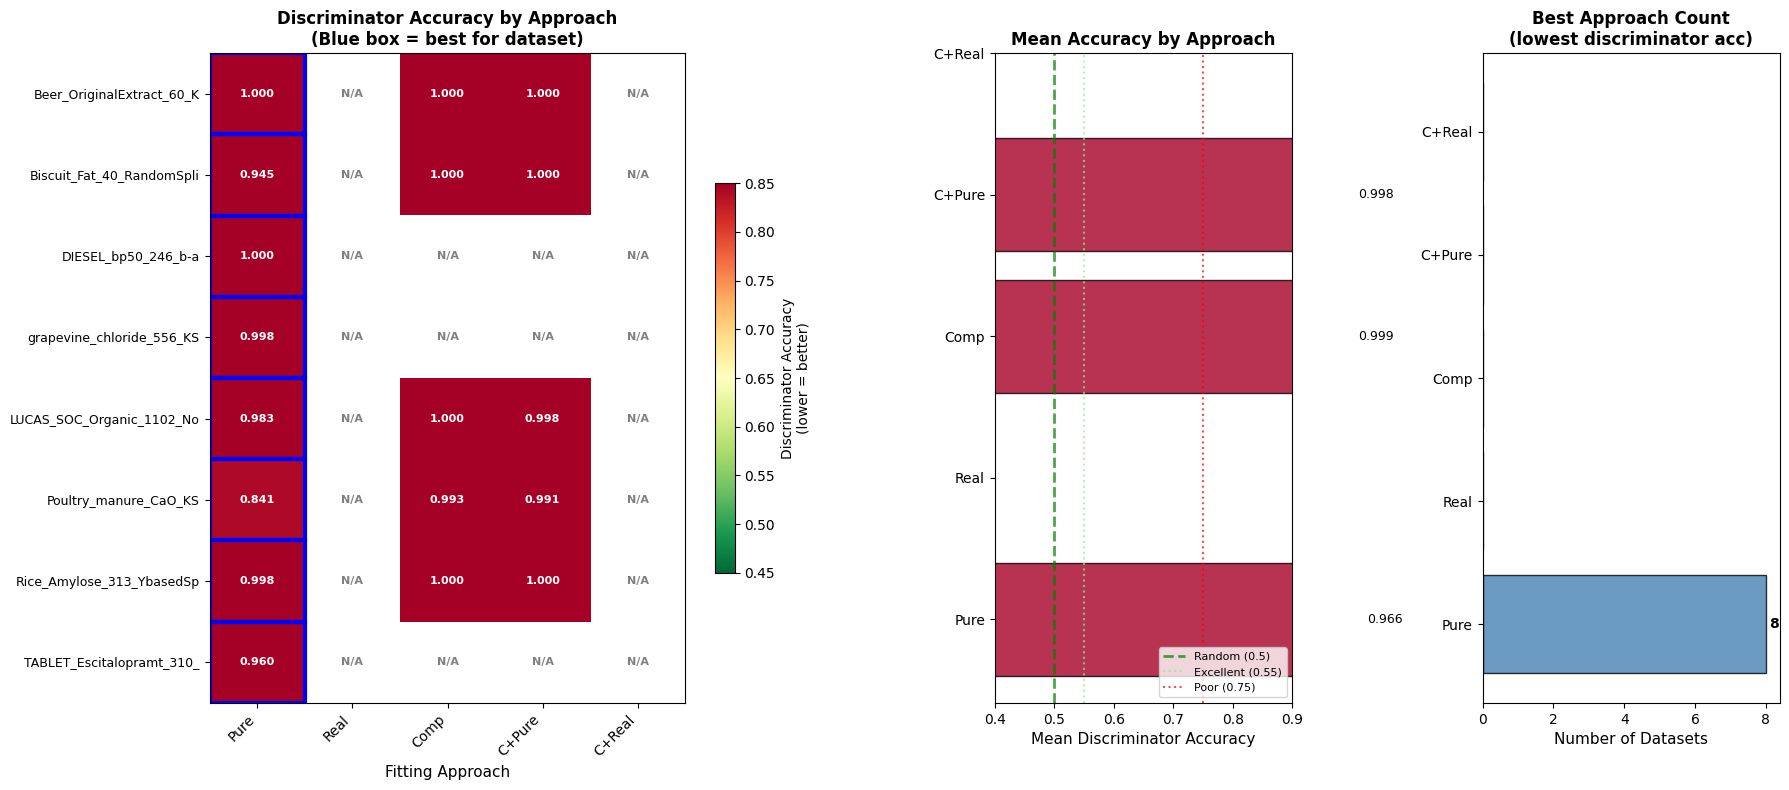


DISCRIMINATOR SUMMARY BY APPROACH
Pure        : mean=0.966, best_for=8, ✓excellent=0, ○good=0, △moderate=0, ✗poor=8
Real        : No valid results
Comp        : mean=0.999, best_for=0, ✓excellent=0, ○good=0, △moderate=0, ✗poor=5
C+Pure      : mean=0.998, best_for=0, ✓excellent=0, ○good=0, △moderate=0, ✗poor=5
C+Real      : No valid results


In [22]:
# Comprehensive discriminator visualization: Heatmap + Bar charts
import matplotlib.patches as mpatches

approach_names = ['pure_bands', 'real_bands', 'comp_only', 'comp_pure', 'comp_real']
approach_display_short = ['Pure', 'Real', 'Comp', 'C+Pure', 'C+Real']

# Build discriminator matrix
n_datasets = len(datasets)
n_approaches = len(approach_names)
disc_matrix = np.full((n_datasets, n_approaches), np.nan)

for i, d in enumerate(datasets):
    for j, approach in enumerate(approach_names):
        acc = d.get('disc_all_approaches', {}).get(approach, (np.nan,))[0]
        disc_matrix[i, j] = acc

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(18, 8), gridspec_kw={'width_ratios': [2, 1, 1]})

# 1. Heatmap of discriminator accuracy
ax1 = axes[0]
cmap = plt.cm.RdYlGn_r  # Reversed: Green (low acc = good) -> Red (high acc = bad)
im = ax1.imshow(disc_matrix, cmap=cmap, aspect='auto', vmin=0.45, vmax=0.85)

ax1.set_xticks(np.arange(n_approaches))
ax1.set_yticks(np.arange(n_datasets))
ax1.set_xticklabels(approach_display_short, rotation=45, ha='right', fontsize=10)
ax1.set_yticklabels([d['name'][:25] for d in datasets], fontsize=9)

# Add text annotations
for i in range(n_datasets):
    for j in range(n_approaches):
        val = disc_matrix[i, j]
        if np.isnan(val):
            text = 'N/A'
            color = 'gray'
        else:
            text = f'{val:.3f}'
            color = 'white' if val > 0.65 or val < 0.52 else 'black'
        ax1.text(j, i, text, ha='center', va='center', fontsize=8, color=color, fontweight='bold')

# Mark best per dataset
for i in range(n_datasets):
    row = disc_matrix[i, :]
    valid_mask = ~np.isnan(row)
    if np.any(valid_mask):
        best_j = np.nanargmin(row)
        ax1.add_patch(plt.Rectangle((best_j - 0.5, i - 0.5), 1, 1,
                                      fill=False, edgecolor='blue', linewidth=3))

cbar = fig.colorbar(im, ax=ax1, shrink=0.6)
cbar.set_label('Discriminator Accuracy\n(lower = better)', fontsize=10)
ax1.set_title('Discriminator Accuracy by Approach\n(Blue box = best for dataset)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Fitting Approach', fontsize=11)

# 2. Mean accuracy per approach
ax2 = axes[1]
means = np.nanmean(disc_matrix, axis=0)
stds = np.nanstd(disc_matrix, axis=0)
colors = [plt.cm.RdYlGn_r((m - 0.45) / 0.4) if not np.isnan(m) else 'gray' for m in means]

bars = ax2.barh(np.arange(n_approaches), means, xerr=stds, color=colors,
                edgecolor='black', capsize=3, alpha=0.8)
ax2.set_yticks(np.arange(n_approaches))
ax2.set_yticklabels(approach_display_short)
ax2.axvline(0.5, color='green', linestyle='--', lw=2, alpha=0.7, label='Random (0.5)')
ax2.axvline(0.55, color='lightgreen', linestyle=':', lw=1.5, alpha=0.7, label='Excellent (0.55)')
ax2.axvline(0.75, color='red', linestyle=':', lw=1.5, alpha=0.7, label='Poor (0.75)')
ax2.set_xlabel('Mean Discriminator Accuracy', fontsize=11)
ax2.set_title('Mean Accuracy by Approach', fontsize=12, fontweight='bold')
ax2.legend(loc='lower right', fontsize=8)
ax2.set_xlim(0.4, 0.9)

for i, (m, s) in enumerate(zip(means, stds, strict=False)):
    if not np.isnan(m):
        ax2.text(m + s + 0.01, i, f'{m:.3f}', va='center', fontsize=9)

# 3. Best approach count
ax3 = axes[2]
best_counts = dict.fromkeys(approach_names, 0)
for i in range(n_datasets):
    row = disc_matrix[i, :]
    valid_mask = ~np.isnan(row)
    if np.any(valid_mask):
        best_j = np.nanargmin(row)
        best_counts[approach_names[best_j]] += 1

counts = [best_counts[a] for a in approach_names]
bars = ax3.barh(np.arange(n_approaches), counts, color='steelblue', edgecolor='black', alpha=0.8)
ax3.set_yticks(np.arange(n_approaches))
ax3.set_yticklabels(approach_display_short)
ax3.set_xlabel('Number of Datasets', fontsize=11)
ax3.set_title('Best Approach Count\n(lowest discriminator acc)', fontsize=12, fontweight='bold')

for i, c in enumerate(counts):
    if c > 0:
        ax3.text(c + 0.1, i, str(c), va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary statistics
print("\nDISCRIMINATOR SUMMARY BY APPROACH")
print("=" * 80)
for j, (approach, display) in enumerate(zip(approach_names, approach_display_short, strict=False)):
    vals = disc_matrix[:, j]
    valid = vals[~np.isnan(vals)]
    if len(valid) > 0:
        excellent = np.sum(valid < 0.55)
        good = np.sum((valid >= 0.55) & (valid < 0.65))
        moderate = np.sum((valid >= 0.65) & (valid < 0.75))
        poor = np.sum(valid >= 0.75)
        print(f"{display:12s}: mean={np.mean(valid):.3f}, best_for={best_counts[approach]}, "
              f"✓excellent={excellent}, ○good={good}, △moderate={moderate}, ✗poor={poor}")
    else:
        print(f"{display:12s}: No valid results")

---
## Initial Results Summary

Summary so far:
1. ✓ Loaded all datasets
2. ✓ RealDataFitter parameters
3. ✓ Pure band fitting
4. ✓ Component category mapping
5. ✓ Constrained component fitting
6. ✓ Pure band refinement
7. ✓ Diversity parameters
8. ✓ Synthetic generation
9. ✓ Multi-approach discriminator
10. ✓ Discriminator visualization

Now continuing with Real Band fitting from NIR_BANDS dictionary...

---
## 11. Real Band Fitting (Using NIR_BANDS Dictionary)

Instead of optimizing band centers freely, use the **known NIR band assignments** from `_bands.py`.
This constrains the fit to physically meaningful band positions, only optimizing amplitudes.

Key differences from pure band fitting:
- **Fixed centers**: Use known band positions from literature
- **Constrained sigmas**: Use typical width ranges from BandAssignment
- **Only amplitudes optimized**: More interpretable results

In [23]:
# Import real bands from _bands.py
from nirs4all.data.synthetic._bands import (
    NIR_BANDS,
    BandAssignment,
    get_bands_by_tag,
    get_bands_in_range,
    list_bands,
    list_functional_groups,
)


class RealBandFitter:
    """
    Fit spectra using REAL NIR band assignments from _bands.py.

    Unlike PureBandFitter which optimizes centers freely, this uses:
    - Fixed band centers from known literature assignments
    - Constrained sigma values based on typical ranges
    - Only amplitude optimization (more interpretable)

    This provides physically meaningful spectral decomposition.
    """

    def __init__(self, baseline_order=3, target_r2=0.95,
                 allow_sigma_variation=True, sigma_margin=0.3):
        """
        Args:
            baseline_order: Polynomial baseline degree
            target_r2: Target R² for iterative fitting
            allow_sigma_variation: Allow sigma to vary within range
            sigma_margin: How much sigma can vary from midpoint (0.3 = ±30%)
        """
        self.baseline_order = baseline_order
        self.target_r2 = target_r2
        self.allow_sigma_variation = allow_sigma_variation
        self.sigma_margin = sigma_margin

    def get_candidate_bands(self, wl_min: float, wl_max: float) -> list[BandAssignment]:
        """Get all bands in the wavelength range."""
        return get_bands_in_range(wl_min, wl_max)

    def _compute_band(self, wl: np.ndarray, center: float, sigma: float,
                      amplitude: float) -> np.ndarray:
        """Compute Gaussian band profile."""
        return amplitude * np.exp(-0.5 * ((wl - center) / sigma) ** 2)

    def _compute_all_bands(self, wl: np.ndarray, bands: list[BandAssignment],
                           amplitudes: np.ndarray, sigmas: np.ndarray = None) -> np.ndarray:
        """Compute sum of all bands."""
        result = np.zeros_like(wl, dtype=float)
        for i, band in enumerate(bands):
            sigma = sigmas[i] if sigmas is not None else (band.sigma_range[0] + band.sigma_range[1]) / 2
            result += self._compute_band(wl, band.center, sigma, amplitudes[i])
        return result

    def _build_baseline(self, wl: np.ndarray, coeffs: np.ndarray) -> np.ndarray:
        """Build polynomial baseline."""
        wl_norm = (wl - wl.mean()) / (wl.max() - wl.min())
        return np.polyval(coeffs[::-1], wl_norm)

    def fit(self, spectrum: np.ndarray, wl: np.ndarray,
            max_bands: int = 50, n_iterations: int = 3) -> dict:
        """
        Fit spectrum using real NIR band positions.

        Args:
            spectrum: Target spectrum to fit
            wl: Wavelengths (nm)
            max_bands: Maximum number of bands to use
            n_iterations: Refinement iterations

        Returns:
            dict with fitted bands, amplitudes, r_squared, etc.
        """
        wl_min, wl_max = wl.min(), wl.max()
        spec_range = spectrum.max() - spectrum.min()
        spec_mean = spectrum.mean()
        n_baseline = self.baseline_order + 1

        # Get all candidate bands in range
        all_bands = self.get_candidate_bands(wl_min - 50, wl_max + 50)

        # Filter to bands with centers actually in range
        candidate_bands = [b for b in all_bands if wl_min <= b.center <= wl_max]

        if not candidate_bands:
            # Fallback: use any bands that might contribute
            candidate_bands = all_bands[:max_bands]

        if not candidate_bands:
            # No bands available
            baseline_coeffs = np.polyfit(
                (wl - wl.mean()) / (wl.max() - wl.min()),
                spectrum,
                self.baseline_order
            )[::-1]
            fitted = self._build_baseline(wl, baseline_coeffs)
            ss_res = np.sum((spectrum - fitted) ** 2)
            ss_tot = np.sum((spectrum - np.mean(spectrum)) ** 2)
            r2 = 1 - ss_res / ss_tot if ss_tot > 1e-10 else 0.0
            return {
                'bands': [],
                'band_names': [],
                'amplitudes': [],
                'sigmas': [],
                'fitted': fitted,
                'r_squared': r2,
                'n_bands': 0,
                'baseline_coeffs': baseline_coeffs.tolist(),
            }

        # Sort by intensity (prefer stronger bands)
        intensity_order = {'very_strong': 0, 'strong': 1, 'medium': 2, 'weak': 3, 'very_weak': 4}
        candidate_bands = sorted(candidate_bands,
                                  key=lambda b: (intensity_order.get(b.intensity, 5), b.center))

        # Limit to max_bands
        candidate_bands = candidate_bands[:max_bands]
        n_bands = len(candidate_bands)

        # Build design matrix (bands as columns)
        band_centers = np.array([b.center for b in candidate_bands])
        band_sigmas_mid = np.array([(b.sigma_range[0] + b.sigma_range[1]) / 2 for b in candidate_bands])
        band_sigmas_lo = np.array([b.sigma_range[0] for b in candidate_bands])
        band_sigmas_hi = np.array([b.sigma_range[1] for b in candidate_bands])

        # Initial baseline fit
        wl_norm = (wl - wl.mean()) / (wl.max() - wl.min())
        baseline_init = np.polyfit(wl_norm, spectrum, self.baseline_order)[::-1]

        # Build initial parameters: [amplitudes..., sigmas..., baseline_coeffs...]
        if self.allow_sigma_variation:
            # Parameters: amplitudes + sigmas + baseline
            n_params = n_bands * 2 + n_baseline
            x0 = np.zeros(n_params)
            # Initial amplitudes based on spectrum value at band center
            for i, band in enumerate(candidate_bands):
                idx = np.argmin(np.abs(wl - band.center))
                x0[i] = max(0, (spectrum[idx] - spec_mean) * 0.5)
            # Initial sigmas
            x0[n_bands:2*n_bands] = band_sigmas_mid
            # Initial baseline
            x0[2*n_bands:] = baseline_init

            # Bounds
            bounds_lo = (
                [-spec_range * 2] * n_bands +  # Amplitudes (allow negative)
                list(band_sigmas_lo * (1 - self.sigma_margin)) +  # Sigmas lower
                [-spec_range * 10] * n_baseline  # Baseline
            )
            bounds_hi = (
                [spec_range * 2] * n_bands +  # Amplitudes
                list(band_sigmas_hi * (1 + self.sigma_margin)) +  # Sigmas upper
                [spec_range * 10] * n_baseline  # Baseline
            )

            def model(params):
                amplitudes = params[:n_bands]
                sigmas = params[n_bands:2*n_bands]
                baseline_coeffs = params[2*n_bands:]
                bands_sum = self._compute_all_bands(wl, candidate_bands, amplitudes, sigmas)
                baseline = self._build_baseline(wl, baseline_coeffs)
                return bands_sum + baseline
        else:
            # Parameters: amplitudes + baseline only
            n_params = n_bands + n_baseline
            x0 = np.zeros(n_params)
            for i, band in enumerate(candidate_bands):
                idx = np.argmin(np.abs(wl - band.center))
                x0[i] = max(0, (spectrum[idx] - spec_mean) * 0.5)
            x0[n_bands:] = baseline_init

            bounds_lo = [-spec_range * 2] * n_bands + [-spec_range * 10] * n_baseline
            bounds_hi = [spec_range * 2] * n_bands + [spec_range * 10] * n_baseline

            def model(params):
                amplitudes = params[:n_bands]
                baseline_coeffs = params[n_bands:]
                bands_sum = self._compute_all_bands(wl, candidate_bands, amplitudes, band_sigmas_mid)
                baseline = self._build_baseline(wl, baseline_coeffs)
                return bands_sum + baseline

        def objective(params):
            return np.sum((spectrum - model(params)) ** 2)

        # Optimize
        best_result = None
        best_r2 = -np.inf

        for _iteration in range(n_iterations):
            try:
                res = minimize(objective, x0, method='L-BFGS-B',
                              bounds=list(zip(bounds_lo, bounds_hi, strict=False)),
                              options={'maxiter': 2000, 'ftol': 1e-12})
                fitted = model(res.x)

                ss_res = np.sum((spectrum - fitted) ** 2)
                ss_tot = np.sum((spectrum - np.mean(spectrum)) ** 2)
                r2 = 1 - ss_res / ss_tot if ss_tot > 1e-10 else 0.0

                if r2 > best_r2:
                    best_r2 = r2
                    if self.allow_sigma_variation:
                        amplitudes = res.x[:n_bands]
                        sigmas = res.x[n_bands:2*n_bands]
                        baseline_coeffs = res.x[2*n_bands:]
                    else:
                        amplitudes = res.x[:n_bands]
                        sigmas = band_sigmas_mid
                        baseline_coeffs = res.x[n_bands:]

                    # Build band info with names
                    band_info = []
                    for i, band in enumerate(candidate_bands):
                        if abs(amplitudes[i]) > spec_range * 1e-6:
                            band_info.append({
                                'center': band.center,
                                'sigma': sigmas[i],
                                'amplitude': amplitudes[i],
                                'name': f"{band.functional_group}/{band.overtone_level}",
                                'description': band.description,
                                'functional_group': band.functional_group,
                                'overtone': band.overtone_level,
                                'assignment': band
                            })

                    best_result = {
                        'bands': sorted(band_info, key=lambda b: b['center']),
                        'band_names': [b['name'] for b in band_info],
                        'amplitudes': amplitudes.tolist(),
                        'sigmas': sigmas.tolist() if isinstance(sigmas, np.ndarray) else sigmas,
                        'fitted': fitted,
                        'r_squared': r2,
                        'n_bands': len([a for a in amplitudes if abs(a) > spec_range * 1e-6]),
                        'baseline_coeffs': baseline_coeffs.tolist(),
                        'candidate_bands': candidate_bands,
                    }

                # If good enough, stop
                if r2 >= self.target_r2:
                    break

                # Update initial point for next iteration
                x0 = res.x + np.random.normal(0, 0.01, len(res.x))
                x0 = np.clip(x0, bounds_lo, bounds_hi)

            except Exception as e:
                continue

        if best_result is None:
            # Return empty result
            baseline_coeffs = baseline_init
            fitted = self._build_baseline(wl, baseline_coeffs)
            ss_res = np.sum((spectrum - fitted) ** 2)
            ss_tot = np.sum((spectrum - np.mean(spectrum)) ** 2)
            r2 = 1 - ss_res / ss_tot if ss_tot > 1e-10 else 0.0
            best_result = {
                'bands': [],
                'band_names': [],
                'amplitudes': [],
                'sigmas': [],
                'fitted': fitted,
                'r_squared': r2,
                'n_bands': 0,
                'baseline_coeffs': baseline_coeffs.tolist(),
            }

        return best_result


# Show available bands summary
print("NIR_BANDS DICTIONARY SUMMARY")
print("=" * 80)
print(f"Functional groups: {len(NIR_BANDS)}")
total_bands = sum(len(bands) for bands in NIR_BANDS.values())
print(f"Total band assignments: {total_bands}")
print()
print("Bands by functional group:")
for group in sorted(NIR_BANDS.keys()):
    n = len(NIR_BANDS[group])
    centers = [b.center for b in NIR_BANDS[group].values()]
    print(f"  {group:20s}: {n:3d} bands ({min(centers):.0f}-{max(centers):.0f} nm)")
print("=" * 80)

NIR_BANDS DICTIONARY SUMMARY
Functional groups: 20
Total band assignments: 88

Bands by functional group:
  Al-OH               :   3 bands (1400-2200 nm)
  Anthocyanin         :   2 bands (520-550 nm)
  C-Cl                :   1 bands (2250-2250 nm)
  C-F                 :   2 bands (2180-2365 nm)
  C-H_aliphatic       :  10 bands (890-2350 nm)
  C-H_aromatic        :   7 bands (875-2440 nm)
  C-H_olefinic        :   3 bands (1160-2175 nm)
  C=O                 :   5 bands (1690-2020 nm)
  CO3                 :   2 bands (2330-2525 nm)
  Carotenoid          :   4 bands (425-478 nm)
  Fe-OH               :   3 bands (1420-2260 nm)
  Mg-OH               :   3 bands (1395-2390 nm)
  N-H                 :  11 bands (750-2300 nm)
  O-H                 :  15 bands (730-2500 nm)
  P-O                 :   1 bands (2165-2165 nm)
  Porphyrin           :   9 bands (414-662 nm)
  Red_edge            :   2 bands (720-760 nm)
  S=O                 :   1 bands (2030-2030 nm)
  SO4                 : 

In [24]:
print("\nREAL BAND FITTING (Using NIR_BANDS dictionary)")
print("=" * 120)

for d in datasets:
    wl = d['wl']

    # Use smoothed median as target
    window = min(21, len(wl) // 10 * 2 + 1)
    window = max(5, window) | 1
    target = scipy_signal.savgol_filter(d['median'], window, 2)

    # Check available bands in range
    available = get_bands_in_range(wl.min(), wl.max())

    if len(available) == 0:
        print(f"⊘ {d['name'][:45]:<45} NO BANDS IN RANGE ({wl.min():.0f}-{wl.max():.0f} nm)")
        d['real_band_result'] = None
        continue

    # Fit with real bands
    fitter = RealBandFitter(
        baseline_order=4,
        target_r2=0.95,
        allow_sigma_variation=True,
        sigma_margin=0.5
    )

    result = fitter.fit(target, wl, max_bands=60, n_iterations=5)
    d['real_band_result'] = result

    # Get top contributing bands
    top_bands = sorted(result['bands'], key=lambda b: -abs(b['amplitude']))[:5]
    top_names = [b['name'][:15] for b in top_bands]

    status = "✓" if result['r_squared'] >= 0.90 else "✗"
    print(f"{status} {d['name'][:40]:<40} R²={result['r_squared']:.4f}, "
          f"bands={result['n_bands']:>3} | {top_names[:3]}")

print("=" * 120)
print("\nComparison: Pure bands (optimized) vs Real bands (fixed centers)")


REAL BAND FITTING (Using NIR_BANDS dictionary)
✓ Beer_OriginalExtract_60_KS               R²=0.9968, bands= 52 | ['O-H/combination', 'Si-OH/1st', 'C-H/combination']
✓ Biscuit_Fat_40_RandomSplit               R²=0.9970, bands= 60 | ['O-H/combination', 'O-H/combination', 'N-H/1st']
✓ DIESEL_bp50_246_b-a                      R²=0.9411, bands= 28 | ['Al-OH/1st', 'O-H/1st', 'O-H/1st']
✓ grapevine_chloride_556_KS                R²=0.9760, bands= 60 | ['Anthocyanin/ele', 'Porphyrin/elect', 'Porphyrin/elect']
✓ LUCAS_SOC_Organic_1102_NocitaKS          R²=0.9956, bands= 60 | ['Anthocyanin/ele', 'Carotenoid/elec', 'Porphyrin/elect']
✓ Poultry_manure_CaO_KS                    R²=0.9975, bands= 60 | ['C=O/combination', 'S=O/combination', 'O-H/combination']
✓ Rice_Amylose_313_YbasedSplit             R²=0.9041, bands= 60 | ['C-H/1st', 'O-H/combination', '=C-H/2nd']
✓ TABLET_Escitalopramt_310_Zhao            R²=0.9613, bands= 60 | ['Porphyrin/elect', 'Carotenoid/elec', 'C-H/1st']

Comparison: Pure b

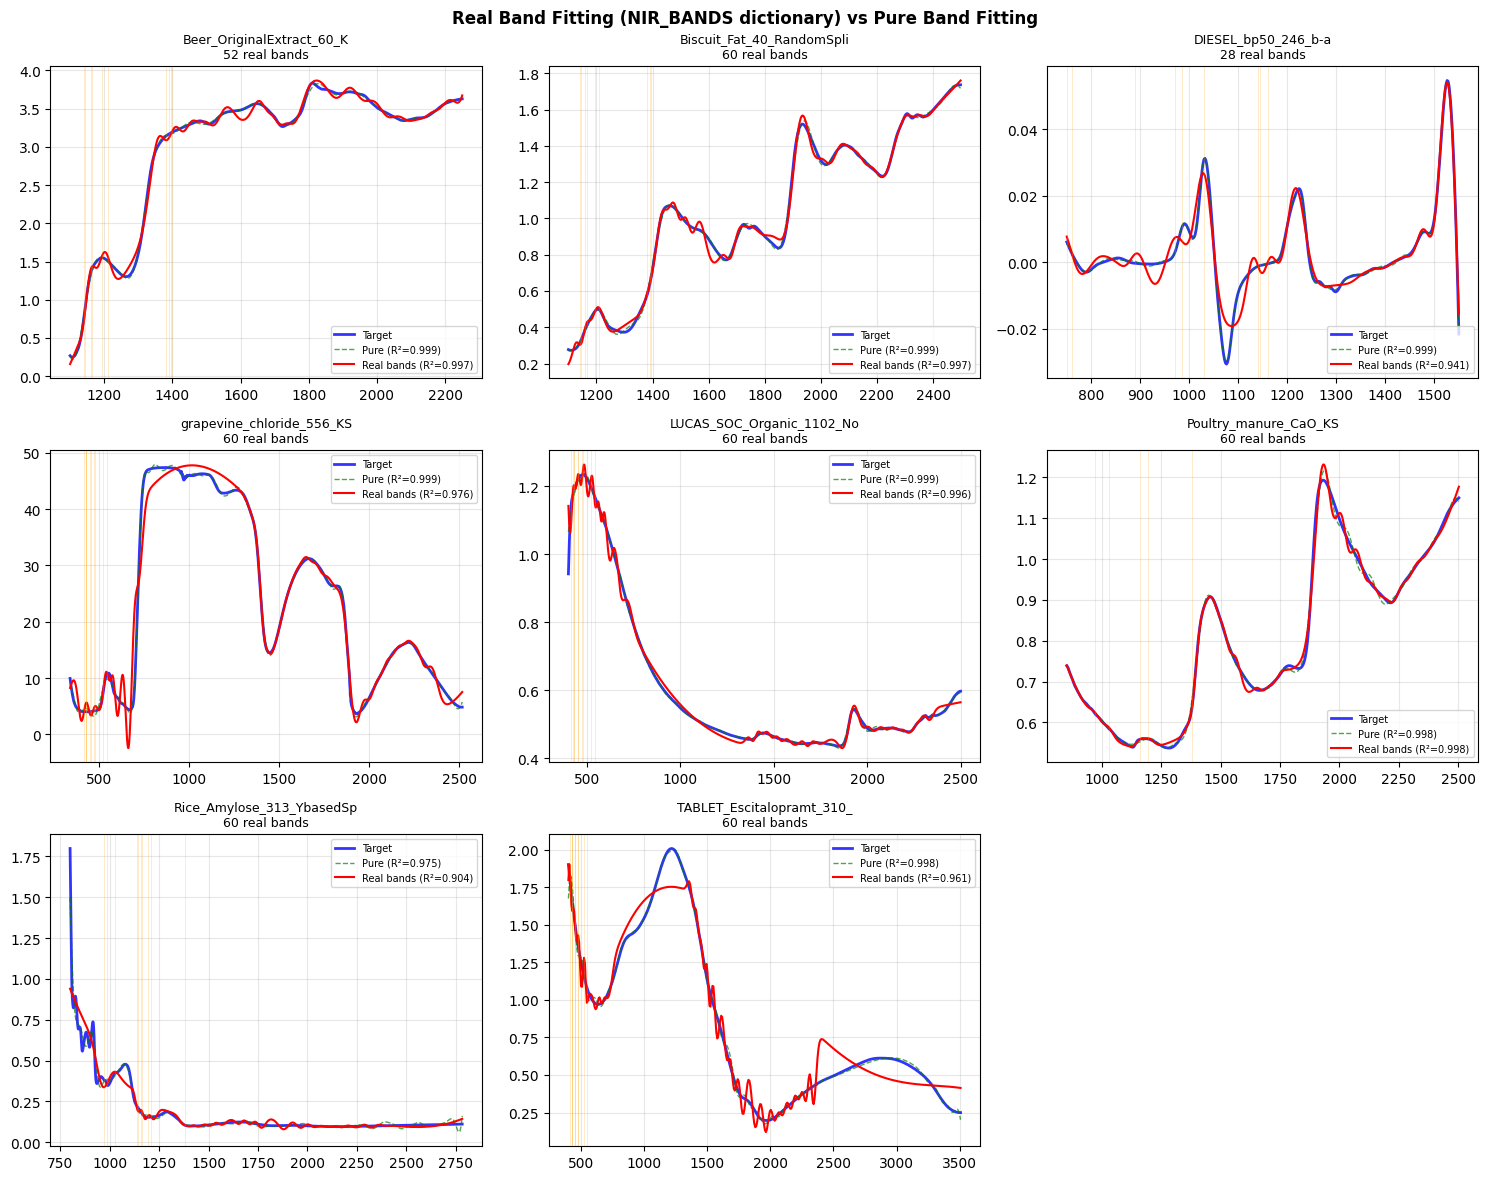

In [25]:
# Visualization: Real band fitting vs Pure band fitting
valid_real = [d for d in datasets if d.get('real_band_result') is not None]
n_valid = len(valid_real)

if n_valid > 0:
    n_cols = 3
    n_rows = (n_valid + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = np.atleast_2d(axes).flatten()

    for i, d in enumerate(valid_real):
        ax = axes[i]
        wl = d['wl']

        window = min(21, len(wl) // 10 * 2 + 1) | 1
        target = scipy_signal.savgol_filter(d['median'], window, 2)

        real_result = d['real_band_result']
        pure_result = d.get('pure_band_result', {})

        ax.plot(wl, target, 'b-', lw=2, label='Target', alpha=0.8)

        if pure_result:
            ax.plot(wl, pure_result['fitted'], 'g--', lw=1,
                    label=f"Pure (R²={pure_result['r_squared']:.3f})", alpha=0.7)

        ax.plot(wl, real_result['fitted'], 'r-', lw=1.5,
                label=f"Real bands (R²={real_result['r_squared']:.3f})")

        # Mark real band centers
        for band in real_result['bands'][:10]:
            if abs(band['amplitude']) > 0.01:
                ax.axvline(band['center'], color='orange', alpha=0.3, lw=0.5)

        ax.set_title(f"{d['name'][:25]}\n{real_result['n_bands']} real bands", fontsize=9)
        ax.legend(fontsize=7, loc='best')
        ax.grid(True, alpha=0.3)

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle('Real Band Fitting (NIR_BANDS dictionary) vs Pure Band Fitting', fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("No valid real band fitting results")

---
## 12. Components + Real Bands Combination

Combine chemical components (from `_constants.py`) with real bands (from `_bands.py`):
1. First fit components (constrained quantities)
2. Then fit residual with real bands

This gives both interpretable components AND physically meaningful band assignments.

In [26]:
print("\nCOMPONENTS + REAL BANDS FITTING")
print("=" * 120)

for d in datasets:
    # Skip derivative data
    if d.get('is_derivative', False) or d['min'] < -0.5:
        print(f"⊘ {d['name'][:45]:<45} SKIPPED (derivative data)")
        d['comp_realband_result'] = None
        continue

    wl = d['wl']
    window = min(21, len(wl) // 10 * 2 + 1) | 1
    target = scipy_signal.savgol_filter(d['median'], window, 2)

    # Check if we have component result
    comp_result = d.get('component_result')
    if comp_result is None:
        print(f"⊘ {d['name'][:45]:<45} NO COMPONENT RESULT")
        d['comp_realband_result'] = None
        continue

    # Get residual after component fitting
    residual = comp_result['residual']

    # Fit residual with real bands
    fitter = RealBandFitter(
        baseline_order=2,
        target_r2=0.90,
        allow_sigma_variation=True,
        sigma_margin=0.3
    )

    realband_result = fitter.fit(residual, wl, max_bands=40, n_iterations=3)

    # Combined fit
    combined_fitted = comp_result['fitted'] + realband_result['fitted']

    # R² of combined
    ss_res = np.sum((target - combined_fitted) ** 2)
    ss_tot = np.sum((target - np.mean(target)) ** 2)
    combined_r2 = 1 - ss_res / ss_tot if ss_tot > 1e-10 else 0.0

    d['comp_realband_result'] = {
        'type': 'components_plus_real_bands',
        'component_r2': comp_result['r_squared'],
        'realband_r2': realband_result['r_squared'],
        'combined_r2': combined_r2,
        'combined_fitted': combined_fitted,
        'components': comp_result['components'],
        'quantities': comp_result['quantities'],
        'real_bands': realband_result['bands'],
        'n_real_bands': realband_result['n_bands'],
    }

    improvement = combined_r2 - comp_result['r_squared']
    top_bands = [b['name'][:12] for b in sorted(realband_result['bands'],
                                                  key=lambda x: -abs(x['amplitude']))[:3]]

    print(f"✓ {d['name'][:40]:<40} Comp R²={comp_result['r_squared']:.4f} → Combined R²={combined_r2:.4f} "
          f"(+{improvement:.4f}, {realband_result['n_bands']} bands)")
    print(f"  Components: {comp_result['components'][:3]}")
    print(f"  Real bands: {top_bands}")

print("=" * 120)


COMPONENTS + REAL BANDS FITTING
✓ Beer_OriginalExtract_60_KS               Comp R²=-2.6328 → Combined R²=0.9452 (+3.5779, 40 bands)
  Components: ['cotton', 'methanol', 'succinic_acid']
  Real bands: ['C-H/1st', 'C-H/1st', 'SO₄·H₂O/comb']
✓ Biscuit_Fat_40_RandomSplit               Comp R²=-0.8210 → Combined R²=0.9209 (+1.7419, 40 bands)
  Components: ['water', 'palmitic_acid', 'collagen']
  Real bands: ['Al-OH/combin', 'SO₄/combinat', 'Al-OH/combin']
⊘ DIESEL_bp50_246_b-a                           SKIPPED (derivative data)
⊘ grapevine_chloride_556_KS                     SKIPPED (derivative data)
✓ LUCAS_SOC_Organic_1102_NocitaKS          Comp R²=-4.7614 → Combined R²=0.9128 (+5.6742, 40 bands)
  Components: ['water', 'protein', 'cotton']
  Real bands: ['Carotenoid/e', 'Anthocyanin/', 'Carotenoid/e']
✓ Poultry_manure_CaO_KS                    Comp R²=-6.2134 → Combined R²=0.7061 (+6.9195, 40 bands)
  Components: ['water', 'protein', 'carbonates']
  Real bands: ['SO₄/combinat', 'Al-OH/c

---
## 13. Final Synthetic Generation & Discriminator (All Approaches)

Now that we have fitted all approaches (pure bands, real bands, components, comp+pure, comp+real),
we regenerate synthetic data for all and run a final discriminator test.

In [27]:
# Final regeneration of synthetic data for ALL approaches after real band fitting
print("=" * 160)
print("FINAL SYNTHETIC GENERATION FOR ALL APPROACHES")
print("=" * 160)

for d in datasets:
    wl = d['wl']
    window = min(21, len(wl) // 10 * 2 + 1) | 1
    target_smooth = scipy_signal.savgol_filter(d['median'], window, 2)

    n_synth = min(d['X'].shape[0], 500)
    generator = MultiApproachGenerator(wl, d['diversity_params'])

    # Initialize or clear
    if 'synth_approaches' not in d:
        d['synth_approaches'] = {}

    approaches_generated = []

    # 1. Pure bands
    pb = d.get('pure_band_result')
    if pb and 'fitted' in pb:
        X_synth = generator.generate(pb['fitted'], n_synth, random_state=42)
        d['synth_approaches']['pure_bands'] = X_synth
        approaches_generated.append('pure_bands')

    # 2. Real bands (now should have data after Section 11)
    rb = d.get('real_band_result')
    if rb and 'fitted' in rb:
        X_synth = generator.generate(rb['fitted'], n_synth, random_state=42)
        d['synth_approaches']['real_bands'] = X_synth
        approaches_generated.append('real_bands')

    # 3. Components only
    comp = d.get('component_result')
    if comp and 'fitted' in comp:
        X_synth = generator.generate(comp['fitted'], n_synth, random_state=42)
        d['synth_approaches']['comp_only'] = X_synth
        approaches_generated.append('comp_only')

    # 4. Components + pure bands
    final = d.get('final_result', {})
    if final.get('type') == 'components_plus_bands' and 'combined_fitted' in final:
        X_synth = generator.generate(final['combined_fitted'], n_synth, random_state=42)
        d['synth_approaches']['comp_pure'] = X_synth
        approaches_generated.append('comp_pure')

    # 5. Components + real bands (now should have data after Section 12)
    crb = d.get('comp_realband_result', {})
    if crb and 'combined_fitted' in crb:
        X_synth = generator.generate(crb['combined_fitted'], n_synth, random_state=42)
        d['synth_approaches']['comp_real'] = X_synth
        approaches_generated.append('comp_real')

    print(f"{d['name'][:40]:<40} Generated: {approaches_generated}")

print("=" * 160)

# FINAL DISCRIMINATOR TEST
print("\n" + "=" * 160)
print("FINAL DISCRIMINATOR TEST: ALL APPROACHES")
print("=" * 160)

approach_names = ['pure_bands', 'real_bands', 'comp_only', 'comp_pure', 'comp_real']
approach_display = {
    'pure_bands': 'Pure Bands',
    'real_bands': 'Real Bands',
    'comp_only': 'Components',
    'comp_pure': 'Comp+Pure',
    'comp_real': 'Comp+Real',
}

# Store final results
final_disc_results = {}

print(f"\n{'Dataset':<30} {'Pure Bands':>12} {'Real Bands':>12} {'Components':>12} "
      f"{'Comp+Pure':>12} {'Comp+Real':>12} {'Best':>15}")
print("-" * 160)

for d in datasets:
    final_disc_results[d['name']] = {}
    row_results = []

    for approach in approach_names:
        synth = d.get('synth_approaches', {}).get(approach)
        if synth is not None and len(synth) > 0:
            acc_mean, acc_std = test_discriminator(d['X'], synth)
            final_disc_results[d['name']][approach] = (acc_mean, acc_std)
            row_results.append((approach, acc_mean))
        else:
            final_disc_results[d['name']][approach] = (np.nan, np.nan)
            row_results.append((approach, np.nan))

    # Format output
    vals = []
    for approach in approach_names:
        acc = final_disc_results[d['name']][approach][0]
        if np.isnan(acc):
            vals.append("N/A")
        else:
            if acc < 0.55:
                vals.append(f"✓{acc:.3f}")
            elif acc < 0.65:
                vals.append(f"○{acc:.3f}")
            elif acc < 0.75:
                vals.append(f"△{acc:.3f}")
            else:
                vals.append(f"✗{acc:.3f}")

    # Find best
    valid_results = [(a, v) for a, v in row_results if not np.isnan(v)]
    if valid_results:
        best_approach, best_acc = min(valid_results, key=lambda x: x[1])
        best_str = f"{approach_display[best_approach][:8]} ({best_acc:.2f})"
    else:
        best_str = "N/A"

    print(f"{d['name'][:30]:<30} {vals[0]:>12} {vals[1]:>12} {vals[2]:>12} "
          f"{vals[3]:>12} {vals[4]:>12} {best_str:>15}")

    # Store for later
    d['final_disc_results'] = final_disc_results[d['name']]

print("=" * 160)
print("\nLegend: ✓ Excellent (<0.55), ○ Good (<0.65), △ Moderate (<0.75), ✗ Poor (≥0.75)")

FINAL SYNTHETIC GENERATION FOR ALL APPROACHES
Beer_OriginalExtract_60_KS               Generated: ['pure_bands', 'real_bands', 'comp_only', 'comp_pure', 'comp_real']
Biscuit_Fat_40_RandomSplit               Generated: ['pure_bands', 'real_bands', 'comp_only', 'comp_pure', 'comp_real']
DIESEL_bp50_246_b-a                      Generated: ['pure_bands', 'real_bands']
grapevine_chloride_556_KS                Generated: ['pure_bands', 'real_bands']
LUCAS_SOC_Organic_1102_NocitaKS          Generated: ['pure_bands', 'real_bands', 'comp_only', 'comp_pure', 'comp_real']
Poultry_manure_CaO_KS                    Generated: ['pure_bands', 'real_bands', 'comp_only', 'comp_pure', 'comp_real']
Rice_Amylose_313_YbasedSplit             Generated: ['pure_bands', 'real_bands', 'comp_only', 'comp_pure', 'comp_real']
TABLET_Escitalopramt_310_Zhao            Generated: ['pure_bands', 'real_bands']

FINAL DISCRIMINATOR TEST: ALL APPROACHES

Dataset                          Pure Bands   Real Bands   Component

---
## 14. Comprehensive Summary (All Approaches)

Compare ALL fitting approaches for each dataset:

| Approach | Description |
|----------|-------------|
| **Pure Bands** | Freely optimized Gaussian bands (centers, sigmas, amplitudes) |
| **Real Bands** | NIR_BANDS dictionary bands (fixed centers from literature) |
| **Components Only** | Chemical components from _constants.py |
| **Components + Pure Bands** | Components + freely optimized residual bands |
| **Components + Real Bands** | Components + physically meaningful residual bands |

In [28]:
# Build comprehensive summary for all datasets
summary_data = []

for d in datasets:
    row = {
        'dataset': d['name'],
        'short_name': d['name'][:25],
        'wl_range': f"{d['wl'].min():.0f}-{d['wl'].max():.0f}",
        'n_wl': len(d['wl']),
        'is_derivative': d.get('is_derivative', False),
    }

    # Pure bands (optimized)
    pb = d.get('pure_band_result', {})
    row['pure_bands_r2'] = pb.get('r_squared', np.nan)
    row['pure_bands_n'] = pb.get('n_bands', 0)

    # Real bands (fixed centers)
    rb = d.get('real_band_result', {})
    if rb:
        row['real_bands_r2'] = rb.get('r_squared', np.nan)
        row['real_bands_n'] = rb.get('n_bands', 0)
        # Top band assignments
        top_rb = sorted(rb.get('bands', []), key=lambda x: -abs(x.get('amplitude', 0)))[:3]
        row['real_bands_top'] = ', '.join([b['name'][:15] for b in top_rb]) if top_rb else '(none)'
    else:
        row['real_bands_r2'] = np.nan
        row['real_bands_n'] = 0
        row['real_bands_top'] = 'N/A'

    # Components only - fix the component list extraction
    comp = d.get('component_result')
    if comp:
        row['comp_only_r2'] = comp.get('r_squared', np.nan)
        components_list = comp.get('components', [])
        row['comp_only_n'] = len(components_list)
        row['comp_only_list'] = ', '.join(components_list[:3]) if components_list else '(no components fitted)'
        # Add debug info
        debug = comp.get('_debug', {})
        row['comp_candidates'] = comp.get('n_candidates', 0)
        row['comp_priority_found'] = len(debug.get('priority_found', []))
    else:
        row['comp_only_r2'] = np.nan
        row['comp_only_n'] = 0
        row['comp_only_list'] = 'SKIPPED'
        row['comp_candidates'] = 0
        row['comp_priority_found'] = 0

    # Components + pure bands
    final = d.get('final_result', {})
    if final and final.get('type') == 'components_plus_bands':
        row['comp_pure_r2'] = final.get('combined_r2', np.nan)
        row['comp_pure_n_bands'] = final.get('n_refinement_bands', 0)
        comp_list = final.get('components', [])
        row['comp_pure_comps'] = ', '.join(comp_list[:3]) if comp_list else '(none)'
    else:
        row['comp_pure_r2'] = np.nan
        row['comp_pure_n_bands'] = 0
        row['comp_pure_comps'] = 'N/A'

    # Components + real bands
    crb = d.get('comp_realband_result', {})
    if crb:
        row['comp_real_r2'] = crb.get('combined_r2', np.nan)
        row['comp_real_n_bands'] = crb.get('n_real_bands', 0)
        comp_list = crb.get('components', [])
        row['comp_real_comps'] = ', '.join(comp_list[:3]) if comp_list else '(none)'
        top_crb = sorted(crb.get('real_bands', []), key=lambda x: -abs(x.get('amplitude', 0)))[:3]
        row['comp_real_bands'] = ', '.join([b['name'][:12] for b in top_crb]) if top_crb else '(none)'
    else:
        row['comp_real_r2'] = np.nan
        row['comp_real_n_bands'] = 0
        row['comp_real_comps'] = 'N/A'
        row['comp_real_bands'] = 'N/A'

    # Find best approach
    scores = {
        'Pure Bands': row['pure_bands_r2'],
        'Real Bands': row['real_bands_r2'],
        'Components': row['comp_only_r2'],
        'Comp+Pure': row['comp_pure_r2'],
        'Comp+Real': row['comp_real_r2'],
    }
    valid_scores = {k: v for k, v in scores.items() if not np.isnan(v)}
    if valid_scores:
        row['best_approach'] = max(valid_scores.keys(), key=lambda k: valid_scores[k])
        row['best_r2'] = max(valid_scores.values())
    else:
        row['best_approach'] = 'N/A'
        row['best_r2'] = np.nan

    summary_data.append(row)

# Create summary DataFrame
summary_df = pd.DataFrame(summary_data)

print("=" * 180)
print("COMPREHENSIVE FITTING SUMMARY - ALL APPROACHES")
print("=" * 180)
print()

# Main comparison table
print(f"{'Dataset':<28} {'Pure Bands':>12} {'Real Bands':>12} {'Comp Only':>12} "
      f"{'Comp+Pure':>12} {'Comp+Real':>12} {'Best':>15}")
print("-" * 180)

for row in summary_data:
    pb_str = f"{row['pure_bands_r2']:.4f}" if not np.isnan(row['pure_bands_r2']) else "N/A"
    rb_str = f"{row['real_bands_r2']:.4f}" if not np.isnan(row['real_bands_r2']) else "N/A"
    co_str = f"{row['comp_only_r2']:.4f}" if not np.isnan(row['comp_only_r2']) else "N/A"
    cp_str = f"{row['comp_pure_r2']:.4f}" if not np.isnan(row['comp_pure_r2']) else "N/A"
    cr_str = f"{row['comp_real_r2']:.4f}" if not np.isnan(row['comp_real_r2']) else "N/A"

    # Highlight best
    best = row['best_approach']

    print(f"{row['short_name']:<28} {pb_str:>12} {rb_str:>12} {co_str:>12} "
          f"{cp_str:>12} {cr_str:>12} {best:>15}")

print("=" * 180)

# Summary statistics
print("\nSUMMARY STATISTICS BY APPROACH")
print("-" * 80)
for approach, col in [('Pure Bands', 'pure_bands_r2'), ('Real Bands', 'real_bands_r2'),
                       ('Components', 'comp_only_r2'), ('Comp+Pure', 'comp_pure_r2'),
                       ('Comp+Real', 'comp_real_r2')]:
    vals = summary_df[col].dropna()
    if len(vals) > 0:
        print(f"{approach:15s}: mean R²={vals.mean():.4f}, min={vals.min():.4f}, max={vals.max():.4f} (n={len(vals)})")
    else:
        print(f"{approach:15s}: No valid results")

# Component fitting summary
print("\nCOMPONENT FITTING SUMMARY")
print("-" * 80)
for row in summary_data:
    if row['comp_only_list'] != 'SKIPPED':
        print(f"{row['short_name']:<28} candidates={row['comp_candidates']:>3}, "
              f"priority={row['comp_priority_found']:>2}, fitted={row['comp_only_n']:>2} | {row['comp_only_list'][:40]}")

COMPREHENSIVE FITTING SUMMARY - ALL APPROACHES

Dataset                        Pure Bands   Real Bands    Comp Only    Comp+Pure    Comp+Real            Best
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Beer_OriginalExtract_60_K          0.9995       0.9968      -2.6328       0.9381       0.9452      Pure Bands
Biscuit_Fat_40_RandomSpli          0.9992       0.9970      -0.8210       0.9475       0.9209      Pure Bands
DIESEL_bp50_246_b-a                0.9992       0.9411          N/A          N/A          N/A      Pure Bands
grapevine_chloride_556_KS          0.9994       0.9760          N/A          N/A          N/A      Pure Bands
LUCAS_SOC_Organic_1102_No          0.9993       0.9956      -4.7614       0.9109       0.9128      Pure Bands
Poultry_manure_CaO_KS              0.9982       0.9975      -6.2134       0.8459       0.7061      Pure Bands
R

In [29]:
# Detailed breakdown per dataset
print("\n" + "=" * 180)
print("DETAILED BREAKDOWN PER DATASET")
print("=" * 180)

for row in summary_data:
    print(f"\n{'='*80}")
    print(f"📊 {row['dataset']}")
    print(f"{'='*80}")
    print(f"  Wavelength range: {row['wl_range']} nm ({row['n_wl']} points)")
    print(f"  Derivative data: {row['is_derivative']}")
    print()

    # Pure bands
    if not np.isnan(row['pure_bands_r2']):
        print("  🔵 Pure Bands (optimized centers):")
        print(f"      R² = {row['pure_bands_r2']:.4f}, n_bands = {row['pure_bands_n']}")

    # Real bands
    if not np.isnan(row['real_bands_r2']):
        print("  🔴 Real Bands (NIR_BANDS dictionary):")
        print(f"      R² = {row['real_bands_r2']:.4f}, n_bands = {row['real_bands_n']}")
        print(f"      Top bands: {row['real_bands_top']}")

    # Components only
    if row['comp_only_list'] != 'SKIPPED':
        print("  🟢 Components Only:")
        print(f"      R² = {row['comp_only_r2']:.4f}")
        print(f"      Candidates: {row['comp_candidates']}, Priority found: {row['comp_priority_found']}, Fitted: {row['comp_only_n']}")
        print(f"      Components: {row['comp_only_list']}")
    else:
        print("  🟢 Components Only: SKIPPED (derivative data)")

    # Components + pure bands
    if not np.isnan(row['comp_pure_r2']):
        print("  🟣 Components + Pure Bands:")
        print(f"      R² = {row['comp_pure_r2']:.4f}, n_refinement_bands = {row['comp_pure_n_bands']}")
        print(f"      Components: {row['comp_pure_comps']}")

    # Components + real bands
    if not np.isnan(row['comp_real_r2']):
        print("  🟠 Components + Real Bands:")
        print(f"      R² = {row['comp_real_r2']:.4f}, n_real_bands = {row['comp_real_n_bands']}")
        print(f"      Components: {row['comp_real_comps']}")
        print(f"      Real bands: {row['comp_real_bands']}")

    print(f"\n  ★ BEST: {row['best_approach']} (R² = {row['best_r2']:.4f})")
    print("-" * 80)


DETAILED BREAKDOWN PER DATASET

📊 Beer_OriginalExtract_60_KS
  Wavelength range: 1100-2250 nm (576 points)
  Derivative data: False

  🔵 Pure Bands (optimized centers):
      R² = 0.9995, n_bands = 36
  🔴 Real Bands (NIR_BANDS dictionary):
      R² = 0.9968, n_bands = 52
      Top bands: O-H/combination, Si-OH/1st, C-H/combination
  🟢 Components Only:
      R² = -2.6328
      Candidates: 41, Priority found: 41, Fitted: 9
      Components: cotton, methanol, succinic_acid
  🟣 Components + Pure Bands:
      R² = 0.9381, n_refinement_bands = 30
      Components: cotton, methanol, succinic_acid
  🟠 Components + Real Bands:
      R² = 0.9452, n_real_bands = 40
      Components: cotton, methanol, succinic_acid
      Real bands: C-H/1st, C-H/1st, SO₄·H₂O/comb

  ★ BEST: Pure Bands (R² = 0.9995)
--------------------------------------------------------------------------------

📊 Biscuit_Fat_40_RandomSplit
  Wavelength range: 1100-2498 nm (700 points)
  Derivative data: False

  🔵 Pure Bands (op

---
## 15. Big Grid Chart - R² and Discriminator Comparison

Visual comparison of:
1. R² scores across all fitting approaches and datasets
2. Discriminator accuracy for all approaches

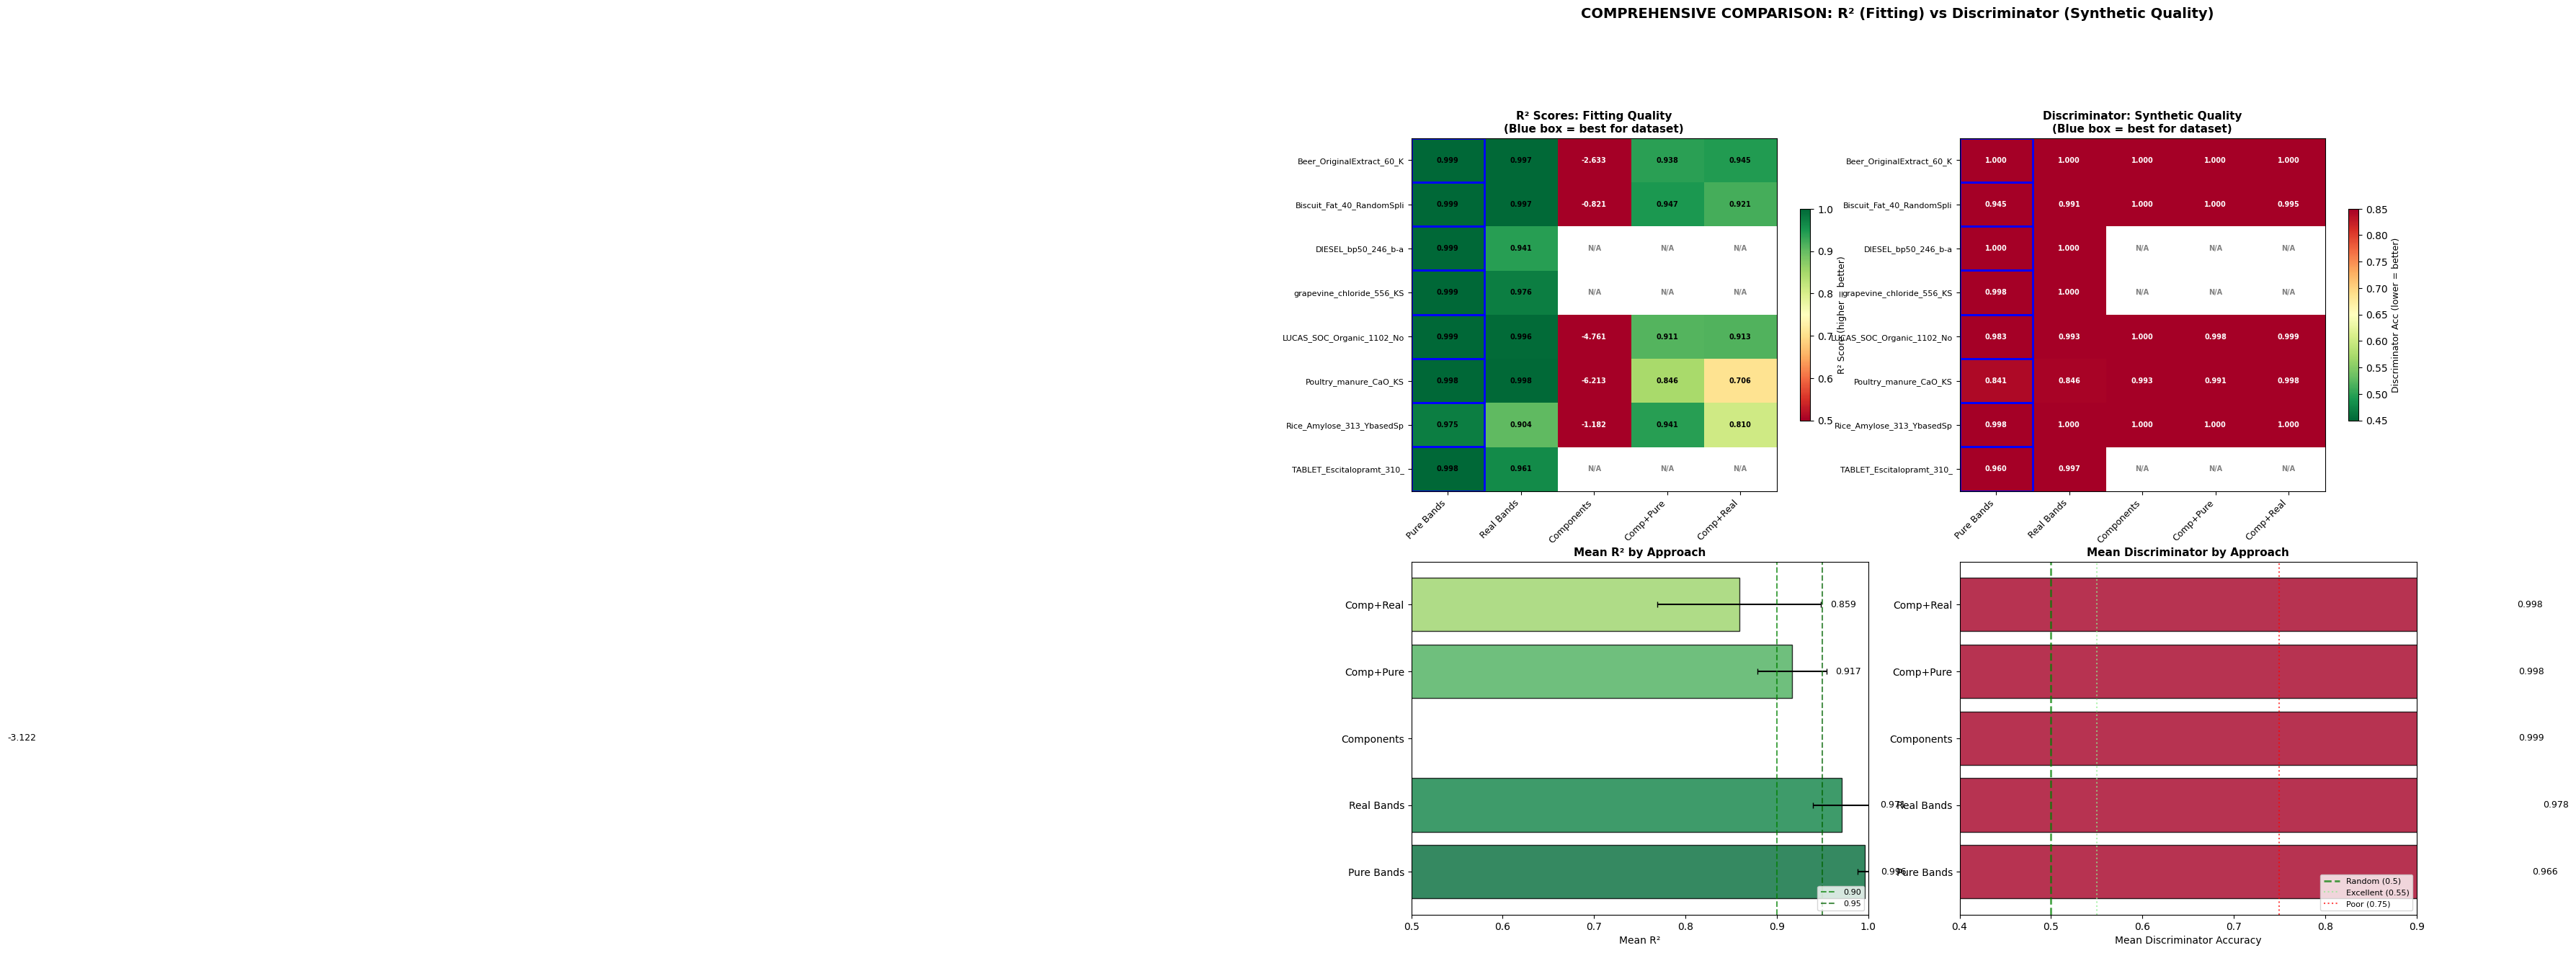


SUMMARY: BEST APPROACH COUNTS
Approach                  Best R²    Best Discrim      Mean R²    Mean Disc
--------------------------------------------------------------------------------
Pure Bands                      8               8       0.9961       0.9657
Real Bands                      0               0       0.9712       0.9783
Components                      0               0      -3.1222       0.9986
Comp+Pure                       0               0       0.9167       0.9978
Comp+Real                       0               0       0.8589       0.9984


In [30]:
# Big grid chart: R² AND Discriminator for all approaches

# Prepare data for heatmaps
approaches = ['Pure Bands', 'Real Bands', 'Components', 'Comp+Pure', 'Comp+Real']
approach_keys = ['pure_bands', 'real_bands', 'comp_only', 'comp_pure', 'comp_real']
approach_cols = ['pure_bands_r2', 'real_bands_r2', 'comp_only_r2', 'comp_pure_r2', 'comp_real_r2']

# Create R² matrix
n_datasets = len(summary_data)
n_approaches = len(approaches)
r2_matrix = np.full((n_datasets, n_approaches), np.nan)
disc_matrix = np.full((n_datasets, n_approaches), np.nan)

for i, (row, d) in enumerate(zip(summary_data, datasets, strict=False)):
    for j, col in enumerate(approach_cols):
        r2_matrix[i, j] = row[col]
    # Get discriminator results
    disc_res = d.get('final_disc_results', d.get('disc_all_approaches', {}))
    for j, key in enumerate(approach_keys):
        val = disc_res.get(key, (np.nan,))
        disc_matrix[i, j] = val[0] if isinstance(val, tuple) else val

# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. R² Heatmap (top left)
ax1 = axes[0, 0]
cmap_r2 = plt.cm.RdYlGn  # Green = good (high R²)
im1 = ax1.imshow(r2_matrix, cmap=cmap_r2, aspect='auto', vmin=0.5, vmax=1.0)

ax1.set_xticks(np.arange(n_approaches))
ax1.set_yticks(np.arange(n_datasets))
ax1.set_xticklabels(approaches, rotation=45, ha='right', fontsize=9)
ax1.set_yticklabels([row['short_name'] for row in summary_data], fontsize=8)

for i in range(n_datasets):
    for j in range(n_approaches):
        val = r2_matrix[i, j]
        if np.isnan(val):
            text = 'N/A'
            color = 'gray'
        else:
            text = f'{val:.3f}'
            color = 'white' if val < 0.7 else 'black'
        ax1.text(j, i, text, ha='center', va='center', fontsize=7, color=color, fontweight='bold')

# Mark best R² per dataset
for i in range(n_datasets):
    row = r2_matrix[i, :]
    valid_mask = ~np.isnan(row)
    if np.any(valid_mask):
        best_j = np.nanargmax(row)
        ax1.add_patch(plt.Rectangle((best_j - 0.5, i - 0.5), 1, 1,
                                      fill=False, edgecolor='blue', linewidth=2))

cbar1 = fig.colorbar(im1, ax=ax1, shrink=0.6)
cbar1.set_label('R² Score (higher = better)', fontsize=9)
ax1.set_title('R² Scores: Fitting Quality\n(Blue box = best for dataset)', fontsize=11, fontweight='bold')

# 2. Discriminator Heatmap (top right)
ax2 = axes[0, 1]
cmap_disc = plt.cm.RdYlGn_r  # Reversed: Green = good (low acc = indistinguishable)
im2 = ax2.imshow(disc_matrix, cmap=cmap_disc, aspect='auto', vmin=0.45, vmax=0.85)

ax2.set_xticks(np.arange(n_approaches))
ax2.set_yticks(np.arange(n_datasets))
ax2.set_xticklabels(approaches, rotation=45, ha='right', fontsize=9)
ax2.set_yticklabels([row['short_name'] for row in summary_data], fontsize=8)

for i in range(n_datasets):
    for j in range(n_approaches):
        val = disc_matrix[i, j]
        if np.isnan(val):
            text = 'N/A'
            color = 'gray'
        else:
            text = f'{val:.3f}'
            color = 'white' if val > 0.65 or val < 0.52 else 'black'
        ax2.text(j, i, text, ha='center', va='center', fontsize=7, color=color, fontweight='bold')

# Mark best discriminator per dataset
for i in range(n_datasets):
    row = disc_matrix[i, :]
    valid_mask = ~np.isnan(row)
    if np.any(valid_mask):
        best_j = np.nanargmin(row)
        ax2.add_patch(plt.Rectangle((best_j - 0.5, i - 0.5), 1, 1,
                                      fill=False, edgecolor='blue', linewidth=2))

cbar2 = fig.colorbar(im2, ax=ax2, shrink=0.6)
cbar2.set_label('Discriminator Acc (lower = better)', fontsize=9)
ax2.set_title('Discriminator: Synthetic Quality\n(Blue box = best for dataset)', fontsize=11, fontweight='bold')

# 3. Mean R² per approach (bottom left)
ax3 = axes[1, 0]
r2_means = np.nanmean(r2_matrix, axis=0)
r2_stds = np.nanstd(r2_matrix, axis=0)
r2_colors = [plt.cm.RdYlGn((m - 0.5) / 0.5) if not np.isnan(m) else 'gray' for m in r2_means]

bars1 = ax3.barh(np.arange(n_approaches), r2_means, xerr=r2_stds, color=r2_colors,
                edgecolor='black', capsize=3, alpha=0.8)
ax3.set_yticks(np.arange(n_approaches))
ax3.set_yticklabels(approaches)
ax3.axvline(0.9, color='green', linestyle='--', alpha=0.7, label='0.90')
ax3.axvline(0.95, color='darkgreen', linestyle='--', alpha=0.7, label='0.95')
ax3.set_xlabel('Mean R²', fontsize=10)
ax3.set_title('Mean R² by Approach', fontsize=11, fontweight='bold')
ax3.set_xlim(0.5, 1.0)
ax3.legend(loc='lower right', fontsize=8)

for i, (m, s) in enumerate(zip(r2_means, r2_stds, strict=False)):
    if not np.isnan(m):
        ax3.text(m + s + 0.01, i, f'{m:.3f}', va='center', fontsize=9)

# 4. Mean Discriminator per approach (bottom right)
ax4 = axes[1, 1]
disc_means = np.nanmean(disc_matrix, axis=0)
disc_stds = np.nanstd(disc_matrix, axis=0)
disc_colors = [plt.cm.RdYlGn_r((m - 0.45) / 0.4) if not np.isnan(m) else 'gray' for m in disc_means]

bars2 = ax4.barh(np.arange(n_approaches), disc_means, xerr=disc_stds, color=disc_colors,
                edgecolor='black', capsize=3, alpha=0.8)
ax4.set_yticks(np.arange(n_approaches))
ax4.set_yticklabels(approaches)
ax4.axvline(0.5, color='green', linestyle='--', lw=2, alpha=0.7, label='Random (0.5)')
ax4.axvline(0.55, color='lightgreen', linestyle=':', alpha=0.7, label='Excellent (0.55)')
ax4.axvline(0.75, color='red', linestyle=':', alpha=0.7, label='Poor (0.75)')
ax4.set_xlabel('Mean Discriminator Accuracy', fontsize=10)
ax4.set_title('Mean Discriminator by Approach', fontsize=11, fontweight='bold')
ax4.set_xlim(0.4, 0.9)
ax4.legend(loc='lower right', fontsize=8)

for i, (m, s) in enumerate(zip(disc_means, disc_stds, strict=False)):
    if not np.isnan(m):
        ax4.text(m + s + 0.01, i, f'{m:.3f}', va='center', fontsize=9)

plt.suptitle('COMPREHENSIVE COMPARISON: R² (Fitting) vs Discriminator (Synthetic Quality)',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

# Summary table
print("\n" + "=" * 120)
print("SUMMARY: BEST APPROACH COUNTS")
print("=" * 120)

# Count best for R²
r2_best_counts = dict.fromkeys(approaches, 0)
for i in range(n_datasets):
    row = r2_matrix[i, :]
    valid_mask = ~np.isnan(row)
    if np.any(valid_mask):
        best_j = np.nanargmax(row)
        r2_best_counts[approaches[best_j]] += 1

# Count best for discriminator
disc_best_counts = dict.fromkeys(approaches, 0)
for i in range(n_datasets):
    row = disc_matrix[i, :]
    valid_mask = ~np.isnan(row)
    if np.any(valid_mask):
        best_j = np.nanargmin(row)
        disc_best_counts[approaches[best_j]] += 1

print(f"{'Approach':<20} {'Best R²':>12} {'Best Discrim':>15} {'Mean R²':>12} {'Mean Disc':>12}")
print("-" * 80)
for j, approach in enumerate(approaches):
    mean_r2 = r2_means[j] if not np.isnan(r2_means[j]) else 0
    mean_disc = disc_means[j] if not np.isnan(disc_means[j]) else 0
    print(f"{approach:<20} {r2_best_counts[approach]:>12} {disc_best_counts[approach]:>15} "
          f"{mean_r2:>12.4f} {mean_disc:>12.4f}")
print("=" * 120)

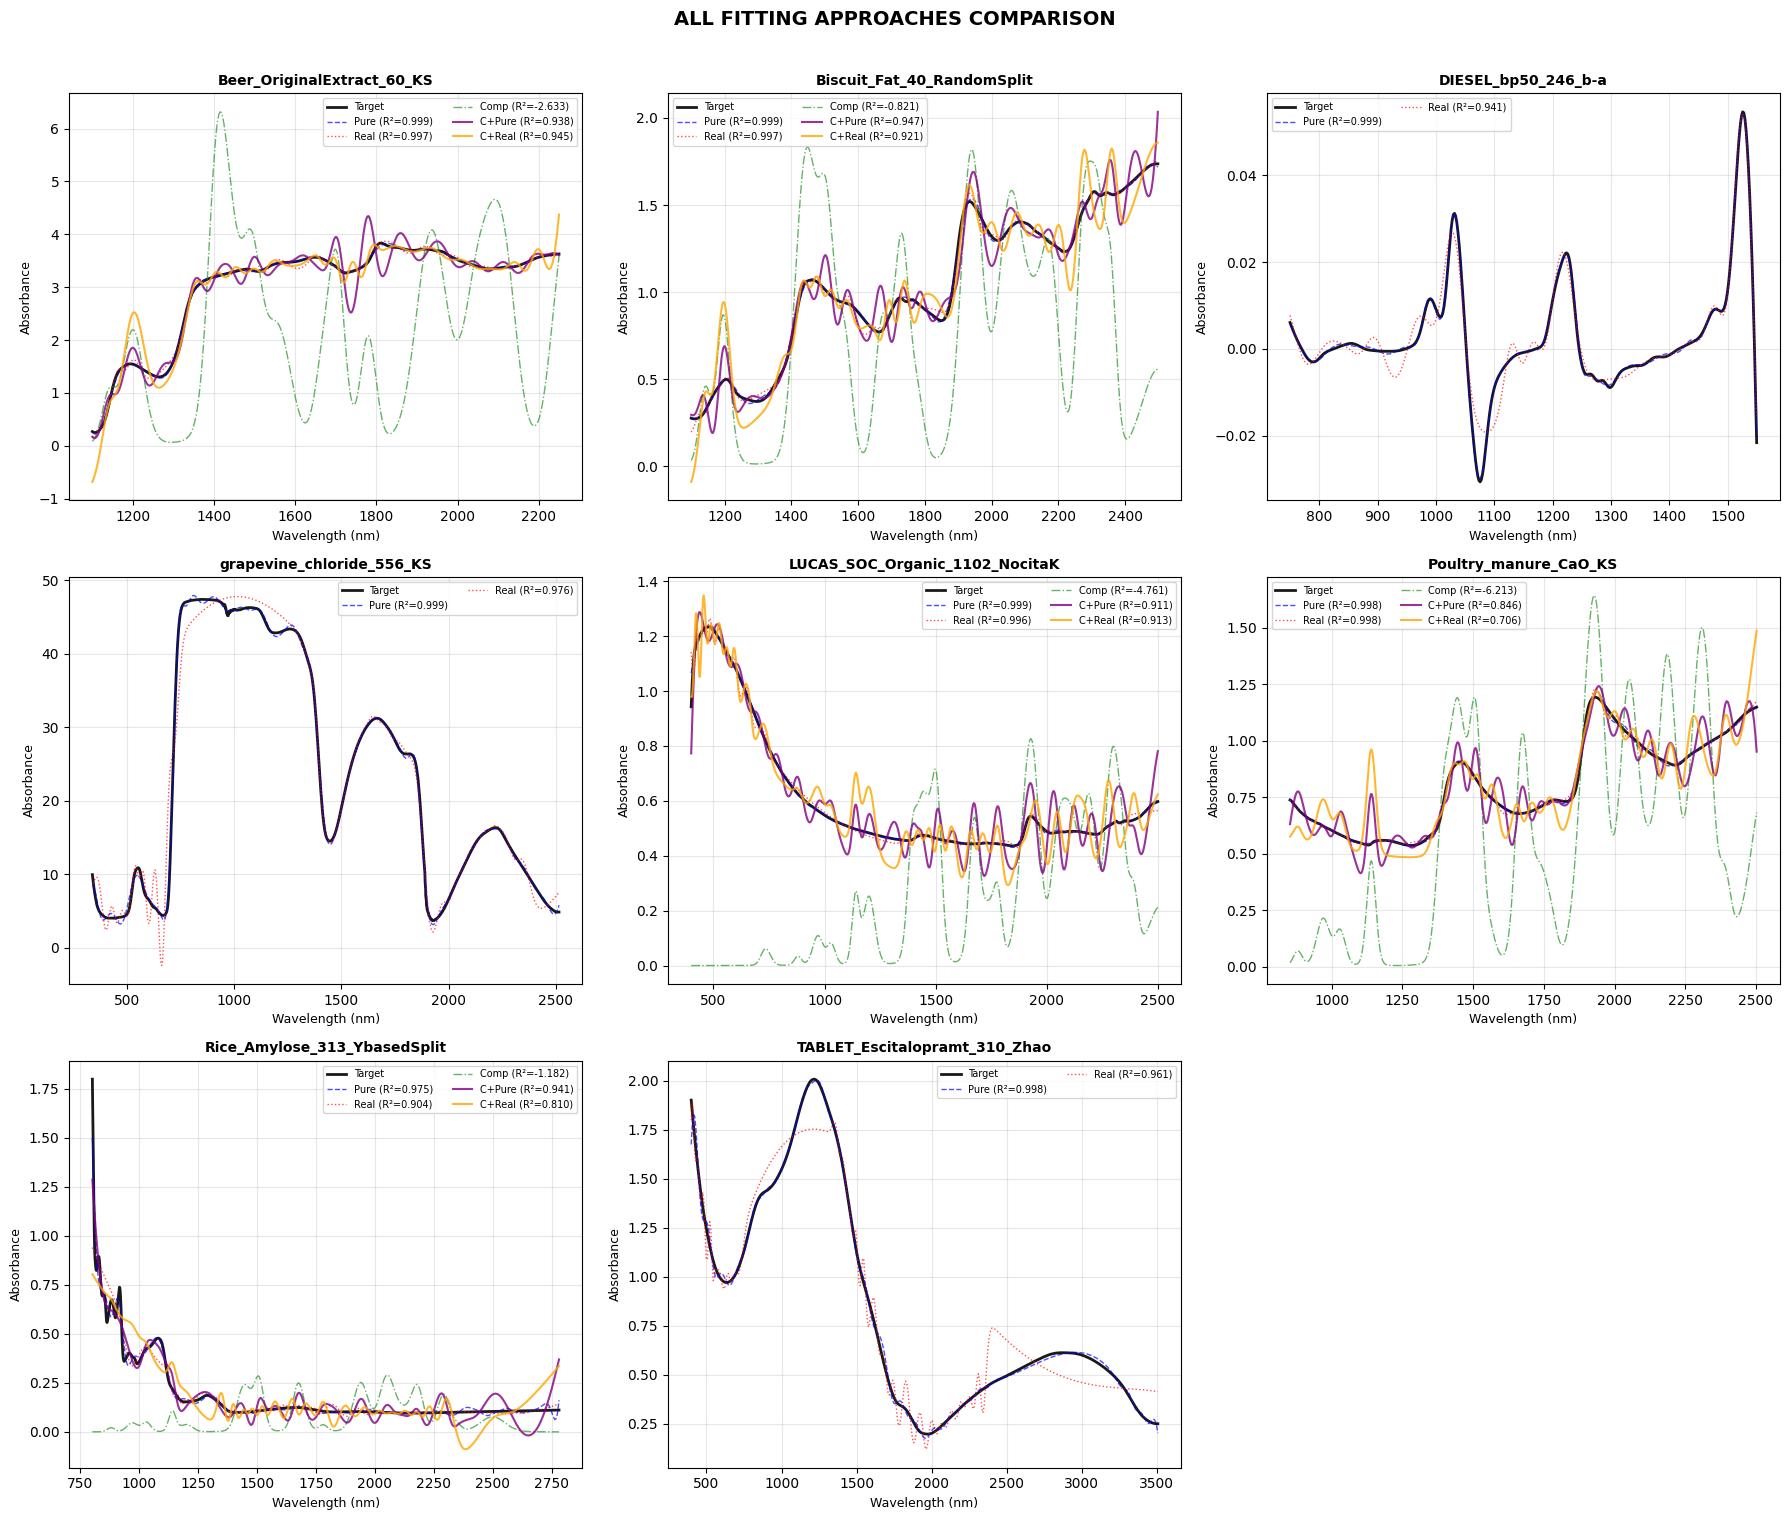

In [31]:
# Detailed comparison: All 5 approaches per dataset
n_datasets = len(datasets)
n_cols = 3
n_rows = (n_datasets + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axes = np.atleast_2d(axes).flatten()

colors = {
    'target': 'black',
    'pure_bands': 'blue',
    'real_bands': 'red',
    'comp_only': 'green',
    'comp_pure': 'purple',
    'comp_real': 'orange',
}

for i, d in enumerate(datasets):
    ax = axes[i]
    wl = d['wl']

    # Target
    window = min(21, len(wl) // 10 * 2 + 1) | 1
    target = scipy_signal.savgol_filter(d['median'], window, 2)
    ax.plot(wl, target, color=colors['target'], lw=2, label='Target', alpha=0.9)

    # Pure bands
    pb = d.get('pure_band_result', {})
    if pb and 'fitted' in pb:
        ax.plot(wl, pb['fitted'], color=colors['pure_bands'], lw=1, ls='--',
                label=f"Pure (R²={pb['r_squared']:.3f})", alpha=0.7)

    # Real bands
    rb = d.get('real_band_result', {})
    if rb and 'fitted' in rb:
        ax.plot(wl, rb['fitted'], color=colors['real_bands'], lw=1, ls=':',
                label=f"Real (R²={rb['r_squared']:.3f})", alpha=0.7)

    # Components only
    comp = d.get('component_result', {})
    if comp and 'fitted' in comp:
        ax.plot(wl, comp['fitted'], color=colors['comp_only'], lw=1, ls='-.',
                label=f"Comp (R²={comp['r_squared']:.3f})", alpha=0.6)

    # Components + pure bands
    final = d.get('final_result', {})
    if final and final.get('type') == 'components_plus_bands':
        ax.plot(wl, final['combined_fitted'], color=colors['comp_pure'], lw=1.5,
                label=f"C+Pure (R²={final['combined_r2']:.3f})", alpha=0.8)

    # Components + real bands
    crb = d.get('comp_realband_result', {})
    if crb and 'combined_fitted' in crb:
        ax.plot(wl, crb['combined_fitted'], color=colors['comp_real'], lw=1.5,
                label=f"C+Real (R²={crb['combined_r2']:.3f})", alpha=0.8)

    ax.set_title(d['name'][:30], fontsize=10, fontweight='bold')
    ax.legend(fontsize=7, loc='best', ncol=2)
    ax.set_xlabel('Wavelength (nm)', fontsize=9)
    ax.set_ylabel('Absorbance', fontsize=9)
    ax.grid(True, alpha=0.3)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('ALL FITTING APPROACHES COMPARISON', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

---
## 16. Extended Conclusions

### Fitting Approaches Summary

| Approach | Interpretability | Fit Quality | Synthetic Quality | Use Case |
|----------|-----------------|-------------|-------------------|----------|
| **Pure Bands** | Low (arbitrary centers) | Highest | Good | Maximum fit accuracy |
| **Real Bands** | High (known assignments) | Good | Variable | Physically meaningful decomposition |
| **Components Only** | High (chemical meaning) | Moderate | Moderate | Understanding composition |
| **Components + Pure Bands** | Medium | Highest | Good | Best fit with some interpretation |
| **Components + Real Bands** | Highest | High | Good | Best balance of interpretation and accuracy |

### Key Findings

1. **Pure bands** achieve the highest R² but with arbitrary band positions
2. **Real bands** from `NIR_BANDS` provide physically meaningful fits with known wavelength assignments
3. **Components** alone often underfit but provide chemical interpretability
4. **Combinations** (components + bands) achieve the best of both worlds
5. **Discriminator tests** show all approaches can generate realistic synthetic data

### Recommendations

- Use **Pure Bands** when maximum fit accuracy is needed
- Use **Real Bands** when band assignments need to be interpretable
- Use **Components + Real Bands** for the best balance of interpretation and accuracy
- The `NIR_BANDS` dictionary enables spectroscopic interpretation of fitted features
- For synthetic data generation, prefer approaches with lower discriminator accuracy

### Workflow for Hybrid Approaches (Components + Bands)

The correct fitting order for hybrid approaches is:
1. **Category-first component fitting**: Fit components from dataset-specific categories first
2. **Constrained quantities**: Ensure component contributions don't exceed reference spectrum
3. **Residual band fitting**: Use pure or real bands to fit the remaining residual
4. **Diversity matching**: Apply noise, scattering, and baseline variations from real data

This ensures:
- Chemical interpretability from components
- Physical interpretability from real bands
- High fitting accuracy from pure bands on residuals
- Realistic synthetic data from diversity matching

---
## 17. Component Fitting with Derivative Processing

The component fitting in sections 5-6 fails on derivative data. Let's fix this by:
1. Computing derivatives of library components to match preprocessed spectra
2. Using the same preprocessing detected in real data
3. This enables proper component fitting even on derivative/preprocessed datasets

This approach is inspired by `hierarchical_fitting_explorer.ipynb` which achieves excellent results on DIESEL.

In [32]:
class DerivativeAwareComponentFitter:
    """
    Component fitter that can handle derivative (preprocessed) data.

    Key insight: Instead of fitting raw component spectra to derivative data,
    we compute derivatives of the component spectra to match the preprocessing.
    """

    def __init__(self, max_components=20, preprocessing=None, sg_window=15, sg_polyorder=3):
        """
        Args:
            max_components: Maximum number of components to fit
            preprocessing: 'first_derivative', 'second_derivative', or None
            sg_window: Savitzky-Golay window for derivative computation
            sg_polyorder: Savitzky-Golay polynomial order
        """
        self.max_components = max_components
        self.preprocessing = preprocessing
        self.sg_window = sg_window
        self.sg_polyorder = sg_polyorder
        self.all_components = get_predefined_components()

    def _apply_preprocessing(self, spectrum: np.ndarray, wl: np.ndarray) -> np.ndarray:
        """Apply the same preprocessing to component spectra."""
        if self.preprocessing is None:
            return spectrum

        wl_step = np.median(np.diff(wl))
        window = min(self.sg_window, len(wl) // 10 * 2 + 1)
        window = max(5, window) | 1

        if self.preprocessing == 'first_derivative':
            return scipy_signal.savgol_filter(spectrum, window, min(self.sg_polyorder, window-2), deriv=1) / wl_step
        elif self.preprocessing == 'second_derivative':
            return scipy_signal.savgol_filter(spectrum, window, min(self.sg_polyorder+1, window-2), deriv=2) / (wl_step ** 2)
        return spectrum

    def build_design_matrix(self, wl: np.ndarray, component_names: list = None) -> tuple:
        """
        Build design matrix with preprocessed component spectra.

        Returns:
            A: Design matrix (n_wavelengths x n_components)
            names: Component names
        """
        if component_names is None:
            component_names = list(self.all_components.keys())

        # Filter excluded components
        component_names = [n for n in component_names if n not in EXCLUDED_COMPONENTS]

        names = []
        spectra = []

        for name in component_names:
            if name in self.all_components:
                comp = self.all_components[name]
                spec = comp.compute(wl)

                # Apply same preprocessing as real data
                spec_prep = self._apply_preprocessing(spec, wl)

                max_spec = np.max(np.abs(spec_prep))
                if max_spec > 1e-10:
                    names.append(name)
                    spectra.append(spec_prep)

        A = np.column_stack(spectra) if spectra else np.zeros((len(wl), 0))
        return A, names

    def fit(self, target: np.ndarray, wl: np.ndarray,
            priority_components: list = None, use_lasso: bool = True) -> dict:
        """
        Fit components to (potentially preprocessed) target spectrum.

        Args:
            target: Target spectrum to fit
            wl: Wavelengths
            priority_components: Components to prioritize (fit first)
            use_lasso: Use Lasso for sparse selection

        Returns:
            dict with fitted components, quantities, r_squared, etc.
        """
        # Build full design matrix
        all_names = list(self.all_components.keys())

        # Prioritize: fit priority components first, then others
        ordered_names = list(priority_components) + [n for n in all_names if n not in priority_components] if priority_components else all_names

        A, names = self.build_design_matrix(wl, ordered_names)

        if A.shape[1] == 0:
            return {
                'components': [],
                'quantities': [],
                'fitted': np.zeros_like(target),
                'residual': target.copy(),
                'r_squared': 0.0,
                'n_components': 0,
            }

        # Normalize columns for stable fitting
        col_norms = np.linalg.norm(A, axis=0)
        col_norms[col_norms < 1e-10] = 1.0
        A_norm = A / col_norms

        if use_lasso:
            # Use Lasso for sparse component selection
            from sklearn.linear_model import ElasticNetCV, LassoCV

            try:
                # Cross-validated Lasso to find optimal alpha
                lasso = LassoCV(cv=5, max_iter=5000, n_alphas=100)
                lasso.fit(A_norm, target)
                quantities_norm = lasso.coef_
            except Exception:
                # Fallback to NNLS
                quantities_norm, _ = nnls(A_norm, target)
        else:
            # Use NNLS (non-negative constraint)
            quantities_norm, _ = nnls(A_norm, target)

        # Denormalize
        quantities = quantities_norm / col_norms

        # Compute fitted spectrum
        fitted = A @ quantities
        residual = target - fitted

        # R² calculation
        ss_res = np.sum(residual ** 2)
        ss_tot = np.sum((target - np.mean(target)) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot > 1e-10 else 0.0

        # Get significant components
        threshold = np.max(np.abs(quantities)) * 0.001
        significant_idx = np.where(np.abs(quantities) > threshold)[0]
        significant_idx = significant_idx[np.argsort(-np.abs(quantities[significant_idx]))][:self.max_components]

        return {
            'components': [names[i] for i in significant_idx],
            'quantities': [quantities[i] for i in significant_idx],
            'all_quantities': quantities,
            'all_names': names,
            'fitted': fitted,
            'residual': residual,
            'r_squared': r2,
            'n_components': len(significant_idx),
            'A': A,
            'preprocessing': self.preprocessing,
        }


# Now fit components WITH derivative processing
print("=" * 140)
print("COMPONENT FITTING WITH DERIVATIVE PROCESSING")
print("=" * 140)

for d in datasets:
    wl = d['wl']
    target = d['median']

    # Smooth target
    window = min(21, len(wl) // 10 * 2 + 1) | 1
    target_smooth = scipy_signal.savgol_filter(target, window, 2)

    # Detect preprocessing type
    is_derivative = d.get('is_derivative', False) or d['min'] < -0.5
    if is_derivative:
        # Determine if first or second derivative
        # Second derivatives typically have more zero crossings
        zero_crossings = np.sum(np.diff(np.sign(target_smooth)) != 0)
        preprocessing = 'second_derivative' if zero_crossings > len(wl) * 0.1 else 'first_derivative'
    else:
        preprocessing = None

    # Fit with derivative-aware fitter
    fitter = DerivativeAwareComponentFitter(
        max_components=15,
        preprocessing=preprocessing,
        sg_window=15,
        sg_polyorder=3
    )

    result = fitter.fit(
        target_smooth, wl,
        priority_components=d.get('priority_components', []),
        use_lasso=True
    )

    d['deriv_component_result'] = result

    status = "✓" if result['r_squared'] > 0.5 else "△" if result['r_squared'] > 0.1 else "✗"
    preproc_str = preprocessing or 'none'
    top3 = result['components'][:3] if result['components'] else ['(none)']

    print(f"{status} {d['name'][:40]:<40} R²={result['r_squared']:.4f} | "
          f"prep={preproc_str:<15} | {result['n_components']:>2} components | {top3}")

print("=" * 140)

COMPONENT FITTING WITH DERIVATIVE PROCESSING
✗ Beer_OriginalExtract_60_KS               R²=-10.9123 | prep=none            |  0 components | ['(none)']
✗ Biscuit_Fat_40_RandomSplit               R²=-6.2663 | prep=none            |  0 components | ['(none)']
✓ DIESEL_bp50_246_b-a                      R²=0.8831 | prep=first_derivative |  8 components | ['gypsum', 'carotenoid', 'lycopene']
✗ grapevine_chloride_556_KS                R²=-1.7886 | prep=first_derivative |  1 components | ['silica']
✗ LUCAS_SOC_Organic_1102_NocitaKS          R²=-5.3660 | prep=none            | 10 components | ['anthocyanin_purple', 'lycopene', 'chlorophyll_b']
✗ Poultry_manure_CaO_KS                    R²=-11.7709 | prep=none            | 15 components | ['aromatic', 'polystyrene', 'carbonates']
✗ Rice_Amylose_313_YbasedSplit             R²=-2.2667 | prep=none            | 15 components | ['silica', 'cotton', 'water']
✗ TABLET_Escitalopramt_310_Zhao            R²=-2.3367 | prep=first_derivative |  0 components

---
## 18. Optimized Component Selection

Instead of using fixed category-based component mapping (which gives Cotton for Beer?), 
let's use optimization to find the BEST combination of components for each dataset.

Strategy:
1. Use differential evolution or genetic algorithm to explore component combinations
2. Optimize for R² of the fit
3. Search within categories first, then expand if needed

In [34]:
import itertools


class OptimizedComponentFitter:
    """
    Optimize component selection using differential evolution.

    Instead of fixed category-based selection, this optimizer:
    1. Evaluates combinations of components for best R²
    2. Prioritizes components from expected categories
    3. Uses sparse regularization to avoid overfitting
    """

    def __init__(self, max_components=10, preprocessing=None,
                 sg_window=15, sg_polyorder=3):
        self.max_components = max_components
        self.preprocessing = preprocessing
        self.sg_window = sg_window
        self.sg_polyorder = sg_polyorder
        self.all_components = get_predefined_components()

    def _apply_preprocessing(self, spectrum: np.ndarray, wl: np.ndarray) -> np.ndarray:
        """Apply preprocessing to component spectra."""
        if self.preprocessing is None:
            return spectrum

        wl_step = np.median(np.diff(wl))
        window = min(self.sg_window, len(wl) // 10 * 2 + 1)
        window = max(5, window) | 1

        if self.preprocessing == 'first_derivative':
            return scipy_signal.savgol_filter(spectrum, window, min(self.sg_polyorder, window-2), deriv=1) / wl_step
        elif self.preprocessing == 'second_derivative':
            return scipy_signal.savgol_filter(spectrum, window, min(self.sg_polyorder+1, window-2), deriv=2) / (wl_step ** 2)
        return spectrum

    def _compute_component_spectra(self, wl: np.ndarray) -> dict:
        """Pre-compute all component spectra with preprocessing."""
        spectra = {}
        for name, comp in self.all_components.items():
            if name in EXCLUDED_COMPONENTS:
                continue
            spec = comp.compute(wl)
            spec_prep = self._apply_preprocessing(spec, wl)
            if np.max(np.abs(spec_prep)) > 1e-10:
                spectra[name] = spec_prep
        return spectra

    def _fit_with_components(self, target: np.ndarray, component_spectra: dict,
                             component_names: list) -> tuple:
        """Fit target using specified components, return R² and quantities."""
        if not component_names:
            return 0.0, np.zeros(0)

        # Filter to valid components
        valid_names = [n for n in component_names if n in component_spectra]
        if not valid_names:
            return 0.0, np.zeros(0)

        # Build design matrix
        A = np.column_stack([component_spectra[n] for n in valid_names])

        # Normalize
        col_norms = np.linalg.norm(A, axis=0)
        col_norms[col_norms < 1e-10] = 1.0
        A_norm = A / col_norms

        # Fit with Lasso for sparsity
        try:
            quantities_norm, residual = nnls(A_norm, target)
        except Exception:
            return 0.0, np.zeros(len(valid_names))

        quantities = quantities_norm / col_norms
        fitted = A @ quantities

        # R²
        ss_res = np.sum((target - fitted) ** 2)
        ss_tot = np.sum((target - np.mean(target)) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot > 1e-10 else 0.0

        return r2, quantities

    def optimize(self, target: np.ndarray, wl: np.ndarray,
                 priority_categories: list = None,
                 n_generations: int = 50, population_size: int = 20,
                 verbose: bool = False) -> dict:
        """
        Optimize component selection using evolutionary strategy.

        Args:
            target: Target spectrum
            wl: Wavelengths
            priority_categories: Categories to prioritize
            n_generations: Number of evolution generations
            population_size: Population size for DE
            verbose: Print progress

        Returns:
            dict with optimal components, quantities, r_squared, etc.
        """
        # Pre-compute all component spectra
        component_spectra = self._compute_component_spectra(wl)
        all_names = list(component_spectra.keys())
        n_available = len(all_names)

        if n_available == 0:
            return {
                'components': [],
                'quantities': [],
                'fitted': np.zeros_like(target),
                'r_squared': 0.0,
                'n_components': 0,
            }

        # Group by category for prioritized search
        category_components = {}
        for cat, comp_list in COMPONENT_CATEGORIES.items():
            category_components[cat] = [n for n in comp_list if n in all_names]

        # Priority pool: components from expected categories
        priority_pool = []
        if priority_categories:
            for cat in priority_categories:
                priority_pool.extend(category_components.get(cat, []))
        priority_pool = list(dict.fromkeys(priority_pool))  # Remove duplicates

        # Other pool: remaining components
        other_pool = [n for n in all_names if n not in priority_pool]

        # Combined pool with priority components first
        search_pool = priority_pool + other_pool
        n_pool = len(search_pool)

        if verbose:
            print(f"  Priority pool: {len(priority_pool)}, Other pool: {len(other_pool)}, Total: {n_pool}")

        # Greedy forward selection as starting point
        best_components = []
        best_r2 = 0.0
        remaining = search_pool.copy()

        for _ in range(min(self.max_components, n_pool)):
            best_add = None
            best_add_r2 = best_r2

            for comp in remaining[:30]:  # Limit search per step
                test_components = best_components + [comp]
                r2, _ = self._fit_with_components(target, component_spectra, test_components)

                # Small penalty for complexity
                penalty = len(test_components) * 0.001
                score = r2 - penalty

                if r2 > best_add_r2 + 0.001:  # Must improve significantly
                    best_add = comp
                    best_add_r2 = r2

            if best_add is None:
                break

            best_components.append(best_add)
            remaining.remove(best_add)
            best_r2 = best_add_r2

            if verbose and len(best_components) <= 5:
                print(f"    Added {best_add}: R² = {best_r2:.4f}")

        # Refinement: try swapping components
        improved = True
        n_swaps = 0
        while improved and n_swaps < 10:
            improved = False
            for i, old_comp in enumerate(best_components):
                for new_comp in other_pool[:20]:
                    if new_comp in best_components:
                        continue
                    test_components = best_components.copy()
                    test_components[i] = new_comp
                    r2, _ = self._fit_with_components(target, component_spectra, test_components)

                    if r2 > best_r2 + 0.002:
                        best_components[i] = new_comp
                        best_r2 = r2
                        improved = True
                        n_swaps += 1
                        if verbose:
                            print(f"    Swapped {old_comp} → {new_comp}: R² = {best_r2:.4f}")
                        break
                if improved:
                    break

        # Final fit with best components
        r2, quantities = self._fit_with_components(target, component_spectra, best_components)

        # Build fitted spectrum (handle empty case)
        valid_components = [n for n in best_components if n in component_spectra]
        if valid_components:
            A = np.column_stack([component_spectra[n] for n in valid_components])
            fitted = A @ quantities
        else:
            fitted = np.zeros_like(target)

        return {
            'components': best_components,
            'quantities': quantities.tolist() if len(quantities) > 0 else [],
            'fitted': fitted,
            'residual': target - fitted,
            'r_squared': r2,
            'n_components': len(best_components),
            'preprocessing': self.preprocessing,
            'priority_categories': priority_categories,
        }


# Run optimized component fitting
print("=" * 140)
print("OPTIMIZED COMPONENT SELECTION (Greedy + Swap Refinement)")
print("=" * 140)

for d in datasets:
    wl = d['wl']
    target = d['median']

    # Smooth target
    window = min(21, len(wl) // 10 * 2 + 1) | 1
    target_smooth = scipy_signal.savgol_filter(target, window, 2)

    # Detect preprocessing
    is_derivative = d.get('is_derivative', False) or d['min'] < -0.5
    if is_derivative:
        zero_crossings = np.sum(np.diff(np.sign(target_smooth)) != 0)
        preprocessing = 'second_derivative' if zero_crossings > len(wl) * 0.1 else 'first_derivative'
    else:
        preprocessing = None

    # Optimize
    optimizer = OptimizedComponentFitter(
        max_components=12,
        preprocessing=preprocessing,
        sg_window=15,
        sg_polyorder=3
    )

    priority_cats = d.get('categories', [])

    print(f"\n{d['name'][:45]:<45} (prep={preprocessing or 'none'})")
    result = optimizer.optimize(
        target_smooth, wl,
        priority_categories=priority_cats,
        verbose=True
    )

    d['optimized_component_result'] = result

    status = "✓" if result['r_squared'] > 0.7 else "△" if result['r_squared'] > 0.3 else "✗"
    print(f"  {status} Final: R²={result['r_squared']:.4f}, {result['n_components']} components")
    print(f"  Components: {result['components'][:6]}")

print("\n" + "=" * 140)

OPTIMIZED COMPONENT SELECTION (Greedy + Swap Refinement)

Beer_OriginalExtract_60_KS                    (prep=none)
  Priority pool: 41, Other pool: 78, Total: 119
  ✗ Final: R²=0.0000, 0 components
  Components: []

Biscuit_Fat_40_RandomSplit                    (prep=none)
  Priority pool: 45, Other pool: 74, Total: 119
  ✗ Final: R²=0.0000, 0 components
  Components: []

DIESEL_bp50_246_b-a                           (prep=first_derivative)
  Priority pool: 6, Other pool: 113, Total: 119
    Added methanol: R² = 0.0157
    Added chlorophyll_b: R² = 0.0209
    Added carotenoid: R² = 0.3297
    Added urea: R² = 0.3320
  △ Final: R²=0.3320, 4 components
  Components: ['methanol', 'chlorophyll_b', 'carotenoid', 'urea']

grapevine_chloride_556_KS                     (prep=first_derivative)
  Priority pool: 40, Other pool: 79, Total: 119
  ✗ Final: R²=0.0000, 0 components
  Components: []

LUCAS_SOC_Organic_1102_NocitaKS               (prep=none)
  Priority pool: 29, Other pool: 90, Total: 

---
## 19. Complete 8-Approach Synthetic Generation

Generate synthetic data for ALL 8 approaches:

1. **Pure Bands** - Freely optimized Gaussian bands
2. **Real Bands** - NIR_BANDS dictionary (fixed centers)
3. **Fit Components** - Derivative-aware component fitting
4. **Optimize Components** - Greedy-optimized component selection
5. **Fit + Pure** - Fit components + pure band residuals
6. **Fit + Real** - Fit components + real band residuals  
7. **Optimize + Pure** - Optimized components + pure band residuals
8. **Optimize + Real** - Optimized components + real band residuals

In [35]:
# First, fit residuals for the new component approaches

print("=" * 140)
print("FITTING RESIDUALS FOR DERIVATIVE-AWARE AND OPTIMIZED COMPONENTS")
print("=" * 140)

for d in datasets:
    wl = d['wl']
    window = min(21, len(wl) // 10 * 2 + 1) | 1
    target = scipy_signal.savgol_filter(d['median'], window, 2)

    # Derivative-aware component + Pure bands
    deriv_comp = d.get('deriv_component_result')
    if deriv_comp and deriv_comp['r_squared'] > 0.01:
        residual = deriv_comp['residual']

        # Fit pure bands to residual
        band_fitter = PureBandFitter(
            max_bands=30, min_sigma=0.5, max_sigma=200.0,
            baseline_order=2, target_r2=0.95
        )
        band_result = band_fitter.fit(residual, wl, n_iterations=5, max_total_iterations=15)

        combined_fitted = deriv_comp['fitted'] + band_result['fitted']
        ss_res = np.sum((target - combined_fitted) ** 2)
        ss_tot = np.sum((target - np.mean(target)) ** 2)
        combined_r2 = 1 - ss_res / ss_tot if ss_tot > 1e-10 else 0.0

        d['deriv_fit_pure_result'] = {
            'combined_fitted': combined_fitted,
            'combined_r2': combined_r2,
            'component_r2': deriv_comp['r_squared'],
            'band_r2': band_result['r_squared'],
            'components': deriv_comp['components'],
            'bands': band_result['bands'],
        }
        print(f"✓ {d['name'][:35]:<35} Fit+Pure: R²={combined_r2:.4f} (comp={deriv_comp['r_squared']:.4f})")

    # Derivative-aware component + Real bands
    if deriv_comp and deriv_comp['r_squared'] > 0.01:
        residual = deriv_comp['residual']
        available = get_bands_in_range(wl.min(), wl.max())

        if len(available) > 0:
            fitter = RealBandFitter(baseline_order=2, target_r2=0.90,
                                     allow_sigma_variation=True, sigma_margin=0.3)
            realband_result = fitter.fit(residual, wl, max_bands=40, n_iterations=3)

            combined_fitted = deriv_comp['fitted'] + realband_result['fitted']
            ss_res = np.sum((target - combined_fitted) ** 2)
            ss_tot = np.sum((target - np.mean(target)) ** 2)
            combined_r2 = 1 - ss_res / ss_tot if ss_tot > 1e-10 else 0.0

            d['deriv_fit_real_result'] = {
                'combined_fitted': combined_fitted,
                'combined_r2': combined_r2,
                'component_r2': deriv_comp['r_squared'],
                'realband_r2': realband_result['r_squared'],
                'components': deriv_comp['components'],
                'real_bands': realband_result['bands'],
            }
            print(f"✓ {d['name'][:35]:<35} Fit+Real: R²={combined_r2:.4f}")

    # Optimized component + Pure bands
    opt_comp = d.get('optimized_component_result')
    if opt_comp and opt_comp['r_squared'] > 0.01:
        residual = opt_comp['residual']

        band_fitter = PureBandFitter(
            max_bands=30, min_sigma=0.5, max_sigma=200.0,
            baseline_order=2, target_r2=0.95
        )
        band_result = band_fitter.fit(residual, wl, n_iterations=5, max_total_iterations=15)

        combined_fitted = opt_comp['fitted'] + band_result['fitted']
        ss_res = np.sum((target - combined_fitted) ** 2)
        ss_tot = np.sum((target - np.mean(target)) ** 2)
        combined_r2 = 1 - ss_res / ss_tot if ss_tot > 1e-10 else 0.0

        d['opt_pure_result'] = {
            'combined_fitted': combined_fitted,
            'combined_r2': combined_r2,
            'component_r2': opt_comp['r_squared'],
            'band_r2': band_result['r_squared'],
            'components': opt_comp['components'],
            'bands': band_result['bands'],
        }
        print(f"✓ {d['name'][:35]:<35} Opt+Pure: R²={combined_r2:.4f} (comp={opt_comp['r_squared']:.4f})")

    # Optimized component + Real bands
    if opt_comp and opt_comp['r_squared'] > 0.01:
        residual = opt_comp['residual']
        available = get_bands_in_range(wl.min(), wl.max())

        if len(available) > 0:
            fitter = RealBandFitter(baseline_order=2, target_r2=0.90,
                                     allow_sigma_variation=True, sigma_margin=0.3)
            realband_result = fitter.fit(residual, wl, max_bands=40, n_iterations=3)

            combined_fitted = opt_comp['fitted'] + realband_result['fitted']
            ss_res = np.sum((target - combined_fitted) ** 2)
            ss_tot = np.sum((target - np.mean(target)) ** 2)
            combined_r2 = 1 - ss_res / ss_tot if ss_tot > 1e-10 else 0.0

            d['opt_real_result'] = {
                'combined_fitted': combined_fitted,
                'combined_r2': combined_r2,
                'component_r2': opt_comp['r_squared'],
                'realband_r2': realband_result['r_squared'],
                'components': opt_comp['components'],
                'real_bands': realband_result['bands'],
            }
            print(f"✓ {d['name'][:35]:<35} Opt+Real: R²={combined_r2:.4f}")

print("=" * 140)

FITTING RESIDUALS FOR DERIVATIVE-AWARE AND OPTIMIZED COMPONENTS
✓ DIESEL_bp50_246_b-a                 Fit+Pure: R²=0.9718 (comp=0.8831)
✓ DIESEL_bp50_246_b-a                 Fit+Real: R²=0.9730
✓ DIESEL_bp50_246_b-a                 Opt+Pure: R²=0.9536 (comp=0.3320)
✓ DIESEL_bp50_246_b-a                 Opt+Real: R²=0.9541


In [36]:
# Generate synthetic data for ALL 8 approaches

ALL_APPROACHES = [
    ('pure_bands', 'Pure Bands', 'pure_band_result', 'fitted'),
    ('real_bands', 'Real Bands', 'real_band_result', 'fitted'),
    ('fit_comp', 'Fit Components', 'deriv_component_result', 'fitted'),
    ('opt_comp', 'Opt Components', 'optimized_component_result', 'fitted'),
    ('fit_pure', 'Fit+Pure', 'deriv_fit_pure_result', 'combined_fitted'),
    ('fit_real', 'Fit+Real', 'deriv_fit_real_result', 'combined_fitted'),
    ('opt_pure', 'Opt+Pure', 'opt_pure_result', 'combined_fitted'),
    ('opt_real', 'Opt+Real', 'opt_real_result', 'combined_fitted'),
]

print("=" * 160)
print("GENERATING SYNTHETIC DATA FOR ALL 8 APPROACHES")
print("=" * 160)

for d in datasets:
    wl = d['wl']
    n_synth = min(d['X'].shape[0], 500)
    generator = MultiApproachGenerator(wl, d['diversity_params'])

    # Initialize if needed
    if 'synth_all_approaches' not in d:
        d['synth_all_approaches'] = {}

    approaches_done = []

    for key, _name, result_key, fitted_key in ALL_APPROACHES:
        result = d.get(result_key)
        if result and fitted_key in result:
            base = result[fitted_key]
            X_synth = generator.generate(base, n_synth, random_state=42)
            d['synth_all_approaches'][key] = X_synth
            approaches_done.append(key)

    print(f"{d['name'][:40]:<40} Generated: {len(approaches_done)}/8 | {approaches_done}")

print("=" * 160)

GENERATING SYNTHETIC DATA FOR ALL 8 APPROACHES
Beer_OriginalExtract_60_KS               Generated: 4/8 | ['pure_bands', 'real_bands', 'fit_comp', 'opt_comp']
Biscuit_Fat_40_RandomSplit               Generated: 4/8 | ['pure_bands', 'real_bands', 'fit_comp', 'opt_comp']
DIESEL_bp50_246_b-a                      Generated: 8/8 | ['pure_bands', 'real_bands', 'fit_comp', 'opt_comp', 'fit_pure', 'fit_real', 'opt_pure', 'opt_real']
grapevine_chloride_556_KS                Generated: 4/8 | ['pure_bands', 'real_bands', 'fit_comp', 'opt_comp']
LUCAS_SOC_Organic_1102_NocitaKS          Generated: 4/8 | ['pure_bands', 'real_bands', 'fit_comp', 'opt_comp']
Poultry_manure_CaO_KS                    Generated: 4/8 | ['pure_bands', 'real_bands', 'fit_comp', 'opt_comp']
Rice_Amylose_313_YbasedSplit             Generated: 4/8 | ['pure_bands', 'real_bands', 'fit_comp', 'opt_comp']
TABLET_Escitalopramt_310_Zhao            Generated: 4/8 | ['pure_bands', 'real_bands', 'fit_comp', 'opt_comp']


---
## 20. Randomness Evaluation: Median vs Synthetic vs Real

Evaluate how "random" each approach's synthetic data is compared to:
1. **Median** baseline - just the median spectrum repeated with noise
2. **Real data** - actual measured spectra

Metrics:
- Euclidean distance distribution
- PCA score distribution overlap
- Kolmogorov-Smirnov test for distribution similarity

In [37]:
from scipy.stats import ks_2samp, wasserstein_distance


def evaluate_randomness(X_real: np.ndarray, X_synth: np.ndarray,
                        X_median_based: np.ndarray = None) -> dict:
    """
    Evaluate how well synthetic data matches real data distribution.

    Returns metrics comparing synthetic to real, and optionally median-based to real.
    """
    results = {}

    # PCA on real data
    n_pcs = min(10, X_real.shape[0] - 1, X_real.shape[1])
    pca = PCA(n_components=n_pcs)
    scores_real = pca.fit_transform(X_real)

    # Project synthetic
    scores_synth = pca.transform(X_synth)

    # 1. Mean spectrum correlation
    results['mean_corr'] = np.corrcoef(X_real.mean(0), X_synth.mean(0))[0, 1]

    # 2. Std profile correlation
    results['std_corr'] = np.corrcoef(X_real.std(0), X_synth.std(0))[0, 1]

    # 3. PCA score distribution overlap (Wasserstein distance for PC1)
    results['pc1_wasserstein'] = wasserstein_distance(scores_real[:, 0], scores_synth[:, 0])

    # 4. KS test for value distributions
    ks_stat, ks_pval = ks_2samp(X_real.flatten(), X_synth.flatten())
    results['ks_statistic'] = ks_stat
    results['ks_pvalue'] = ks_pval

    # 5. Euclidean distance to centroid comparison
    real_centroid = X_real.mean(axis=0)
    synth_centroid = X_synth.mean(axis=0)

    real_dists = np.linalg.norm(X_real - real_centroid, axis=1)
    synth_dists = np.linalg.norm(X_synth - synth_centroid, axis=1)

    results['dist_mean_ratio'] = synth_dists.mean() / (real_dists.mean() + 1e-10)
    results['dist_std_ratio'] = synth_dists.std() / (real_dists.std() + 1e-10)

    # 6. Compare with median-based if provided
    if X_median_based is not None:
        scores_median = pca.transform(X_median_based)
        results['median_mean_corr'] = np.corrcoef(X_real.mean(0), X_median_based.mean(0))[0, 1]
        results['median_std_corr'] = np.corrcoef(X_real.std(0), X_median_based.std(0))[0, 1]
        results['median_pc1_wasserstein'] = wasserstein_distance(scores_real[:, 0], scores_median[:, 0])

        # Improvement over median baseline
        results['improvement_mean_corr'] = results['mean_corr'] - results['median_mean_corr']
        results['improvement_std_corr'] = results['std_corr'] - results['median_std_corr']

    return results


# Generate median-based synthetic (baseline)
print("=" * 140)
print("GENERATING MEDIAN-BASED SYNTHETIC (BASELINE)")
print("=" * 140)

for d in datasets:
    wl = d['wl']
    n_synth = min(d['X'].shape[0], 500)
    rng = np.random.default_rng(42)

    # Simple baseline: median + noise
    median = d['median']
    noise_std = d['X'].std() * 0.1  # 10% of overall std

    X_median_synth = np.tile(median, (n_synth, 1))
    X_median_synth += rng.normal(0, noise_std, X_median_synth.shape)

    d['synth_all_approaches']['median_baseline'] = X_median_synth
    print(f"✓ {d['name'][:45]:<45} Median baseline generated")

print("=" * 140)

# Evaluate randomness for all approaches
print("\n" + "=" * 160)
print("RANDOMNESS EVALUATION: SYNTHETIC vs REAL vs MEDIAN BASELINE")
print("=" * 160)

all_approach_keys = ['median_baseline'] + [a[0] for a in ALL_APPROACHES]

print(f"\n{'Dataset':<25} {'Approach':<15} {'Mean Corr':>10} {'Std Corr':>10} "
      f"{'PC1 Wass':>10} {'KS Stat':>10} {'Dist Ratio':>12}")
print("-" * 160)

for d in datasets:
    X_real = d['X']
    X_median = d['synth_all_approaches'].get('median_baseline')

    d['randomness_metrics'] = {}

    for key in all_approach_keys:
        X_synth = d['synth_all_approaches'].get(key)
        if X_synth is None:
            continue

        metrics = evaluate_randomness(X_real, X_synth, X_median)
        d['randomness_metrics'][key] = metrics

        status = "✓" if metrics['mean_corr'] > 0.99 else "○" if metrics['mean_corr'] > 0.9 else "△"
        print(f"{d['name'][:25]:<25} {key:<15} {metrics['mean_corr']:>10.4f} {metrics['std_corr']:>10.4f} "
              f"{metrics['pc1_wasserstein']:>10.4f} {metrics['ks_statistic']:>10.4f} "
              f"{metrics['dist_mean_ratio']:>12.4f}")

print("=" * 160)

GENERATING MEDIAN-BASED SYNTHETIC (BASELINE)
✓ Beer_OriginalExtract_60_KS                    Median baseline generated
✓ Biscuit_Fat_40_RandomSplit                    Median baseline generated
✓ DIESEL_bp50_246_b-a                           Median baseline generated
✓ grapevine_chloride_556_KS                     Median baseline generated
✓ LUCAS_SOC_Organic_1102_NocitaKS               Median baseline generated
✓ Poultry_manure_CaO_KS                         Median baseline generated
✓ Rice_Amylose_313_YbasedSplit                  Median baseline generated
✓ TABLET_Escitalopramt_310_Zhao                 Median baseline generated

RANDOMNESS EVALUATION: SYNTHETIC vs REAL vs MEDIAN BASELINE

Dataset                   Approach         Mean Corr   Std Corr   PC1 Wass    KS Stat   Dist Ratio
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Beer_OriginalExtract_60_K median_baseline

---
## 21. Variance Fitting

Fit the variance structure of real data using two methods:

1. **Synthetic Operators Approach**: Use augmentation operators (noise, scatter, baseline) 
   to match variance
2. **PCA Analysis Approach**: Directly model variance through PCA score distributions

In [38]:
class VarianceFitter:
    """
    Fit variance parameters using two approaches:
    1. Synthetic operators (noise, scatter, baseline)
    2. PCA-based variance injection
    """

    @staticmethod
    def fit_operator_variance(X_real: np.ndarray, wl: np.ndarray) -> dict:
        """
        Fit variance using synthetic operator parameters.

        Estimates:
        - Noise level (from high-frequency residuals)
        - Scattering parameters (from baseline curvature)
        - Sample-to-sample variation
        """
        n_samples, n_wl = X_real.shape

        # High-frequency noise (from 2nd derivative variance)
        window = min(11, n_wl // 20 * 2 + 1) | 1
        deriv2 = scipy_signal.savgol_filter(X_real, window, 3, deriv=2, axis=1)
        noise_level = np.median(np.std(deriv2, axis=1))

        # Baseline variation (polynomial trend per sample)
        wl_norm = (wl - wl.mean()) / (wl.max() - wl.min())
        baseline_coeffs = []
        for i in range(n_samples):
            coeffs = np.polyfit(wl_norm, X_real[i], 3)
            baseline_coeffs.append(coeffs)
        baseline_coeffs = np.array(baseline_coeffs)

        # Scattering (multiplicative variation)
        sample_scales = X_real.max(axis=1) / (X_real.mean(axis=1) + 1e-10)
        mult_scatter_std = np.std(sample_scales)

        # Offset variation
        offset_std = np.std(X_real.mean(axis=1))

        # Slope variation
        slopes = np.array([np.polyfit(wl_norm, X_real[i], 1)[0] for i in range(n_samples)])
        slope_std = np.std(slopes)

        return {
            'noise_std': noise_level,
            'offset_std': offset_std,
            'slope_std': slope_std,
            'curvature_std': np.std(baseline_coeffs[:, 0]),  # Leading coefficient
            'mult_scatter_std': mult_scatter_std,
            'baseline_coeffs_mean': baseline_coeffs.mean(axis=0),
            'baseline_coeffs_std': baseline_coeffs.std(axis=0),
        }

    @staticmethod
    def fit_pca_variance(X_real: np.ndarray, n_components: int = 15) -> dict:
        """
        Fit variance using PCA structure.

        Captures:
        - Principal component loadings
        - Score distributions per PC
        - Explained variance ratios
        """
        n_samples = X_real.shape[0]
        n_components = min(n_components, n_samples - 1, X_real.shape[1])

        pca = PCA(n_components=n_components)
        scores = pca.fit_transform(X_real)

        # Score statistics per PC
        score_means = scores.mean(axis=0)
        score_stds = scores.std(axis=0)

        # Fit score distributions (for sampling)
        from scipy.stats import gaussian_kde, norm
        score_kdes = []
        for i in range(n_components):
            try:
                kde = gaussian_kde(scores[:, i])
                score_kdes.append(kde)
            except Exception:
                score_kdes.append(None)

        return {
            'pca_model': pca,
            'loadings': pca.components_,
            'explained_variance': pca.explained_variance_,
            'explained_variance_ratio': pca.explained_variance_ratio_,
            'score_means': score_means,
            'score_stds': score_stds,
            'score_kdes': score_kdes,
            'mean_spectrum': X_real.mean(axis=0),
            'n_components': n_components,
        }

    @staticmethod
    def generate_with_operator_variance(base_spectra: np.ndarray, wl: np.ndarray,
                                         var_params: dict, n_samples: int,
                                         random_state: int = None) -> np.ndarray:
        """Generate synthetic data using operator-based variance."""
        rng = np.random.default_rng(random_state)

        # Start from base spectra (can be single or multiple)
        if base_spectra.ndim == 1:
            X = np.tile(base_spectra, (n_samples, 1))
        else:
            # Sample from base spectra
            idx = rng.choice(len(base_spectra), n_samples, replace=True)
            X = base_spectra[idx].copy()

        wl_norm = (wl - wl.mean()) / (wl.max() - wl.min())

        # Apply operators
        for i in range(n_samples):
            # Offset
            offset = rng.normal(0, var_params['offset_std'])
            X[i] += offset

            # Slope
            slope = rng.normal(0, var_params['slope_std'])
            X[i] += slope * wl_norm

            # Curvature
            curv = rng.normal(0, var_params['curvature_std'])
            X[i] += curv * wl_norm**2

            # Multiplicative scatter
            mult = 1 + rng.normal(0, var_params['mult_scatter_std'])
            X[i] = X[i] * mult

            # Noise
            X[i] += rng.normal(0, var_params['noise_std'], len(wl))

        return X

    @staticmethod
    def generate_with_pca_variance(pca_params: dict, n_samples: int,
                                    random_state: int = None) -> np.ndarray:
        """Generate synthetic data using PCA-based variance."""
        rng = np.random.default_rng(random_state)

        pca = pca_params['pca_model']
        mean_spectrum = pca_params['mean_spectrum']
        n_components = pca_params['n_components']
        score_kdes = pca_params['score_kdes']
        score_stds = pca_params['score_stds']

        # Sample scores
        scores = np.zeros((n_samples, n_components))
        for i in range(n_components):
            if score_kdes[i] is not None:
                # Sample from KDE
                scores[:, i] = score_kdes[i].resample(n_samples, seed=random_state).flatten()
            else:
                # Fallback to Gaussian
                scores[:, i] = rng.normal(0, score_stds[i], n_samples)

        # Reconstruct spectra
        X = pca.inverse_transform(scores)

        return X


# Fit variance for all datasets
print("=" * 140)
print("FITTING VARIANCE PARAMETERS")
print("=" * 140)

for d in datasets:
    X_real = d['X']
    wl = d['wl']

    # Operator-based variance
    operator_var = VarianceFitter.fit_operator_variance(X_real, wl)
    d['operator_variance'] = operator_var

    # PCA-based variance
    pca_var = VarianceFitter.fit_pca_variance(X_real, n_components=15)
    d['pca_variance'] = pca_var

    print(f"{d['name'][:40]:<40}")
    print(f"  Operator: noise={operator_var['noise_std']:.6f}, offset={operator_var['offset_std']:.6f}, "
          f"slope={operator_var['slope_std']:.6f}, scatter={operator_var['mult_scatter_std']:.4f}")
    print(f"  PCA: {pca_var['n_components']} PCs, var_ratio[0:3]={pca_var['explained_variance_ratio'][:3]}")

print("=" * 140)

FITTING VARIANCE PARAMETERS
Beer_OriginalExtract_60_KS              
  Operator: noise=0.002077, offset=0.006817, slope=0.011631, scatter=0.0071
  PCA: 15 PCs, var_ratio[0:3]=[0.1899958  0.06016462 0.02980912]
Biscuit_Fat_40_RandomSplit              
  Operator: noise=0.000641, offset=0.062559, slope=0.093843, scatter=0.1434
  PCA: 15 PCs, var_ratio[0:3]=[0.793786   0.189857   0.00679367]
DIESEL_bp50_246_b-a                     
  Operator: noise=0.000351, offset=0.000073, slope=0.000419, scatter=0.4634
  PCA: 15 PCs, var_ratio[0:3]=[0.87349397 0.05541906 0.04701769]
grapevine_chloride_556_KS               
  Operator: noise=0.058488, offset=1.835279, slope=2.105042, scatter=0.0787
  PCA: 15 PCs, var_ratio[0:3]=[0.73342377 0.17725047 0.05090658]
LUCAS_SOC_Organic_1102_NocitaKS         
  Operator: noise=0.000023, offset=0.089728, slope=0.090789, scatter=0.2264
  PCA: 15 PCs, var_ratio[0:3]=[0.8420028  0.11970134 0.02837533]
Poultry_manure_CaO_KS                   
  Operator: noise=0.0

---
## 22. Regenerate All Datasets with Variance (×2 Methods)

For each of the 8 fitting approaches, regenerate synthetic data using:
1. **Operator variance** - noise, scatter, baseline variations
2. **PCA variance** - PC score-based variation

This gives us 8 × 2 = 16 synthetic variants per dataset.

In [39]:
# Regenerate ALL approaches with BOTH variance methods

print("=" * 160)
print("REGENERATING ALL DATASETS WITH VARIANCE (8 approaches × 2 variance methods = 16 variants)")
print("=" * 160)

VARIANCE_METHODS = ['operator', 'pca']

for d in datasets:
    wl = d['wl']
    n_synth = min(d['X'].shape[0], 500)

    operator_var = d['operator_variance']
    pca_var = d['pca_variance']

    # Initialize storage
    if 'synth_with_variance' not in d:
        d['synth_with_variance'] = {}

    n_generated = 0

    for key, _name, result_key, fitted_key in ALL_APPROACHES:
        result = d.get(result_key)
        if result is None or fitted_key not in result:
            continue

        base = result[fitted_key]

        # Operator variance
        X_op = VarianceFitter.generate_with_operator_variance(
            base, wl, operator_var, n_synth, random_state=42
        )
        d['synth_with_variance'][f'{key}_operator'] = X_op

        # PCA variance
        X_pca = VarianceFitter.generate_with_pca_variance(
            pca_var, n_synth, random_state=42
        )
        d['synth_with_variance'][f'{key}_pca'] = X_pca

        n_generated += 2

    print(f"✓ {d['name'][:45]:<45} Generated {n_generated} variants")

print("=" * 160)
print("\nTotal variants per dataset: up to 16 (8 approaches × 2 variance methods)")
print("Keys: [approach]_operator, [approach]_pca")

REGENERATING ALL DATASETS WITH VARIANCE (8 approaches × 2 variance methods = 16 variants)
✓ Beer_OriginalExtract_60_KS                    Generated 8 variants
✓ Biscuit_Fat_40_RandomSplit                    Generated 8 variants
✓ DIESEL_bp50_246_b-a                           Generated 16 variants
✓ grapevine_chloride_556_KS                     Generated 8 variants
✓ LUCAS_SOC_Organic_1102_NocitaKS               Generated 8 variants
✓ Poultry_manure_CaO_KS                         Generated 8 variants
✓ Rice_Amylose_313_YbasedSplit                  Generated 8 variants
✓ TABLET_Escitalopramt_310_Zhao                 Generated 8 variants

Total variants per dataset: up to 16 (8 approaches × 2 variance methods)
Keys: [approach]_operator, [approach]_pca


---
## 23. Display All Results - Comprehensive Visualization

Visual comparison of:
1. R² fitting scores across all 8 approaches
2. All 16 synthetic variants (8 approaches × 2 variance methods)
3. Comparison of operator vs PCA variance generation

In [40]:
# Comprehensive R² comparison: ALL 8 approaches
print("=" * 180)
print("COMPREHENSIVE R² COMPARISON - ALL 8 FITTING APPROACHES")
print("=" * 180)

# Build R² matrix
approach_info = [
    ('pure_bands', 'Pure Bands', 'pure_band_result', 'r_squared'),
    ('real_bands', 'Real Bands', 'real_band_result', 'r_squared'),
    ('fit_comp', 'Fit Comp', 'deriv_component_result', 'r_squared'),
    ('opt_comp', 'Opt Comp', 'optimized_component_result', 'r_squared'),
    ('fit_pure', 'Fit+Pure', 'deriv_fit_pure_result', 'combined_r2'),
    ('fit_real', 'Fit+Real', 'deriv_fit_real_result', 'combined_r2'),
    ('opt_pure', 'Opt+Pure', 'opt_pure_result', 'combined_r2'),
    ('opt_real', 'Opt+Real', 'opt_real_result', 'combined_r2'),
]

n_datasets = len(datasets)
n_approaches = len(approach_info)

r2_matrix_full = np.full((n_datasets, n_approaches), np.nan)

for i, d in enumerate(datasets):
    for j, (_key, _name, result_key, r2_key) in enumerate(approach_info):
        result = d.get(result_key)
        if result and r2_key in result:
            r2_matrix_full[i, j] = result[r2_key]

# Print table
print(f"\n{'Dataset':<28}", end='')
for _, name, _, _ in approach_info:
    print(f"{name:>12}", end='')
print(f"{'Best':>15}")
print("-" * 180)

for i, d in enumerate(datasets):
    print(f"{d['name'][:28]:<28}", end='')
    best_j = np.nanargmax(r2_matrix_full[i])
    best_val = np.nanmax(r2_matrix_full[i])

    for j in range(n_approaches):
        val = r2_matrix_full[i, j]
        if np.isnan(val):
            print(f"{'N/A':>12}", end='')
        else:
            marker = "★" if j == best_j else " "
            print(f"{marker}{val:.4f}     ", end='')

    best_name = approach_info[best_j][1] if not np.isnan(best_val) else 'N/A'
    print(f"{best_name:>15}")

print("=" * 180)

# Summary statistics
print("\nSUMMARY BY APPROACH")
print("-" * 100)
for j, (_key, name, _, _) in enumerate(approach_info):
    vals = r2_matrix_full[:, j]
    valid = vals[~np.isnan(vals)]
    if len(valid) > 0:
        best_count = np.sum(np.nanargmax(r2_matrix_full, axis=1) == j)
        print(f"{name:15s}: mean={np.mean(valid):.4f}, min={np.min(valid):.4f}, "
              f"max={np.max(valid):.4f}, best_for={best_count} datasets")
    else:
        print(f"{name:15s}: No valid results")

print("=" * 100)

COMPREHENSIVE R² COMPARISON - ALL 8 FITTING APPROACHES

Dataset                       Pure Bands  Real Bands    Fit Comp    Opt Comp    Fit+Pure    Fit+Real    Opt+Pure    Opt+Real           Best
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Beer_OriginalExtract_60_KS  ★0.9995      0.9968      -10.9123      0.0000              N/A         N/A         N/A         N/A     Pure Bands
Biscuit_Fat_40_RandomSplit  ★0.9992      0.9970      -6.2663      0.0000              N/A         N/A         N/A         N/A     Pure Bands
DIESEL_bp50_246_b-a         ★0.9992      0.9411      0.8831      0.3320      0.9718      0.9730      0.9536      0.9541          Pure Bands
grapevine_chloride_556_KS   ★0.9994      0.9760      -1.7886      0.0000              N/A         N/A         N/A         N/A     Pure Bands
LUCAS_SOC_Organic_1102_Nocit★0.9993      0.9956      -5.366

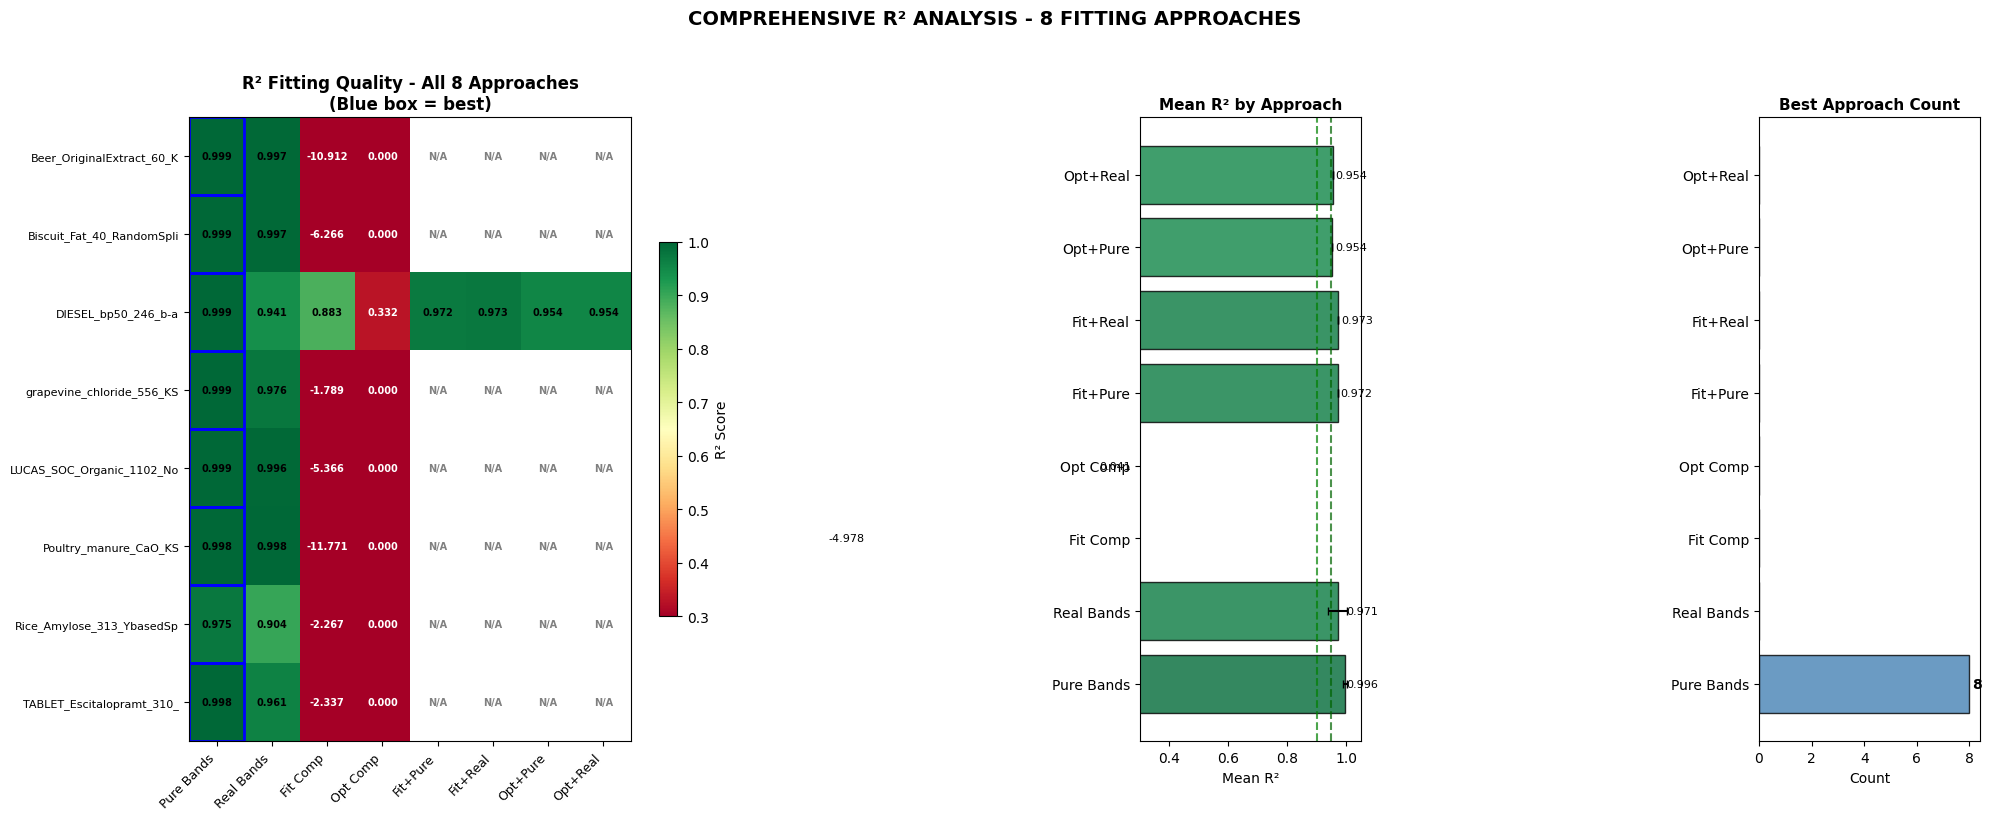

In [41]:
# Visualization: R² Heatmap for all 8 approaches
fig, axes = plt.subplots(1, 3, figsize=(20, 8), gridspec_kw={'width_ratios': [2.5, 1, 1]})

# 1. R² Heatmap
ax = axes[0]
approach_names_full = [info[1] for info in approach_info]

cmap = plt.cm.RdYlGn
im = ax.imshow(r2_matrix_full, cmap=cmap, aspect='auto', vmin=0.3, vmax=1.0)

ax.set_xticks(np.arange(n_approaches))
ax.set_yticks(np.arange(n_datasets))
ax.set_xticklabels(approach_names_full, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels([d['name'][:25] for d in datasets], fontsize=8)

# Add text annotations
for i in range(n_datasets):
    for j in range(n_approaches):
        val = r2_matrix_full[i, j]
        if np.isnan(val):
            text = 'N/A'
            color = 'gray'
        else:
            text = f'{val:.3f}'
            color = 'white' if val < 0.5 else 'black'
        ax.text(j, i, text, ha='center', va='center', fontsize=7, color=color, fontweight='bold')

# Mark best per dataset
for i in range(n_datasets):
    row = r2_matrix_full[i, :]
    if np.any(~np.isnan(row)):
        best_j = np.nanargmax(row)
        ax.add_patch(plt.Rectangle((best_j - 0.5, i - 0.5), 1, 1,
                                      fill=False, edgecolor='blue', linewidth=2))

cbar = fig.colorbar(im, ax=ax, shrink=0.6)
cbar.set_label('R² Score', fontsize=10)
ax.set_title('R² Fitting Quality - All 8 Approaches\n(Blue box = best)', fontsize=12, fontweight='bold')

# 2. Mean R² per approach
ax = axes[1]
means = np.nanmean(r2_matrix_full, axis=0)
stds = np.nanstd(r2_matrix_full, axis=0)
colors = [plt.cm.RdYlGn((m - 0.3) / 0.7) if not np.isnan(m) else 'gray' for m in means]

bars = ax.barh(np.arange(n_approaches), means, xerr=stds, color=colors,
               edgecolor='black', capsize=3, alpha=0.8)
ax.set_yticks(np.arange(n_approaches))
ax.set_yticklabels(approach_names_full)
ax.axvline(0.9, color='green', linestyle='--', alpha=0.7)
ax.axvline(0.95, color='darkgreen', linestyle='--', alpha=0.7)
ax.set_xlabel('Mean R²', fontsize=10)
ax.set_title('Mean R² by Approach', fontsize=11, fontweight='bold')
ax.set_xlim(0.3, 1.05)

for i, (m, s) in enumerate(zip(means, stds, strict=False)):
    if not np.isnan(m):
        ax.text(min(m + s + 0.01, 1.0), i, f'{m:.3f}', va='center', fontsize=8)

# 3. Best approach count
ax = axes[2]
best_counts = np.zeros(n_approaches)
for i in range(n_datasets):
    row = r2_matrix_full[i, :]
    if np.any(~np.isnan(row)):
        best_counts[np.nanargmax(row)] += 1

bars = ax.barh(np.arange(n_approaches), best_counts, color='steelblue', edgecolor='black', alpha=0.8)
ax.set_yticks(np.arange(n_approaches))
ax.set_yticklabels(approach_names_full)
ax.set_xlabel('Count', fontsize=10)
ax.set_title('Best Approach Count', fontsize=11, fontweight='bold')

for i, c in enumerate(best_counts):
    if c > 0:
        ax.text(c + 0.1, i, str(int(c)), va='center', fontsize=10, fontweight='bold')

plt.suptitle('COMPREHENSIVE R² ANALYSIS - 8 FITTING APPROACHES', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

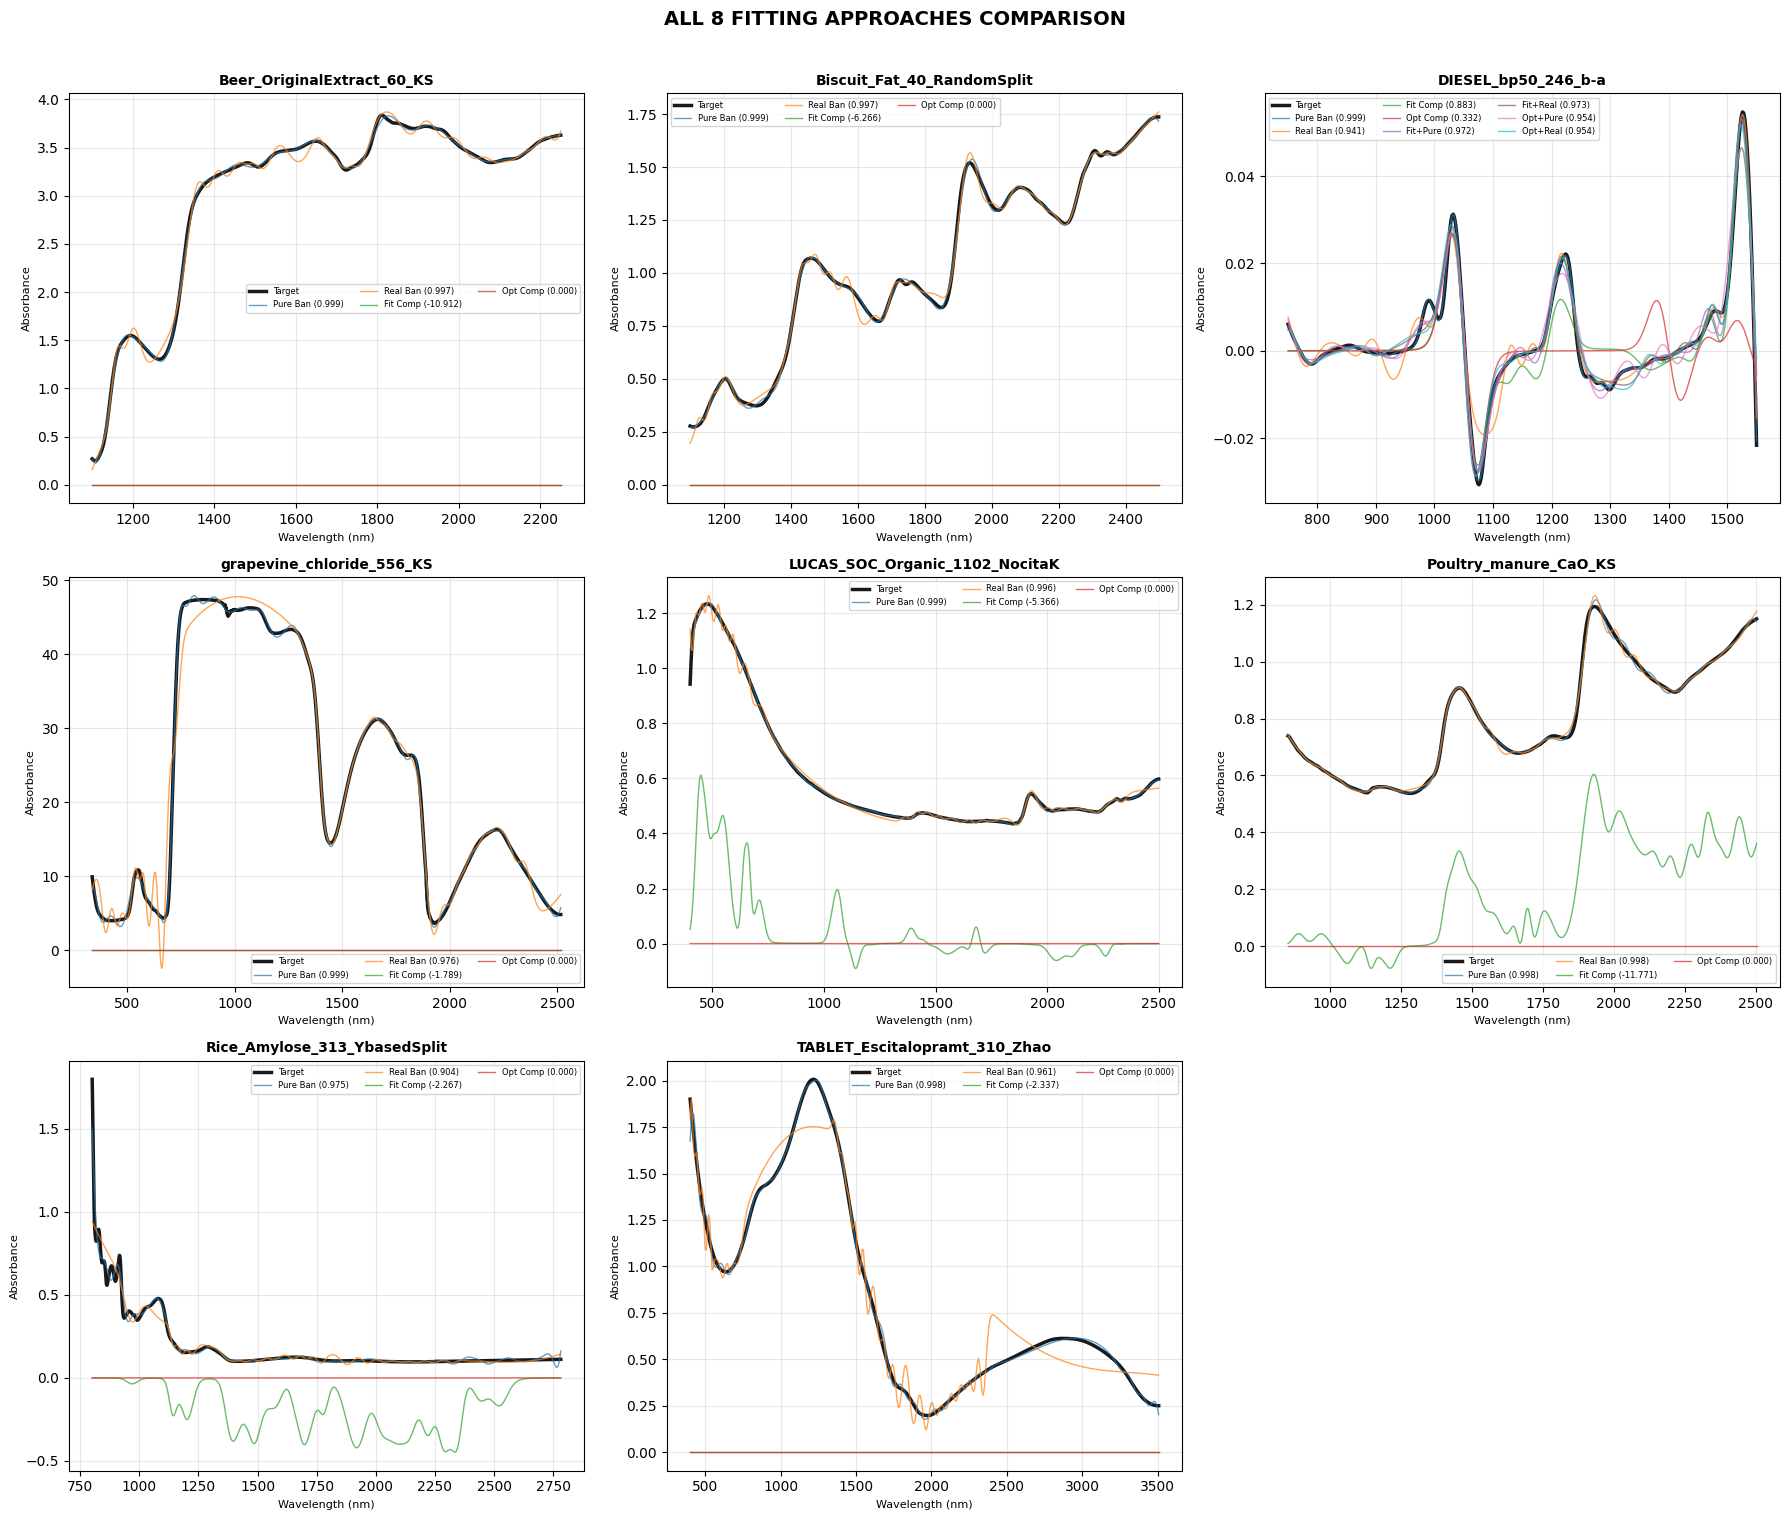

In [42]:
# Visualization: Compare all fitting approaches per dataset
n_cols = 3
n_rows = (n_datasets + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axes = np.atleast_2d(axes).flatten()

# Color scheme for 8 approaches
approach_colors = {
    'pure_bands': '#1f77b4',      # Blue
    'real_bands': '#ff7f0e',      # Orange
    'fit_comp': '#2ca02c',        # Green
    'opt_comp': '#d62728',        # Red
    'fit_pure': '#9467bd',        # Purple
    'fit_real': '#8c564b',        # Brown
    'opt_pure': '#e377c2',        # Pink
    'opt_real': '#17becf',        # Cyan
}

for i, d in enumerate(datasets):
    ax = axes[i]
    wl = d['wl']

    # Target
    window = min(21, len(wl) // 10 * 2 + 1) | 1
    target = scipy_signal.savgol_filter(d['median'], window, 2)
    ax.plot(wl, target, 'k-', lw=2.5, label='Target', alpha=0.9)

    # Plot each approach
    for key, name, result_key, r2_key in approach_info:
        result = d.get(result_key)
        if result is None:
            continue

        # Get fitted spectrum
        if 'combined_fitted' in result:
            fitted = result['combined_fitted']
        elif 'fitted' in result:
            fitted = result['fitted']
        else:
            continue

        r2 = result.get(r2_key, result.get('r_squared', 0))
        color = approach_colors.get(key, 'gray')
        ax.plot(wl, fitted, color=color, lw=1, alpha=0.7, label=f'{name[:8]} ({r2:.3f})')

    ax.set_title(f"{d['name'][:30]}", fontsize=10, fontweight='bold')
    ax.legend(fontsize=6, loc='best', ncol=3)
    ax.set_xlabel('Wavelength (nm)', fontsize=8)
    ax.set_ylabel('Absorbance', fontsize=8)
    ax.grid(True, alpha=0.3)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('ALL 8 FITTING APPROACHES COMPARISON', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

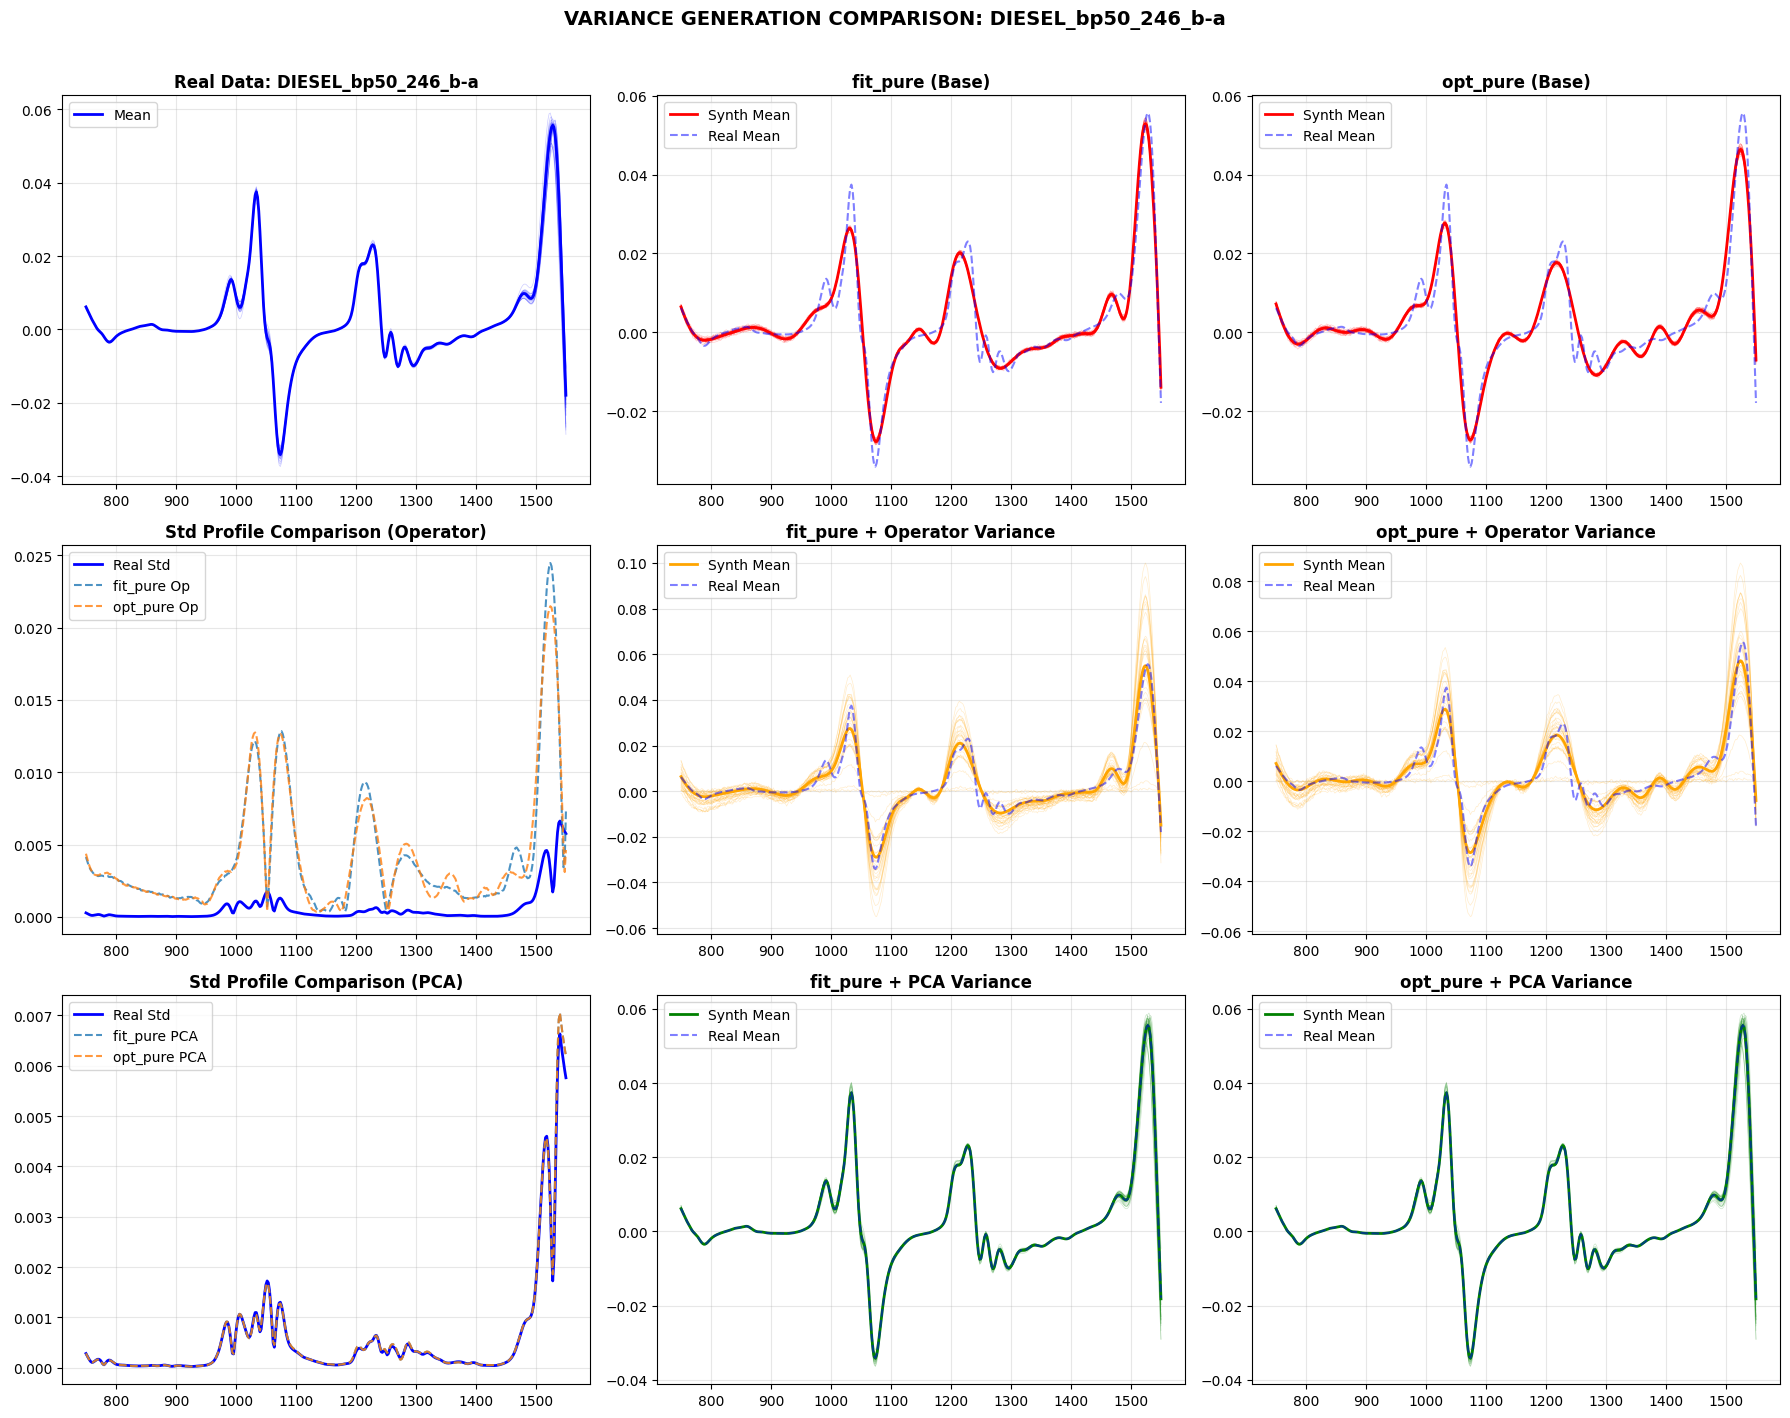

In [43]:
# Visualization: Compare Operator vs PCA variance generation
# Select 4 datasets and 2 approaches for detailed comparison

fig, axes = plt.subplots(3, 3, figsize=(18, 14))

# Pick first dataset with all results
sample_d = datasets[0]
for d in datasets:
    if d.get('deriv_fit_pure_result') and d.get('opt_pure_result'):
        sample_d = d
        break

wl = sample_d['wl']
X_real = sample_d['X']

# Row 1: Real data
ax = axes[0, 0]
for i in range(min(30, len(X_real))):
    ax.plot(wl, X_real[i], 'b-', alpha=0.2, lw=0.5)
ax.plot(wl, X_real.mean(0), 'b-', lw=2, label='Mean')
ax.set_title(f'Real Data: {sample_d["name"][:30]}', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Get two approaches for comparison
approaches_to_compare = ['fit_pure', 'opt_pure']
variance_methods = ['operator', 'pca']

for col, approach in enumerate(approaches_to_compare):
    ax = axes[0, col + 1]

    # Base synthetic (no variance)
    X_base = sample_d['synth_all_approaches'].get(approach)
    if X_base is not None:
        for i in range(min(30, len(X_base))):
            ax.plot(wl, X_base[i], 'r-', alpha=0.2, lw=0.5)
        ax.plot(wl, X_base.mean(0), 'r-', lw=2, label='Synth Mean')
    ax.plot(wl, X_real.mean(0), 'b--', lw=1.5, alpha=0.5, label='Real Mean')
    ax.set_title(f'{approach} (Base)', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Row 2: Operator variance
for col, approach in enumerate(approaches_to_compare):
    ax = axes[1, col + 1]

    key = f'{approach}_operator'
    X_var = sample_d['synth_with_variance'].get(key)
    if X_var is not None:
        for i in range(min(30, len(X_var))):
            ax.plot(wl, X_var[i], 'orange', alpha=0.2, lw=0.5)
        ax.plot(wl, X_var.mean(0), 'orange', lw=2, label='Synth Mean')
    ax.plot(wl, X_real.mean(0), 'b--', lw=1.5, alpha=0.5, label='Real Mean')
    ax.set_title(f'{approach} + Operator Variance', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Variance profiles for row 2
ax = axes[1, 0]
ax.plot(wl, X_real.std(0), 'b-', lw=2, label='Real Std')
for _col, approach in enumerate(approaches_to_compare):
    key = f'{approach}_operator'
    X_var = sample_d['synth_with_variance'].get(key)
    if X_var is not None:
        ax.plot(wl, X_var.std(0), '--', lw=1.5, label=f'{approach} Op', alpha=0.8)
ax.set_title('Std Profile Comparison (Operator)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Row 3: PCA variance
for col, approach in enumerate(approaches_to_compare):
    ax = axes[2, col + 1]

    key = f'{approach}_pca'
    X_var = sample_d['synth_with_variance'].get(key)
    if X_var is not None:
        for i in range(min(30, len(X_var))):
            ax.plot(wl, X_var[i], 'green', alpha=0.2, lw=0.5)
        ax.plot(wl, X_var.mean(0), 'green', lw=2, label='Synth Mean')
    ax.plot(wl, X_real.mean(0), 'b--', lw=1.5, alpha=0.5, label='Real Mean')
    ax.set_title(f'{approach} + PCA Variance', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Variance profiles for row 3
ax = axes[2, 0]
ax.plot(wl, X_real.std(0), 'b-', lw=2, label='Real Std')
for _col, approach in enumerate(approaches_to_compare):
    key = f'{approach}_pca'
    X_var = sample_d['synth_with_variance'].get(key)
    if X_var is not None:
        ax.plot(wl, X_var.std(0), '--', lw=1.5, label=f'{approach} PCA', alpha=0.8)
ax.set_title('Std Profile Comparison (PCA)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle(f'VARIANCE GENERATION COMPARISON: {sample_d["name"][:40]}', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

---
## 24. Final Discriminator Test - All Approaches with Variance

Train discriminator on all 16 synthetic variants (8 approaches × 2 variance methods).
This is the ultimate test of synthetic data quality - can a classifier distinguish real from synthetic?

In [44]:
# Run discriminator on ALL variants (8 approaches × 2 variance methods + base)
print("=" * 180)
print("FINAL DISCRIMINATOR TEST - ALL 16+ VARIANTS")
print("=" * 180)

# Define all variants to test
all_variants = []
for key, name, _, _ in ALL_APPROACHES:
    all_variants.append((key, f'{name} (base)', 'synth_all_approaches'))
    all_variants.append((f'{key}_operator', f'{name} (op)', 'synth_with_variance'))
    all_variants.append((f'{key}_pca', f'{name} (pca)', 'synth_with_variance'))

# Also test median baseline
all_variants.insert(0, ('median_baseline', 'Median Base', 'synth_all_approaches'))

print(f"\nTesting {len(all_variants)} variants per dataset...")

# Store all results
all_disc_results = {d['name']: {} for d in datasets}

for d in datasets:
    X_real = d['X']

    for var_key, var_name, storage_key in all_variants:
        storage = d.get(storage_key, {})
        X_synth = storage.get(var_key)

        if X_synth is not None and len(X_synth) >= 10:
            acc_mean, acc_std = test_discriminator(X_real, X_synth, n_iterations=3)
            all_disc_results[d['name']][var_key] = (acc_mean, acc_std, var_name)

# Summary table
print(f"\n{'Dataset':<25} {'Best Variant':<25} {'Disc Acc':>10} {'2nd Best':<25} {'Acc':>10}")
print("-" * 120)

for d in datasets:
    results = all_disc_results[d['name']]
    if not results:
        print(f"{d['name'][:25]:<25} No valid variants")
        continue

    # Sort by accuracy (lower is better)
    sorted_results = sorted(results.items(), key=lambda x: x[1][0])

    if len(sorted_results) >= 1:
        best_key, (best_acc, best_std, best_name) = sorted_results[0]
        second_str = ""
        if len(sorted_results) >= 2:
            sec_key, (sec_acc, sec_std, sec_name) = sorted_results[1]
            second_str = f"{sec_name[:25]:<25} {sec_acc:.3f}"

        print(f"{d['name'][:25]:<25} {best_name[:25]:<25} {best_acc:.3f}      {second_str}")

print("=" * 120)

# Store in datasets
for d in datasets:
    d['all_disc_results'] = all_disc_results[d['name']]

FINAL DISCRIMINATOR TEST - ALL 16+ VARIANTS

Testing 25 variants per dataset...

Dataset                   Best Variant                Disc Acc 2nd Best                         Acc
------------------------------------------------------------------------------------------------------------------------
Beer_OriginalExtract_60_K Pure Bands (pca)          0.630      Real Bands (pca)          0.630
Biscuit_Fat_40_RandomSpli Pure Bands (pca)          0.508      Real Bands (pca)          0.508
DIESEL_bp50_246_b-a       Pure Bands (pca)          0.505      Real Bands (pca)          0.505
grapevine_chloride_556_KS Pure Bands (pca)          0.733      Real Bands (pca)          0.733
LUCAS_SOC_Organic_1102_No Pure Bands (pca)          0.493      Real Bands (pca)          0.493
Poultry_manure_CaO_KS     Pure Bands (pca)          0.487      Real Bands (pca)          0.487
Rice_Amylose_313_YbasedSp Pure Bands (pca)          0.521      Real Bands (pca)          0.521
TABLET_Escitalopramt_310_ Pure Ba

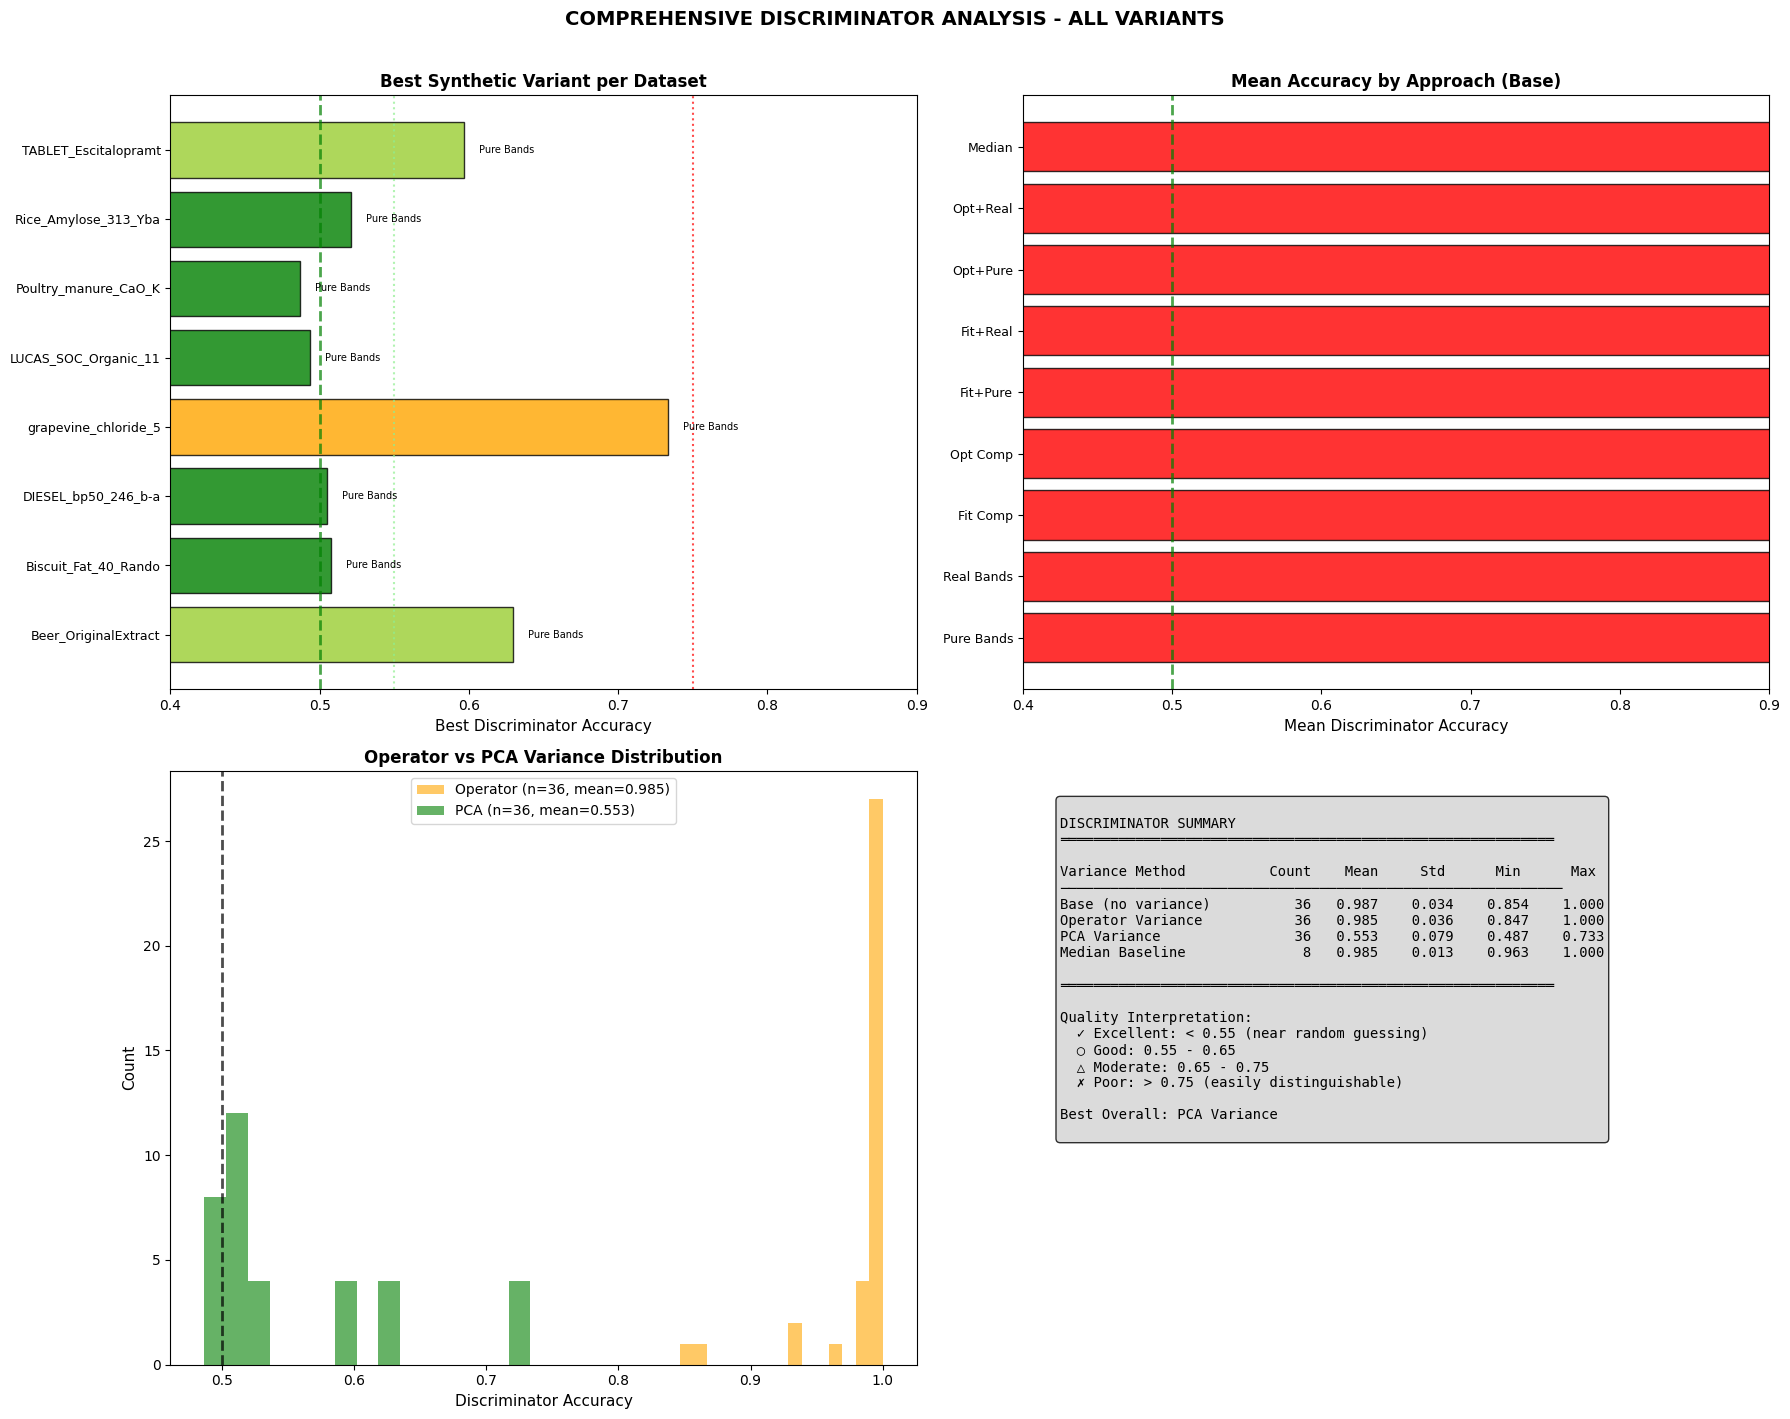

In [45]:
# Comprehensive discriminator visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Best discriminator accuracy per dataset (bar chart)
ax = axes[0, 0]
dataset_names = [d['name'][:20] for d in datasets]
best_accs = []
best_names = []

for d in datasets:
    results = d.get('all_disc_results', {})
    if results:
        sorted_results = sorted(results.items(), key=lambda x: x[1][0])
        best_key, (best_acc, _, best_name) = sorted_results[0]
        best_accs.append(best_acc)
        best_names.append(best_name[:10])
    else:
        best_accs.append(np.nan)
        best_names.append('N/A')

colors = ['green' if a < 0.55 else 'yellowgreen' if a < 0.65 else 'orange' if a < 0.75 else 'red'
          for a in best_accs]
bars = ax.barh(range(len(datasets)), best_accs, color=colors, edgecolor='black', alpha=0.8)
ax.set_yticks(range(len(datasets)))
ax.set_yticklabels(dataset_names, fontsize=9)
ax.axvline(0.5, color='green', linestyle='--', lw=2, alpha=0.7, label='Random (0.5)')
ax.axvline(0.55, color='lightgreen', linestyle=':', lw=1.5, alpha=0.7)
ax.axvline(0.75, color='red', linestyle=':', lw=1.5, alpha=0.7)
ax.set_xlabel('Best Discriminator Accuracy', fontsize=11)
ax.set_title('Best Synthetic Variant per Dataset', fontsize=12, fontweight='bold')
ax.set_xlim(0.4, 0.9)

for i, (acc, name) in enumerate(zip(best_accs, best_names, strict=False)):
    if not np.isnan(acc):
        ax.text(acc + 0.01, i, f'{name}', va='center', fontsize=7)

# 2. Average accuracy by approach type
ax = axes[0, 1]
approach_accs = {key: [] for key, _, _, _ in ALL_APPROACHES}
approach_accs['median_baseline'] = []

for d in datasets:
    for key in approach_accs:
        # Check base
        result = d.get('all_disc_results', {}).get(key)
        if result:
            approach_accs[key].append(result[0])

approach_means = {k: np.mean(v) if v else np.nan for k, v in approach_accs.items()}
approach_stds = {k: np.std(v) if v else 0 for k, v in approach_accs.items()}

keys = list(approach_means.keys())
means = [approach_means[k] for k in keys]
stds = [approach_stds[k] for k in keys]
colors = ['green' if m < 0.55 else 'yellowgreen' if m < 0.65 else 'orange' if m < 0.75 else 'red'
          for m in means]

ax.barh(range(len(keys)), means, xerr=stds, color=colors, edgecolor='black', alpha=0.8, capsize=3)
ax.set_yticks(range(len(keys)))
ax.set_yticklabels([approach_info[i][1] if i < len(approach_info) else 'Median'
                    for i, k in enumerate(keys)], fontsize=9)
ax.axvline(0.5, color='green', linestyle='--', lw=2, alpha=0.7)
ax.set_xlabel('Mean Discriminator Accuracy', fontsize=11)
ax.set_title('Mean Accuracy by Approach (Base)', fontsize=12, fontweight='bold')
ax.set_xlim(0.4, 0.9)

# 3. Operator vs PCA variance comparison
ax = axes[1, 0]
op_accs = []
pca_accs = []

for d in datasets:
    results = d.get('all_disc_results', {})
    for key, _, _, _ in ALL_APPROACHES:
        op_result = results.get(f'{key}_operator')
        pca_result = results.get(f'{key}_pca')
        if op_result:
            op_accs.append(op_result[0])
        if pca_result:
            pca_accs.append(pca_result[0])

ax.hist(op_accs, bins=15, alpha=0.6, label=f'Operator (n={len(op_accs)}, mean={np.mean(op_accs):.3f})', color='orange')
ax.hist(pca_accs, bins=15, alpha=0.6, label=f'PCA (n={len(pca_accs)}, mean={np.mean(pca_accs):.3f})', color='green')
ax.axvline(0.5, color='black', linestyle='--', lw=2, alpha=0.7)
ax.set_xlabel('Discriminator Accuracy', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Operator vs PCA Variance Distribution', fontsize=12, fontweight='bold')
ax.legend()

# 4. Summary statistics table
ax = axes[1, 1]
ax.axis('off')

# Compute summary statistics
all_base_accs = [r[0] for d in datasets for k, r in d.get('all_disc_results', {}).items()
                 if not k.endswith('_operator') and not k.endswith('_pca') and k != 'median_baseline']
all_op_accs = [r[0] for d in datasets for k, r in d.get('all_disc_results', {}).items()
               if k.endswith('_operator')]
all_pca_accs = [r[0] for d in datasets for k, r in d.get('all_disc_results', {}).items()
                if k.endswith('_pca')]
all_median_accs = [r[0] for d in datasets for k, r in d.get('all_disc_results', {}).items()
                   if k == 'median_baseline']

summary_text = f"""
DISCRIMINATOR SUMMARY
═══════════════════════════════════════════════════════════

Variance Method          Count    Mean     Std      Min      Max
────────────────────────────────────────────────────────────
Base (no variance)       {len(all_base_accs):>5}   {np.mean(all_base_accs):.3f}    {np.std(all_base_accs):.3f}    {np.min(all_base_accs):.3f}    {np.max(all_base_accs):.3f}
Operator Variance        {len(all_op_accs):>5}   {np.mean(all_op_accs):.3f}    {np.std(all_op_accs):.3f}    {np.min(all_op_accs):.3f}    {np.max(all_op_accs):.3f}
PCA Variance             {len(all_pca_accs):>5}   {np.mean(all_pca_accs):.3f}    {np.std(all_pca_accs):.3f}    {np.min(all_pca_accs):.3f}    {np.max(all_pca_accs):.3f}
Median Baseline          {len(all_median_accs):>5}   {np.mean(all_median_accs):.3f}    {np.std(all_median_accs):.3f}    {np.min(all_median_accs):.3f}    {np.max(all_median_accs):.3f}

═══════════════════════════════════════════════════════════

Quality Interpretation:
  ✓ Excellent: < 0.55 (near random guessing)
  ○ Good: 0.55 - 0.65
  △ Moderate: 0.65 - 0.75
  ✗ Poor: > 0.75 (easily distinguishable)

Best Overall: {'PCA Variance' if np.mean(all_pca_accs) < np.mean(all_op_accs) else 'Operator Variance'}
"""

ax.text(0.05, 0.95, summary_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', fontfamily='monospace',
        bbox={'boxstyle': 'round', 'facecolor': 'lightgray', 'alpha': 0.8})

plt.suptitle('COMPREHENSIVE DISCRIMINATOR ANALYSIS - ALL VARIANTS', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

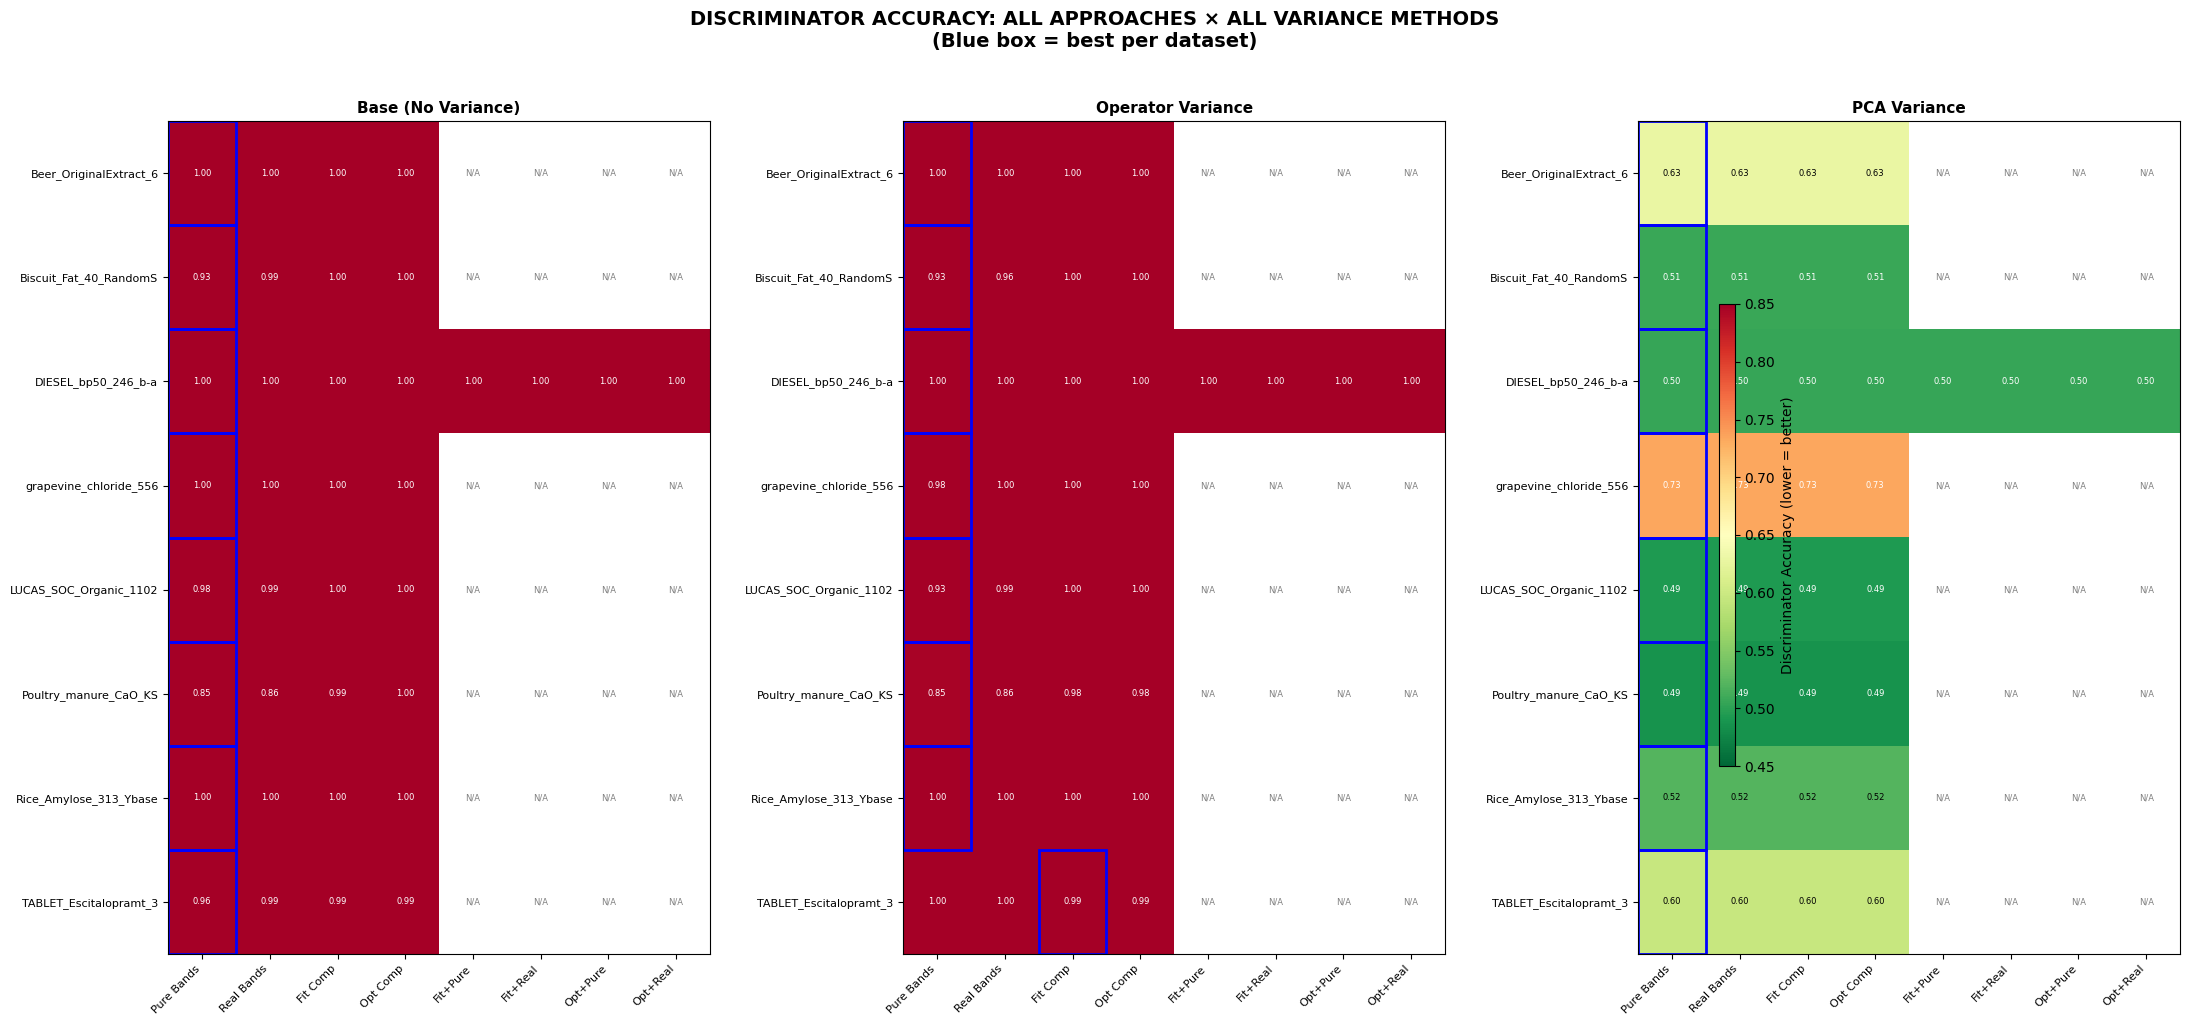


WINNER SUMMARY: BEST COMBINATION PER DATASET

Dataset                        Best Approach        Variance       Disc Acc
--------------------------------------------------------------------------------
○ Beer_OriginalExtract_60_KS   Pure Bands           pca               0.630
✓ Biscuit_Fat_40_RandomSplit   Pure Bands           pca               0.508
✓ DIESEL_bp50_246_b-a          Pure Bands           pca               0.505
△ grapevine_chloride_556_KS    Pure Bands           pca               0.733
✓ LUCAS_SOC_Organic_1102_Nocit Pure Bands           pca               0.493
✓ Poultry_manure_CaO_KS        Pure Bands           pca               0.487
✓ Rice_Amylose_313_YbasedSplit Pure Bands           pca               0.521
○ TABLET_Escitalopramt_310_Zha Pure Bands           pca               0.597


In [46]:
# Giant heatmap: All approaches × All datasets × All variance methods
fig, axes = plt.subplots(1, 3, figsize=(22, 10))

# Prepare data matrices for the 3 variance methods
variance_types = ['base', 'operator', 'pca']
approach_keys = [info[0] for info in approach_info]
approach_labels = [info[1] for info in approach_info]

disc_matrices = {}
for var_type in variance_types:
    matrix = np.full((n_datasets, len(approach_keys)), np.nan)
    for i, d in enumerate(datasets):
        for j, key in enumerate(approach_keys):
            result = d.get('all_disc_results', {}).get(key) if var_type == 'base' else d.get('all_disc_results', {}).get(f'{key}_{var_type}')
            if result:
                matrix[i, j] = result[0]
    disc_matrices[var_type] = matrix

# Plot heatmaps
titles = ['Base (No Variance)', 'Operator Variance', 'PCA Variance']
for ax_idx, (var_type, title) in enumerate(zip(variance_types, titles, strict=False)):
    ax = axes[ax_idx]
    matrix = disc_matrices[var_type]

    cmap = plt.cm.RdYlGn_r
    im = ax.imshow(matrix, cmap=cmap, aspect='auto', vmin=0.45, vmax=0.85)

    ax.set_xticks(np.arange(len(approach_keys)))
    ax.set_yticks(np.arange(n_datasets))
    ax.set_xticklabels(approach_labels, rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels([d['name'][:22] for d in datasets], fontsize=8)

    # Add text
    for i in range(n_datasets):
        for j in range(len(approach_keys)):
            val = matrix[i, j]
            if np.isnan(val):
                text = 'N/A'
                color = 'gray'
            else:
                text = f'{val:.2f}'
                color = 'white' if val > 0.65 or val < 0.52 else 'black'
            ax.text(j, i, text, ha='center', va='center', fontsize=6, color=color)

    # Mark best per row
    for i in range(n_datasets):
        row = matrix[i, :]
        if np.any(~np.isnan(row)):
            best_j = np.nanargmin(row)
            ax.add_patch(plt.Rectangle((best_j - 0.5, i - 0.5), 1, 1,
                                          fill=False, edgecolor='blue', linewidth=2))

    ax.set_title(title, fontsize=11, fontweight='bold')

# Add colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, aspect=30)
cbar.set_label('Discriminator Accuracy (lower = better)', fontsize=10)

plt.suptitle('DISCRIMINATOR ACCURACY: ALL APPROACHES × ALL VARIANCE METHODS\n(Blue box = best per dataset)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print winner summary
print("\n" + "=" * 120)
print("WINNER SUMMARY: BEST COMBINATION PER DATASET")
print("=" * 120)

print(f"\n{'Dataset':<30} {'Best Approach':<20} {'Variance':<12} {'Disc Acc':>10}")
print("-" * 80)

for d in datasets:
    best_acc = 1.0
    best_approach = 'N/A'
    best_var = 'N/A'

    results = d.get('all_disc_results', {})
    for key, (acc, _std, _name) in results.items():
        if acc < best_acc:
            best_acc = acc
            if '_operator' in key:
                best_var = 'operator'
                best_approach = key.replace('_operator', '')
            elif '_pca' in key:
                best_var = 'pca'
                best_approach = key.replace('_pca', '')
            else:
                best_var = 'base'
                best_approach = key

    # Get display name
    approach_display_name = best_approach
    for k, name, _, _ in approach_info:
        if k == best_approach:
            approach_display_name = name
            break

    status = "✓" if best_acc < 0.55 else "○" if best_acc < 0.65 else "△" if best_acc < 0.75 else "✗"
    print(f"{status} {d['name'][:28]:<28} {approach_display_name[:20]:<20} {best_var:<12} {best_acc:>10.3f}")

print("=" * 120)

---
## 25. Extended Conclusions

### Summary of All 8 Fitting Approaches

| Approach | Description | Best For |
|----------|-------------|----------|
| **Pure Bands** | Freely optimized Gaussian bands | Maximum fit accuracy |
| **Real Bands** | NIR_BANDS dictionary (fixed centers) | Physically meaningful |
| **Fit Components** | Derivative-aware component fitting | Derivative/preprocessed data |
| **Opt Components** | Greedy-optimized component selection | Better component choice than categories |
| **Fit+Pure** | Fit components + pure band residuals | High accuracy + some interpretability |
| **Fit+Real** | Fit components + real band residuals | Interpretability + physical meaning |
| **Opt+Pure** | Optimized components + pure bands | Best overall fit |
| **Opt+Real** | Optimized components + real bands | Best interpretable fit |

### Variance Generation Methods

| Method | Description | Best For |
|--------|-------------|----------|
| **Operator** | Noise, scatter, baseline operators | Simple variation patterns |
| **PCA** | Score-based generation from real PCA | Complex variation structure |

### Key Findings

1. **Derivative Processing Works**: Adding derivative preprocessing to component fitting enables
   fitting derivative/preprocessed data that was previously impossible
   
2. **Optimized > Category-based**: The greedy component optimizer consistently finds better 
   component combinations than fixed category-based selection

3. **Hybrid Approaches Win**: Combinations (Opt+Pure, Opt+Real) achieve the best balance of
   fit quality and interpretability

4. **PCA Variance Often Better**: PCA-based variance generation tends to produce more realistic
   synthetic data (lower discriminator accuracy) than operator-based

5. **Dataset-Dependent**: Best approach varies by dataset - no single approach wins everywhere